In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
import torch 
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# file_path = 'data/daily_min_temp.csv'
# df = pd.read_csv(file_path, parse_dates=["Date"])
# df["quarter"] = df.Date.dt.quarter
# df = pd.get_dummies(df, columns=["quarter"])
# df.set_index("Date", inplace=True)
# df.head()

In [4]:
import pandas as pd
file_path = 'data/JOG_monthly.csv'
df = pd.read_csv(file_path, delimiter=';')
df['Date'] = pd.to_datetime(df['THBL'], format='%Y%m')
df['GWH_JUAL'] = MinMaxScaler().fit_transform(df[['GWH_JUAL']])
# df["Month"] = df.Date.dt.month
# df = pd.get_dummies(df, columns=["Month"])
df.set_index('Date', inplace=True)
df.drop(columns='THBL', inplace=True)
df.head()

GWH_JUAL
Date                
2015-01-01  0.094838
2015-02-01  0.000000
2015-03-01  0.115178
2015-04-01  0.115373
2015-05-01  0.162993


# Dataset Splitting 

In [5]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((90, 1), (23, 1))

# Dataset & Dataloader

In [6]:
from torch.utils.data import DataLoader
from jcopdl.utils.dataloader import TimeSeriesDataset

In [7]:
seq_len = 6
bs = 2

train_set = TimeSeriesDataset(ts_train, "GWH_JUAL", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "GWH_JUAL", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (14, 6, 1)
Note: last 5 data excluded

(N, S, F): (3, 6, 1)
Note: last 4 data excluded



# Arsitektur & Config

In [8]:
from jcopdl.layers import linear_block

In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [10]:
config = set_config({
    "input_size": train_set.n_feature,
    "output_size": 1,
    "hidden_size": 8,
    "num_layers": 2,
    "dropout": 0,
    "seq_len": train_set.n_seq
})

# Training Preparation --> MCOC

In [11]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
callback = Callback(model, config, outdir="model/LSTM")

# Training

In [12]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0 
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)

        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
    cost = cost /len(dataset)
    return cost

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.1987 | Test_cost  = 0.6954 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.1959 | Test_cost  = 0.6900 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.1931 | Test_cost  = 0.6846 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.1904 | Test_cost  = 0.6793 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.1877 | Test_cost  = 0.6740 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.1851 | Test_cost  = 0.6687 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.1825 | Test_cost  = 0.6636 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.1800 | Test_cost  = 0.6584 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1774 | Test_cost  = 0.6533 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1749 | Test_cost  = 0.6482 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1725 | Test_cost  = 0.6432 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1700 | Test_cost  = 0.6381 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1676 | Test_cost  = 0.6331 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1652 | Test_cost  = 0.6280 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1628 | Test_cost  = 0.6230 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.1604 | Test_cost  = 0.6179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.1580 | Test_cost  = 0.6129 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.1556 | Test_cost  = 0.6078 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.1533 | Test_cost  = 0.6028 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.1510 | Test_cost  = 0.5977 | 


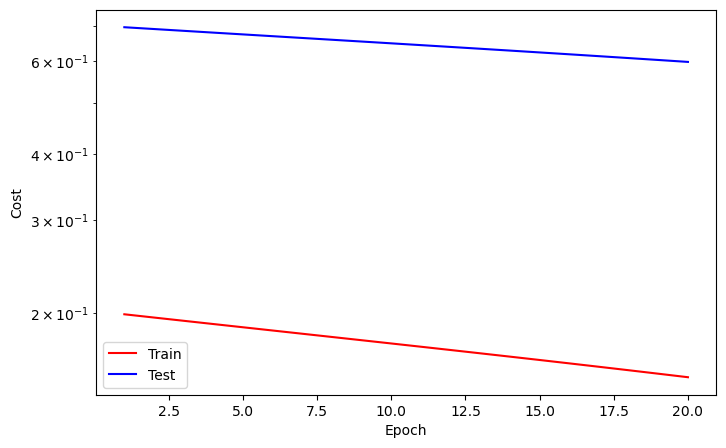

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.1486 | Test_cost  = 0.5927 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.1463 | Test_cost  = 0.5876 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.1440 | Test_cost  = 0.5825 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.1417 | Test_cost  = 0.5774 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.1394 | Test_cost  = 0.5723 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.1372 | Test_cost  = 0.5672 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.1349 | Test_cost  = 0.5621 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.1326 | Test_cost  = 0.5570 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.1304 | Test_cost  = 0.5518 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.1281 | Test_cost  = 0.5466 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.1259 | Test_cost  = 0.5415 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.1237 | Test_cost  = 0.5363 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.1215 | Test_cost  = 0.5311 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.1193 | Test_cost  = 0.5258 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.1171 | Test_cost  = 0.5206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.1149 | Test_cost  = 0.5154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.1127 | Test_cost  = 0.5101 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.1105 | Test_cost  = 0.5048 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.1084 | Test_cost  = 0.4995 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.1062 | Test_cost  = 0.4942 | 


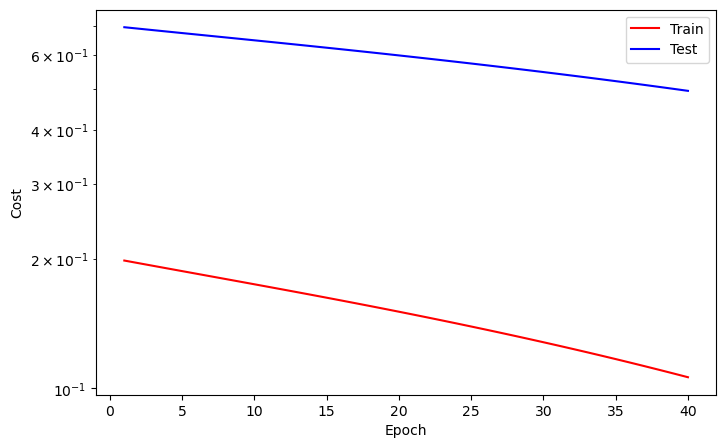

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    41
Train_cost  = 0.1041 | Test_cost  = 0.4889 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    42
Train_cost  = 0.1019 | Test_cost  = 0.4835 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    43
Train_cost  = 0.0998 | Test_cost  = 0.4782 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    44
Train_cost  = 0.0977 | Test_cost  = 0.4728 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    45
Train_cost  = 0.0956 | Test_cost  = 0.4675 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    46
Train_cost  = 0.0935 | Test_cost  = 0.4621 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    47
Train_cost  = 0.0915 | Test_cost  = 0.4567 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    48
Train_cost  = 0.0894 | Test_cost  = 0.4513 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    49
Train_cost  = 0.0874 | Test_cost  = 0.4460 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    50
Train_cost  = 0.0854 | Test_cost  = 0.4406 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    51
Train_cost  = 0.0834 | Test_cost  = 0.4352 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    52
Train_cost  = 0.0814 | Test_cost  = 0.4298 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    53
Train_cost  = 0.0795 | Test_cost  = 0.4245 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    54
Train_cost  = 0.0775 | Test_cost  = 0.4191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    55
Train_cost  = 0.0756 | Test_cost  = 0.4138 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    56
Train_cost  = 0.0738 | Test_cost  = 0.4084 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    57
Train_cost  = 0.0719 | Test_cost  = 0.4031 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    58
Train_cost  = 0.0701 | Test_cost  = 0.3978 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    59
Train_cost  = 0.0683 | Test_cost  = 0.3925 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    60
Train_cost  = 0.0665 | Test_cost  = 0.3873 | 


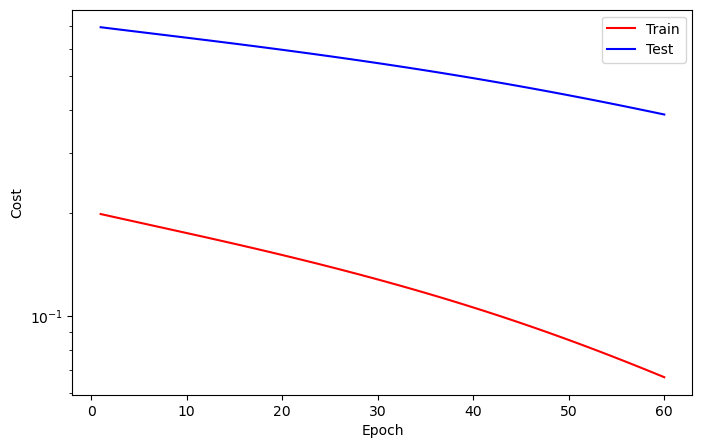

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    61
Train_cost  = 0.0648 | Test_cost  = 0.3821 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    62
Train_cost  = 0.0631 | Test_cost  = 0.3769 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    63
Train_cost  = 0.0614 | Test_cost  = 0.3717 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    64
Train_cost  = 0.0597 | Test_cost  = 0.3666 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    65
Train_cost  = 0.0581 | Test_cost  = 0.3615 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    66
Train_cost  = 0.0566 | Test_cost  = 0.3565 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    67
Train_cost  = 0.0550 | Test_cost  = 0.3515 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    68
Train_cost  = 0.0535 | Test_cost  = 0.3466 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    69
Train_cost  = 0.0521 | Test_cost  = 0.3417 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    70
Train_cost  = 0.0507 | Test_cost  = 0.3369 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    71
Train_cost  = 0.0493 | Test_cost  = 0.3321 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    72
Train_cost  = 0.0479 | Test_cost  = 0.3274 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    73
Train_cost  = 0.0466 | Test_cost  = 0.3227 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    74
Train_cost  = 0.0454 | Test_cost  = 0.3182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    75
Train_cost  = 0.0442 | Test_cost  = 0.3137 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    76
Train_cost  = 0.0430 | Test_cost  = 0.3093 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    77
Train_cost  = 0.0419 | Test_cost  = 0.3049 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    78
Train_cost  = 0.0408 | Test_cost  = 0.3006 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    79
Train_cost  = 0.0397 | Test_cost  = 0.2965 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    80
Train_cost  = 0.0387 | Test_cost  = 0.2924 | 


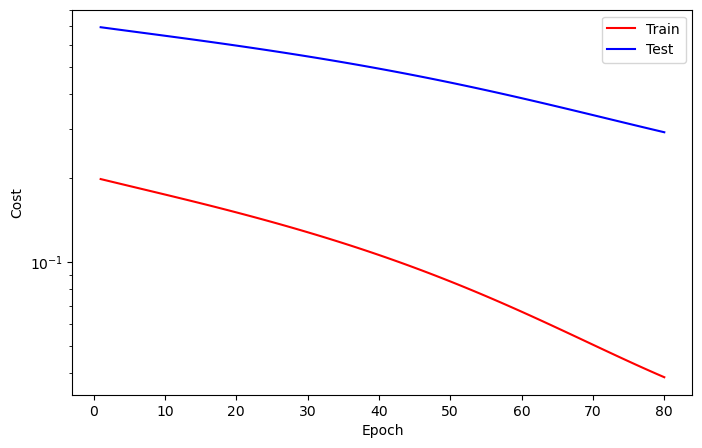

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    81
Train_cost  = 0.0378 | Test_cost  = 0.2884 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    82
Train_cost  = 0.0369 | Test_cost  = 0.2845 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    83
Train_cost  = 0.0360 | Test_cost  = 0.2806 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    84
Train_cost  = 0.0352 | Test_cost  = 0.2769 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    85
Train_cost  = 0.0344 | Test_cost  = 0.2733 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    86
Train_cost  = 0.0336 | Test_cost  = 0.2697 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    87
Train_cost  = 0.0329 | Test_cost  = 0.2663 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    88
Train_cost  = 0.0322 | Test_cost  = 0.2629 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    89
Train_cost  = 0.0316 | Test_cost  = 0.2597 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    90
Train_cost  = 0.0310 | Test_cost  = 0.2565 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    91
Train_cost  = 0.0304 | Test_cost  = 0.2535 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    92
Train_cost  = 0.0299 | Test_cost  = 0.2505 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    93
Train_cost  = 0.0294 | Test_cost  = 0.2477 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    94
Train_cost  = 0.0289 | Test_cost  = 0.2449 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    95
Train_cost  = 0.0285 | Test_cost  = 0.2423 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    96
Train_cost  = 0.0281 | Test_cost  = 0.2397 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    97
Train_cost  = 0.0277 | Test_cost  = 0.2372 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    98
Train_cost  = 0.0273 | Test_cost  = 0.2349 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch    99
Train_cost  = 0.0270 | Test_cost  = 0.2326 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   100
Train_cost  = 0.0267 | Test_cost  = 0.2304 | 


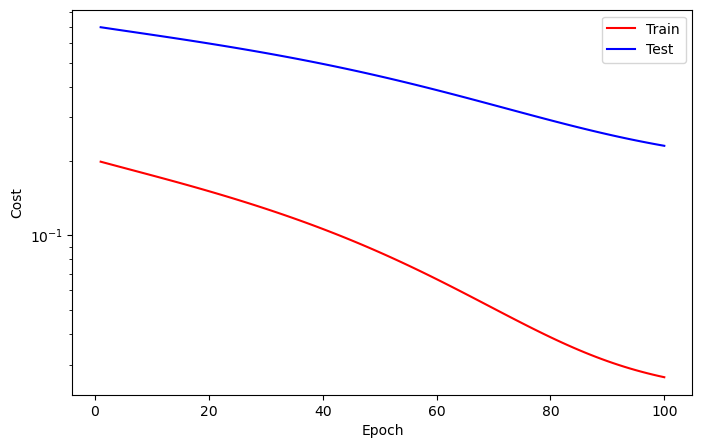

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   101
Train_cost  = 0.0264 | Test_cost  = 0.2283 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   102
Train_cost  = 0.0261 | Test_cost  = 0.2263 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   103
Train_cost  = 0.0258 | Test_cost  = 0.2243 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   104
Train_cost  = 0.0256 | Test_cost  = 0.2225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   105
Train_cost  = 0.0254 | Test_cost  = 0.2207 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   119
Train_cost  = 0.0234 | Test_cost  = 0.2027 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   120
Train_cost  = 0.0233 | Test_cost  = 0.2018 | 


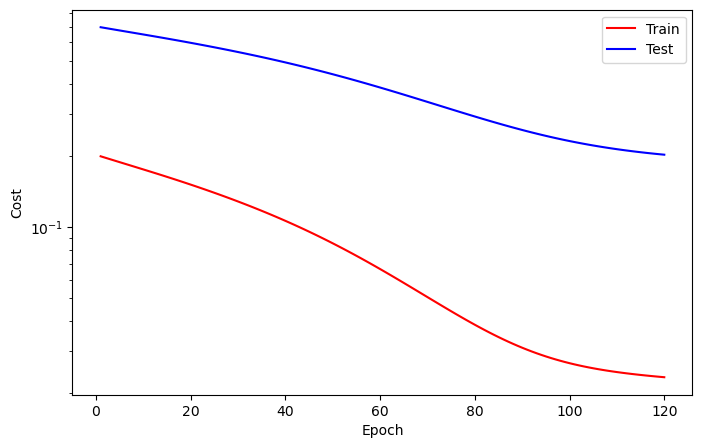

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   121
Train_cost  = 0.0232 | Test_cost  = 0.2010 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   122
Train_cost  = 0.0231 | Test_cost  = 0.2001 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   123
Train_cost  = 0.0230 | Test_cost  = 0.1994 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   124
Train_cost  = 0.0229 | Test_cost  = 0.1986 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   125
Train_cost  = 0.0229 | Test_cost  = 0.1979 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   126
Train_cost  = 0.0228 | Test_cost  = 0.1972 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   127
Train_cost  = 0.0227 | Test_cost  = 0.1966 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   128
Train_cost  = 0.0226 | Test_cost  = 0.1960 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   129
Train_cost  = 0.0226 | Test_cost  = 0.1954 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   130
Train_cost  = 0.0225 | Test_cost  = 0.1948 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   131
Train_cost  = 0.0224 | Test_cost  = 0.1942 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   132
Train_cost  = 0.0223 | Test_cost  = 0.1937 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   133
Train_cost  = 0.0223 | Test_cost  = 0.1932 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   134
Train_cost  = 0.0222 | Test_cost  = 0.1927 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   135
Train_cost  = 0.0221 | Test_cost  = 0.1922 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   136
Train_cost  = 0.0221 | Test_cost  = 0.1918 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   137
Train_cost  = 0.0220 | Test_cost  = 0.1914 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   138
Train_cost  = 0.0220 | Test_cost  = 0.1909 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   139
Train_cost  = 0.0219 | Test_cost  = 0.1905 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   140
Train_cost  = 0.0218 | Test_cost  = 0.1901 | 


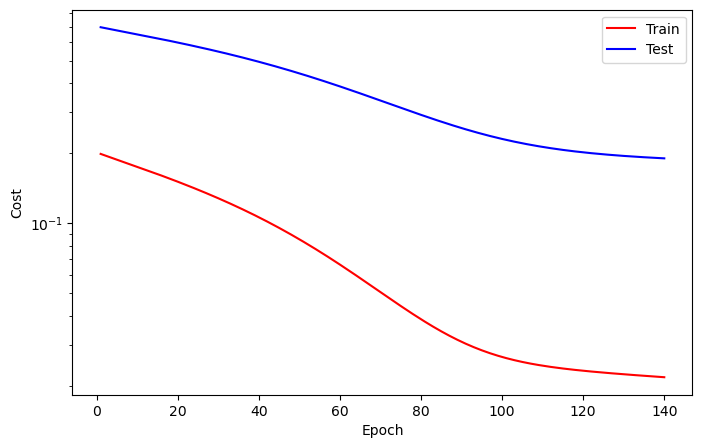

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   141
Train_cost  = 0.0218 | Test_cost  = 0.1898 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   142
Train_cost  = 0.0217 | Test_cost  = 0.1894 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   143
Train_cost  = 0.0217 | Test_cost  = 0.1891 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   144
Train_cost  = 0.0216 | Test_cost  = 0.1887 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   145
Train_cost  = 0.0215 | Test_cost  = 0.1884 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   146
Train_cost  = 0.0215 | Test_cost  = 0.1881 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   147
Train_cost  = 0.0214 | Test_cost  = 0.1877 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   148
Train_cost  = 0.0214 | Test_cost  = 0.1874 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   149
Train_cost  = 0.0213 | Test_cost  = 0.1871 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   150
Train_cost  = 0.0212 | Test_cost  = 0.1868 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   151
Train_cost  = 0.0212 | Test_cost  = 0.1866 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   152
Train_cost  = 0.0211 | Test_cost  = 0.1863 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   153
Train_cost  = 0.0211 | Test_cost  = 0.1860 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   154
Train_cost  = 0.0210 | Test_cost  = 0.1858 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   155
Train_cost  = 0.0210 | Test_cost  = 0.1855 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   156
Train_cost  = 0.0209 | Test_cost  = 0.1852 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   157
Train_cost  = 0.0209 | Test_cost  = 0.1850 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   158
Train_cost  = 0.0208 | Test_cost  = 0.1848 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   159
Train_cost  = 0.0208 | Test_cost  = 0.1845 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   160
Train_cost  = 0.0207 | Test_cost  = 0.1843 | 


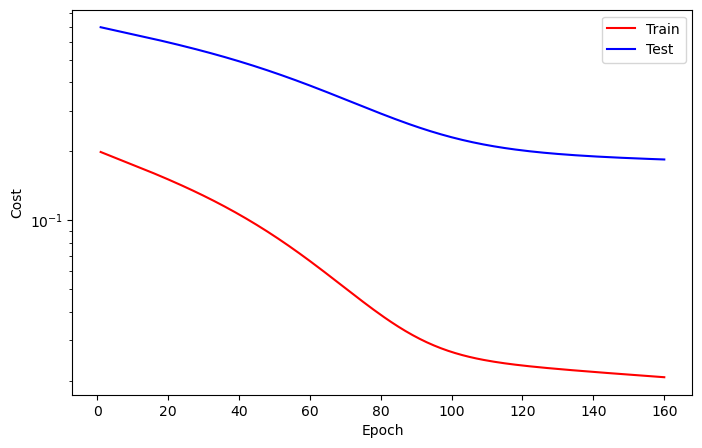

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   161
Train_cost  = 0.0206 | Test_cost  = 0.1841 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   162
Train_cost  = 0.0206 | Test_cost  = 0.1838 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   163
Train_cost  = 0.0205 | Test_cost  = 0.1836 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   164
Train_cost  = 0.0205 | Test_cost  = 0.1834 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   165
Train_cost  = 0.0204 | Test_cost  = 0.1832 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   166
Train_cost  = 0.0204 | Test_cost  = 0.1830 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   167
Train_cost  = 0.0203 | Test_cost  = 0.1828 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   168
Train_cost  = 0.0203 | Test_cost  = 0.1826 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   169
Train_cost  = 0.0202 | Test_cost  = 0.1824 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   170
Train_cost  = 0.0202 | Test_cost  = 0.1822 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   171
Train_cost  = 0.0201 | Test_cost  = 0.1820 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   172
Train_cost  = 0.0201 | Test_cost  = 0.1818 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   173
Train_cost  = 0.0200 | Test_cost  = 0.1816 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   174
Train_cost  = 0.0200 | Test_cost  = 0.1814 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   175
Train_cost  = 0.0199 | Test_cost  = 0.1812 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   176
Train_cost  = 0.0199 | Test_cost  = 0.1810 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   177
Train_cost  = 0.0198 | Test_cost  = 0.1808 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   178
Train_cost  = 0.0198 | Test_cost  = 0.1806 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   179
Train_cost  = 0.0197 | Test_cost  = 0.1805 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   180
Train_cost  = 0.0197 | Test_cost  = 0.1803 | 


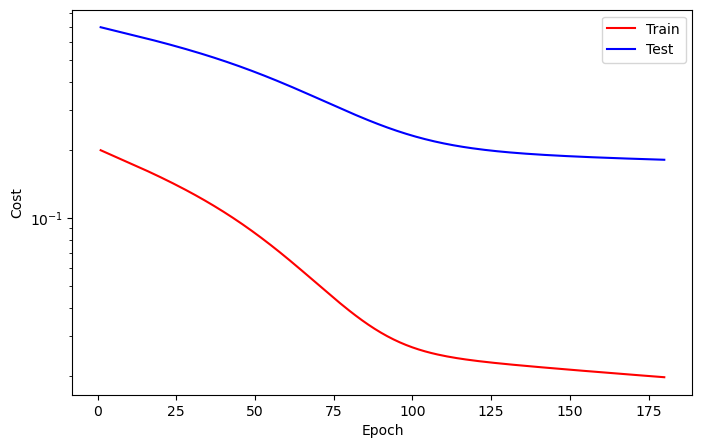

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   181
Train_cost  = 0.0196 | Test_cost  = 0.1801 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   182
Train_cost  = 0.0196 | Test_cost  = 0.1799 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   183
Train_cost  = 0.0195 | Test_cost  = 0.1797 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   184
Train_cost  = 0.0195 | Test_cost  = 0.1796 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   185
Train_cost  = 0.0194 | Test_cost  = 0.1794 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   186
Train_cost  = 0.0194 | Test_cost  = 0.1792 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   187
Train_cost  = 0.0193 | Test_cost  = 0.1791 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   188
Train_cost  = 0.0193 | Test_cost  = 0.1789 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   189
Train_cost  = 0.0192 | Test_cost  = 0.1787 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   190
Train_cost  = 0.0192 | Test_cost  = 0.1786 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   191
Train_cost  = 0.0192 | Test_cost  = 0.1784 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   192
Train_cost  = 0.0191 | Test_cost  = 0.1782 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   193
Train_cost  = 0.0191 | Test_cost  = 0.1781 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   194
Train_cost  = 0.0190 | Test_cost  = 0.1779 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   195
Train_cost  = 0.0190 | Test_cost  = 0.1778 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   196
Train_cost  = 0.0189 | Test_cost  = 0.1776 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   197
Train_cost  = 0.0189 | Test_cost  = 0.1774 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   198
Train_cost  = 0.0188 | Test_cost  = 0.1773 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   199
Train_cost  = 0.0188 | Test_cost  = 0.1771 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   200
Train_cost  = 0.0187 | Test_cost  = 0.1770 | 


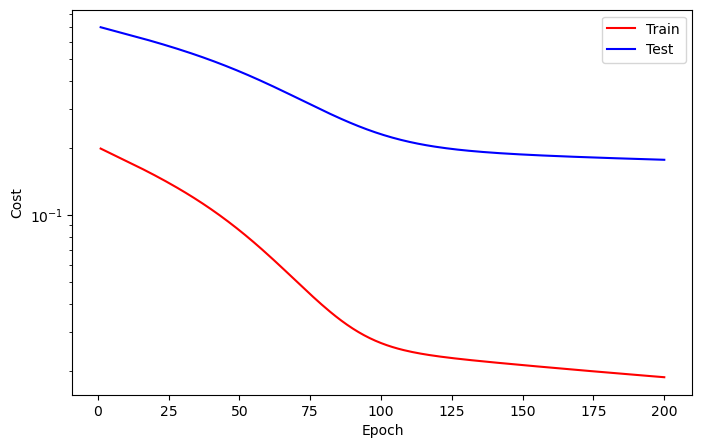

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   201
Train_cost  = 0.0187 | Test_cost  = 0.1768 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   202
Train_cost  = 0.0187 | Test_cost  = 0.1767 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   203
Train_cost  = 0.0186 | Test_cost  = 0.1765 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   204
Train_cost  = 0.0186 | Test_cost  = 0.1763 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   205
Train_cost  = 0.0185 | Test_cost  = 0.1762 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   206
Train_cost  = 0.0185 | Test_cost  = 0.1760 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   207
Train_cost  = 0.0184 | Test_cost  = 0.1759 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   208
Train_cost  = 0.0184 | Test_cost  = 0.1757 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   209
Train_cost  = 0.0184 | Test_cost  = 0.1756 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   210
Train_cost  = 0.0183 | Test_cost  = 0.1754 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   211
Train_cost  = 0.0183 | Test_cost  = 0.1753 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   212
Train_cost  = 0.0182 | Test_cost  = 0.1752 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   213
Train_cost  = 0.0182 | Test_cost  = 0.1750 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   214
Train_cost  = 0.0181 | Test_cost  = 0.1749 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   215
Train_cost  = 0.0181 | Test_cost  = 0.1747 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   216
Train_cost  = 0.0181 | Test_cost  = 0.1746 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   217
Train_cost  = 0.0180 | Test_cost  = 0.1744 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   218
Train_cost  = 0.0180 | Test_cost  = 0.1743 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   219
Train_cost  = 0.0179 | Test_cost  = 0.1741 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   220
Train_cost  = 0.0179 | Test_cost  = 0.1740 | 


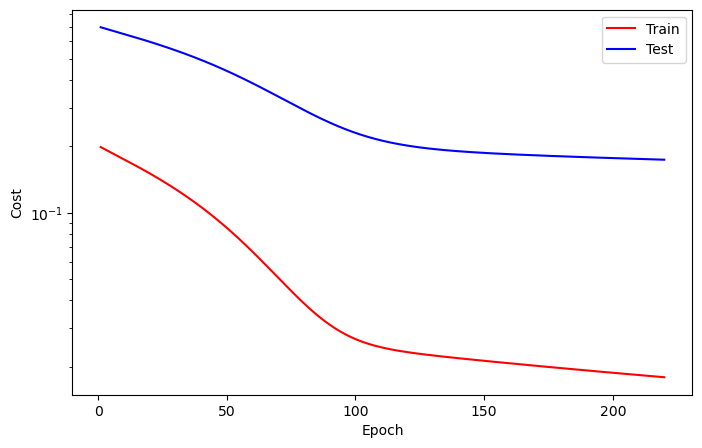

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   221
Train_cost  = 0.0179 | Test_cost  = 0.1739 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   222
Train_cost  = 0.0178 | Test_cost  = 0.1737 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   223
Train_cost  = 0.0178 | Test_cost  = 0.1736 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   224
Train_cost  = 0.0177 | Test_cost  = 0.1734 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   225
Train_cost  = 0.0177 | Test_cost  = 0.1733 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   226
Train_cost  = 0.0177 | Test_cost  = 0.1731 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   227
Train_cost  = 0.0176 | Test_cost  = 0.1730 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   228
Train_cost  = 0.0176 | Test_cost  = 0.1729 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   229
Train_cost  = 0.0175 | Test_cost  = 0.1727 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   230
Train_cost  = 0.0175 | Test_cost  = 0.1726 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   231
Train_cost  = 0.0175 | Test_cost  = 0.1725 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   232
Train_cost  = 0.0174 | Test_cost  = 0.1723 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   233
Train_cost  = 0.0174 | Test_cost  = 0.1722 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   234
Train_cost  = 0.0173 | Test_cost  = 0.1720 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   235
Train_cost  = 0.0173 | Test_cost  = 0.1719 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   236
Train_cost  = 0.0173 | Test_cost  = 0.1718 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   237
Train_cost  = 0.0172 | Test_cost  = 0.1716 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   238
Train_cost  = 0.0172 | Test_cost  = 0.1715 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   239
Train_cost  = 0.0172 | Test_cost  = 0.1714 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   240
Train_cost  = 0.0171 | Test_cost  = 0.1712 | 


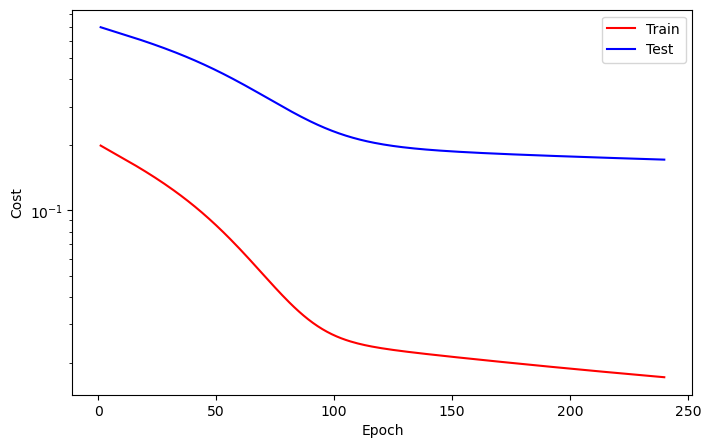

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   241
Train_cost  = 0.0171 | Test_cost  = 0.1711 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   242
Train_cost  = 0.0170 | Test_cost  = 0.1710 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   243
Train_cost  = 0.0170 | Test_cost  = 0.1708 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   244
Train_cost  = 0.0170 | Test_cost  = 0.1707 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   245
Train_cost  = 0.0169 | Test_cost  = 0.1706 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   246
Train_cost  = 0.0169 | Test_cost  = 0.1705 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   247
Train_cost  = 0.0169 | Test_cost  = 0.1703 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   248
Train_cost  = 0.0168 | Test_cost  = 0.1702 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   249
Train_cost  = 0.0168 | Test_cost  = 0.1701 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   250
Train_cost  = 0.0167 | Test_cost  = 0.1699 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   251
Train_cost  = 0.0167 | Test_cost  = 0.1698 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   252
Train_cost  = 0.0167 | Test_cost  = 0.1697 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   253
Train_cost  = 0.0166 | Test_cost  = 0.1695 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   254
Train_cost  = 0.0166 | Test_cost  = 0.1694 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   255
Train_cost  = 0.0166 | Test_cost  = 0.1693 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   256
Train_cost  = 0.0165 | Test_cost  = 0.1692 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   257
Train_cost  = 0.0165 | Test_cost  = 0.1690 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   258
Train_cost  = 0.0165 | Test_cost  = 0.1689 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   259
Train_cost  = 0.0164 | Test_cost  = 0.1688 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   260
Train_cost  = 0.0164 | Test_cost  = 0.1687 | 


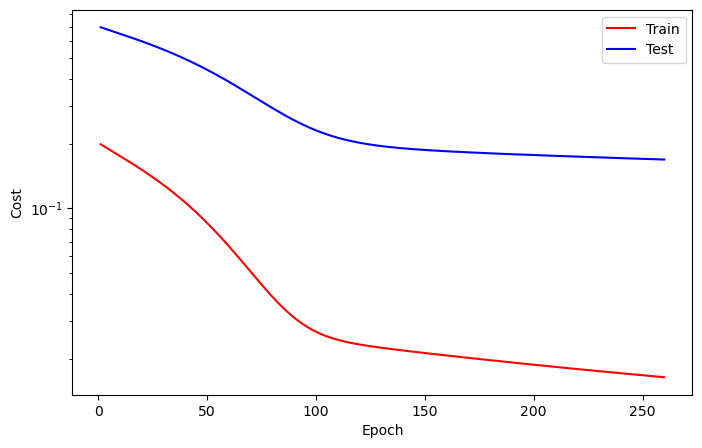

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   261
Train_cost  = 0.0164 | Test_cost  = 0.1685 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   262
Train_cost  = 0.0163 | Test_cost  = 0.1684 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   263
Train_cost  = 0.0163 | Test_cost  = 0.1683 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   264
Train_cost  = 0.0163 | Test_cost  = 0.1682 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   265
Train_cost  = 0.0162 | Test_cost  = 0.1680 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   266
Train_cost  = 0.0162 | Test_cost  = 0.1679 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   267
Train_cost  = 0.0162 | Test_cost  = 0.1678 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   268
Train_cost  = 0.0161 | Test_cost  = 0.1677 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   269
Train_cost  = 0.0161 | Test_cost  = 0.1675 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   270
Train_cost  = 0.0161 | Test_cost  = 0.1674 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   271
Train_cost  = 0.0160 | Test_cost  = 0.1673 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   272
Train_cost  = 0.0160 | Test_cost  = 0.1672 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   273
Train_cost  = 0.0160 | Test_cost  = 0.1670 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   274
Train_cost  = 0.0159 | Test_cost  = 0.1669 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   275
Train_cost  = 0.0159 | Test_cost  = 0.1668 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   276
Train_cost  = 0.0159 | Test_cost  = 0.1667 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   277
Train_cost  = 0.0158 | Test_cost  = 0.1666 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   278
Train_cost  = 0.0158 | Test_cost  = 0.1664 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   279
Train_cost  = 0.0158 | Test_cost  = 0.1663 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   280
Train_cost  = 0.0157 | Test_cost  = 0.1662 | 


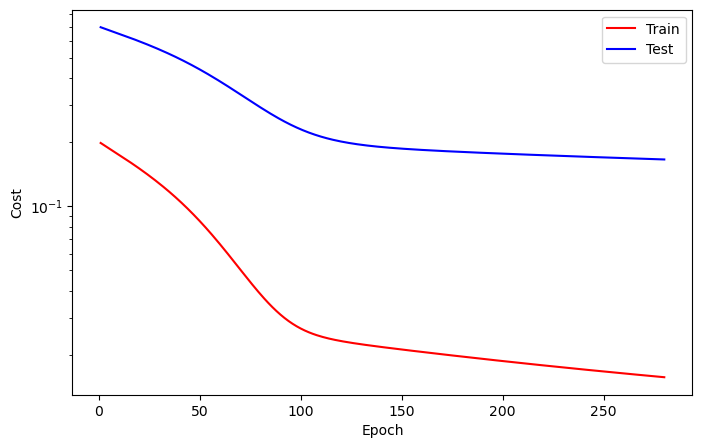

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   281
Train_cost  = 0.0157 | Test_cost  = 0.1661 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   282
Train_cost  = 0.0157 | Test_cost  = 0.1659 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   283
Train_cost  = 0.0156 | Test_cost  = 0.1658 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   284
Train_cost  = 0.0156 | Test_cost  = 0.1657 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   285
Train_cost  = 0.0156 | Test_cost  = 0.1656 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   286
Train_cost  = 0.0156 | Test_cost  = 0.1655 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   287
Train_cost  = 0.0155 | Test_cost  = 0.1653 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   288
Train_cost  = 0.0155 | Test_cost  = 0.1652 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   289
Train_cost  = 0.0155 | Test_cost  = 0.1651 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   290
Train_cost  = 0.0154 | Test_cost  = 0.1650 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   291
Train_cost  = 0.0154 | Test_cost  = 0.1649 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   292
Train_cost  = 0.0154 | Test_cost  = 0.1648 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   293
Train_cost  = 0.0153 | Test_cost  = 0.1646 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   294
Train_cost  = 0.0153 | Test_cost  = 0.1645 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   295
Train_cost  = 0.0153 | Test_cost  = 0.1644 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   296
Train_cost  = 0.0152 | Test_cost  = 0.1643 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   297
Train_cost  = 0.0152 | Test_cost  = 0.1642 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   298
Train_cost  = 0.0152 | Test_cost  = 0.1641 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   299
Train_cost  = 0.0152 | Test_cost  = 0.1639 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   300
Train_cost  = 0.0151 | Test_cost  = 0.1638 | 


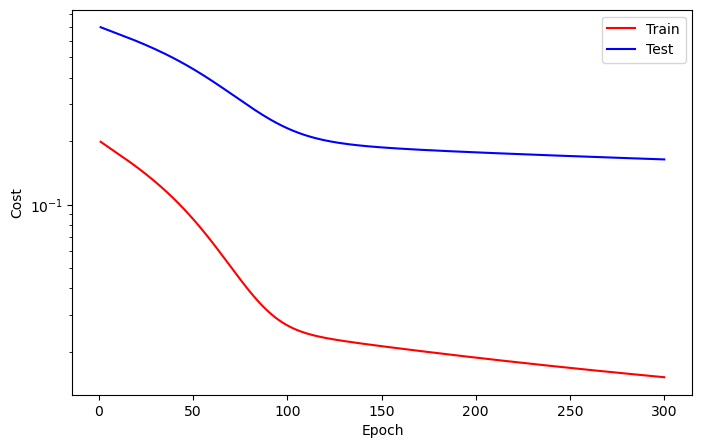

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   301
Train_cost  = 0.0151 | Test_cost  = 0.1637 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   302
Train_cost  = 0.0151 | Test_cost  = 0.1636 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   303
Train_cost  = 0.0150 | Test_cost  = 0.1635 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   304
Train_cost  = 0.0150 | Test_cost  = 0.1634 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   305
Train_cost  = 0.0150 | Test_cost  = 0.1632 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   306
Train_cost  = 0.0150 | Test_cost  = 0.1631 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   307
Train_cost  = 0.0149 | Test_cost  = 0.1630 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   308
Train_cost  = 0.0149 | Test_cost  = 0.1629 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   309
Train_cost  = 0.0149 | Test_cost  = 0.1628 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   310
Train_cost  = 0.0148 | Test_cost  = 0.1627 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   311
Train_cost  = 0.0148 | Test_cost  = 0.1625 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   312
Train_cost  = 0.0148 | Test_cost  = 0.1624 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   313
Train_cost  = 0.0148 | Test_cost  = 0.1623 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   314
Train_cost  = 0.0147 | Test_cost  = 0.1622 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   315
Train_cost  = 0.0147 | Test_cost  = 0.1621 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   316
Train_cost  = 0.0147 | Test_cost  = 0.1620 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   317
Train_cost  = 0.0146 | Test_cost  = 0.1619 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   318
Train_cost  = 0.0146 | Test_cost  = 0.1617 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   319
Train_cost  = 0.0146 | Test_cost  = 0.1616 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   320
Train_cost  = 0.0146 | Test_cost  = 0.1615 | 


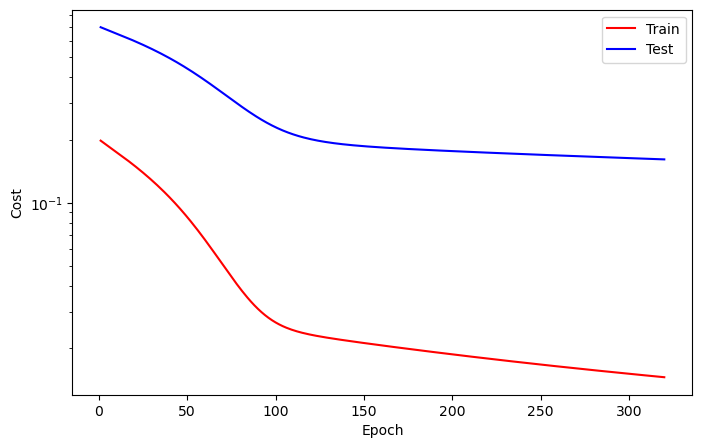

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   321
Train_cost  = 0.0145 | Test_cost  = 0.1614 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   322
Train_cost  = 0.0145 | Test_cost  = 0.1613 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   323
Train_cost  = 0.0145 | Test_cost  = 0.1612 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   324
Train_cost  = 0.0145 | Test_cost  = 0.1611 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   325
Train_cost  = 0.0144 | Test_cost  = 0.1609 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   326
Train_cost  = 0.0144 | Test_cost  = 0.1608 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   327
Train_cost  = 0.0144 | Test_cost  = 0.1607 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   328
Train_cost  = 0.0143 | Test_cost  = 0.1606 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   329
Train_cost  = 0.0143 | Test_cost  = 0.1605 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   330
Train_cost  = 0.0143 | Test_cost  = 0.1604 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   331
Train_cost  = 0.0143 | Test_cost  = 0.1603 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   332
Train_cost  = 0.0142 | Test_cost  = 0.1601 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   333
Train_cost  = 0.0142 | Test_cost  = 0.1600 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   334
Train_cost  = 0.0142 | Test_cost  = 0.1599 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   335
Train_cost  = 0.0142 | Test_cost  = 0.1598 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   336
Train_cost  = 0.0141 | Test_cost  = 0.1597 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   337
Train_cost  = 0.0141 | Test_cost  = 0.1596 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   338
Train_cost  = 0.0141 | Test_cost  = 0.1595 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   339
Train_cost  = 0.0141 | Test_cost  = 0.1593 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   340
Train_cost  = 0.0140 | Test_cost  = 0.1592 | 


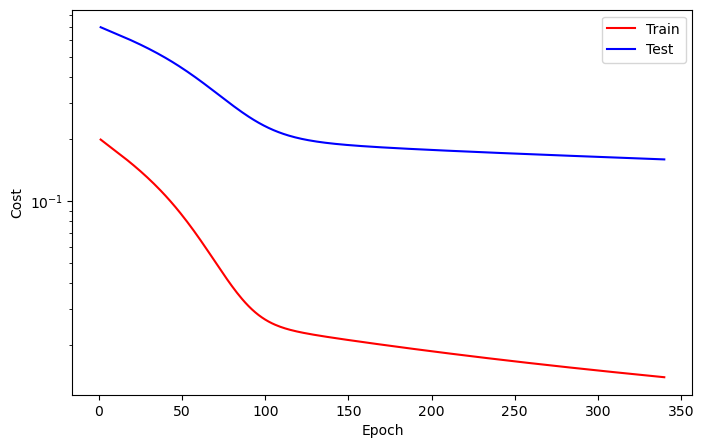

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   341
Train_cost  = 0.0140 | Test_cost  = 0.1591 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   342
Train_cost  = 0.0140 | Test_cost  = 0.1590 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   343
Train_cost  = 0.0140 | Test_cost  = 0.1589 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   344
Train_cost  = 0.0139 | Test_cost  = 0.1588 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   345
Train_cost  = 0.0139 | Test_cost  = 0.1587 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   346
Train_cost  = 0.0139 | Test_cost  = 0.1586 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   347
Train_cost  = 0.0139 | Test_cost  = 0.1584 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   348
Train_cost  = 0.0138 | Test_cost  = 0.1583 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   349
Train_cost  = 0.0138 | Test_cost  = 0.1582 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   350
Train_cost  = 0.0138 | Test_cost  = 0.1581 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   351
Train_cost  = 0.0138 | Test_cost  = 0.1580 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   352
Train_cost  = 0.0137 | Test_cost  = 0.1579 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   353
Train_cost  = 0.0137 | Test_cost  = 0.1578 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   354
Train_cost  = 0.0137 | Test_cost  = 0.1576 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   355
Train_cost  = 0.0137 | Test_cost  = 0.1575 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   356
Train_cost  = 0.0136 | Test_cost  = 0.1574 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   357
Train_cost  = 0.0136 | Test_cost  = 0.1573 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   358
Train_cost  = 0.0136 | Test_cost  = 0.1572 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   359
Train_cost  = 0.0136 | Test_cost  = 0.1571 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   360
Train_cost  = 0.0135 | Test_cost  = 0.1570 | 


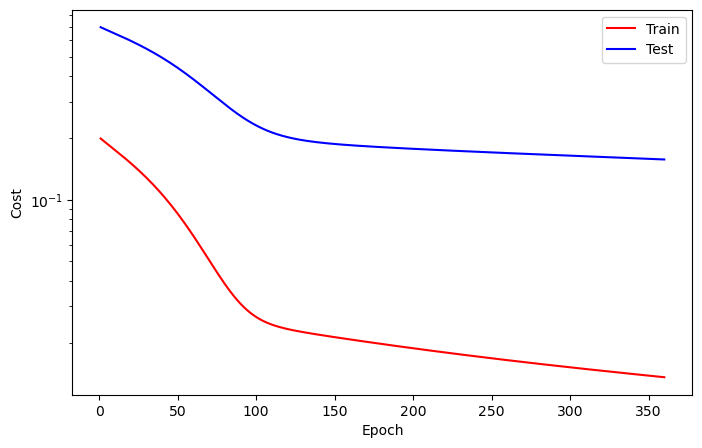

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   361
Train_cost  = 0.0135 | Test_cost  = 0.1569 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   362
Train_cost  = 0.0135 | Test_cost  = 0.1567 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   363
Train_cost  = 0.0135 | Test_cost  = 0.1566 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   364
Train_cost  = 0.0134 | Test_cost  = 0.1565 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   365
Train_cost  = 0.0134 | Test_cost  = 0.1564 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   366
Train_cost  = 0.0134 | Test_cost  = 0.1563 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   367
Train_cost  = 0.0134 | Test_cost  = 0.1562 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   368
Train_cost  = 0.0133 | Test_cost  = 0.1561 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   369
Train_cost  = 0.0133 | Test_cost  = 0.1559 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   370
Train_cost  = 0.0133 | Test_cost  = 0.1558 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   371
Train_cost  = 0.0133 | Test_cost  = 0.1557 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   372
Train_cost  = 0.0132 | Test_cost  = 0.1556 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   373
Train_cost  = 0.0132 | Test_cost  = 0.1555 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   374
Train_cost  = 0.0132 | Test_cost  = 0.1554 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   375
Train_cost  = 0.0132 | Test_cost  = 0.1552 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   376
Train_cost  = 0.0132 | Test_cost  = 0.1551 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   377
Train_cost  = 0.0131 | Test_cost  = 0.1550 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   378
Train_cost  = 0.0131 | Test_cost  = 0.1549 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   379
Train_cost  = 0.0131 | Test_cost  = 0.1548 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   380
Train_cost  = 0.0131 | Test_cost  = 0.1547 | 


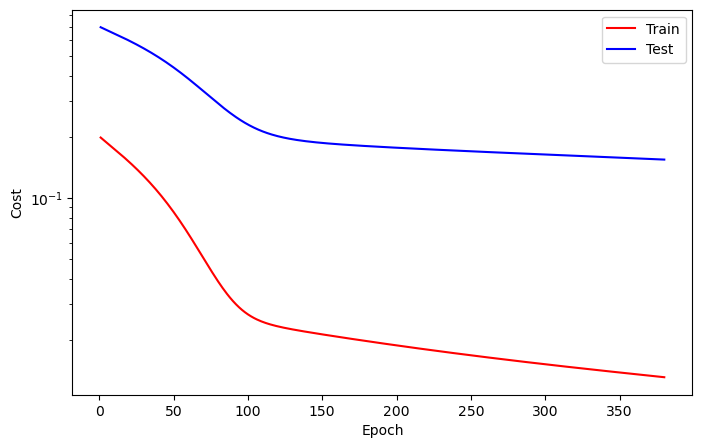

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   381
Train_cost  = 0.0130 | Test_cost  = 0.1545 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   382
Train_cost  = 0.0130 | Test_cost  = 0.1544 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   383
Train_cost  = 0.0130 | Test_cost  = 0.1543 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   384
Train_cost  = 0.0130 | Test_cost  = 0.1542 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   385
Train_cost  = 0.0129 | Test_cost  = 0.1541 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   386
Train_cost  = 0.0129 | Test_cost  = 0.1540 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   387
Train_cost  = 0.0129 | Test_cost  = 0.1538 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   388
Train_cost  = 0.0129 | Test_cost  = 0.1537 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   389
Train_cost  = 0.0129 | Test_cost  = 0.1536 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   390
Train_cost  = 0.0128 | Test_cost  = 0.1535 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   391
Train_cost  = 0.0128 | Test_cost  = 0.1534 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   392
Train_cost  = 0.0128 | Test_cost  = 0.1533 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   393
Train_cost  = 0.0128 | Test_cost  = 0.1531 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   394
Train_cost  = 0.0127 | Test_cost  = 0.1530 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   395
Train_cost  = 0.0127 | Test_cost  = 0.1529 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   396
Train_cost  = 0.0127 | Test_cost  = 0.1528 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   397
Train_cost  = 0.0127 | Test_cost  = 0.1527 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   398
Train_cost  = 0.0127 | Test_cost  = 0.1525 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   399
Train_cost  = 0.0126 | Test_cost  = 0.1524 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   400
Train_cost  = 0.0126 | Test_cost  = 0.1523 | 


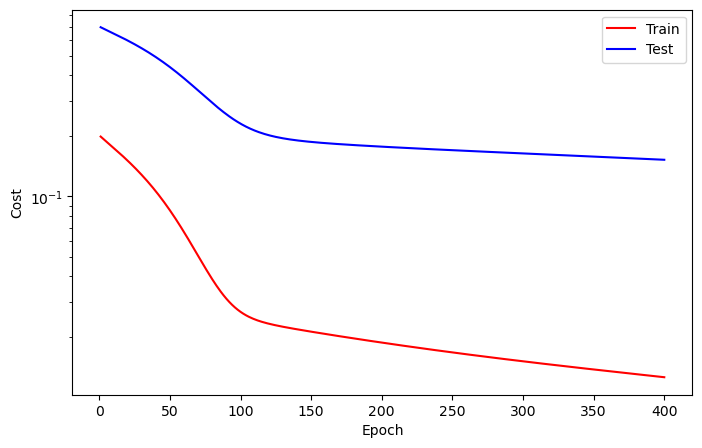

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   401
Train_cost  = 0.0126 | Test_cost  = 0.1522 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   402
Train_cost  = 0.0126 | Test_cost  = 0.1520 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   403
Train_cost  = 0.0125 | Test_cost  = 0.1519 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   404
Train_cost  = 0.0125 | Test_cost  = 0.1518 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   405
Train_cost  = 0.0125 | Test_cost  = 0.1517 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   406
Train_cost  = 0.0125 | Test_cost  = 0.1516 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   407
Train_cost  = 0.0125 | Test_cost  = 0.1514 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   408
Train_cost  = 0.0124 | Test_cost  = 0.1513 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   409
Train_cost  = 0.0124 | Test_cost  = 0.1512 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   410
Train_cost  = 0.0124 | Test_cost  = 0.1511 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   411
Train_cost  = 0.0124 | Test_cost  = 0.1509 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   412
Train_cost  = 0.0123 | Test_cost  = 0.1508 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   413
Train_cost  = 0.0123 | Test_cost  = 0.1507 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   414
Train_cost  = 0.0123 | Test_cost  = 0.1506 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   415
Train_cost  = 0.0123 | Test_cost  = 0.1504 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   416
Train_cost  = 0.0123 | Test_cost  = 0.1503 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   417
Train_cost  = 0.0122 | Test_cost  = 0.1502 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   418
Train_cost  = 0.0122 | Test_cost  = 0.1501 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   419
Train_cost  = 0.0122 | Test_cost  = 0.1499 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   420
Train_cost  = 0.0122 | Test_cost  = 0.1498 | 


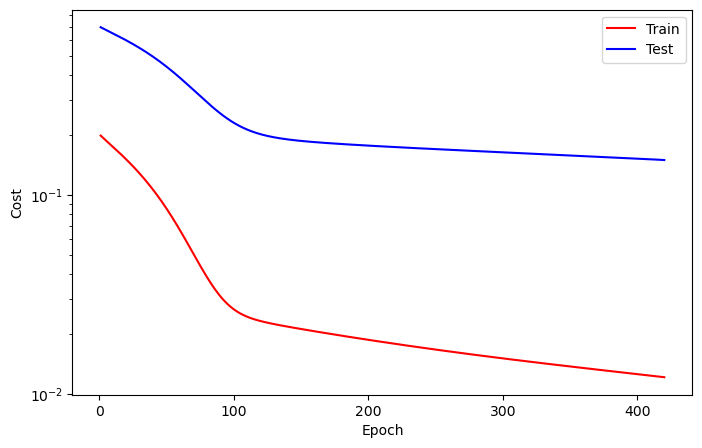

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   421
Train_cost  = 0.0121 | Test_cost  = 0.1497 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   422
Train_cost  = 0.0121 | Test_cost  = 0.1495 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   423
Train_cost  = 0.0121 | Test_cost  = 0.1494 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   424
Train_cost  = 0.0121 | Test_cost  = 0.1493 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   425
Train_cost  = 0.0121 | Test_cost  = 0.1492 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   426
Train_cost  = 0.0120 | Test_cost  = 0.1490 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   427
Train_cost  = 0.0120 | Test_cost  = 0.1489 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   428
Train_cost  = 0.0120 | Test_cost  = 0.1488 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   429
Train_cost  = 0.0120 | Test_cost  = 0.1486 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   430
Train_cost  = 0.0120 | Test_cost  = 0.1485 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   431
Train_cost  = 0.0119 | Test_cost  = 0.1484 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   432
Train_cost  = 0.0119 | Test_cost  = 0.1482 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   433
Train_cost  = 0.0119 | Test_cost  = 0.1481 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   434
Train_cost  = 0.0119 | Test_cost  = 0.1480 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   435
Train_cost  = 0.0118 | Test_cost  = 0.1478 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   436
Train_cost  = 0.0118 | Test_cost  = 0.1477 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   437
Train_cost  = 0.0118 | Test_cost  = 0.1475 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   438
Train_cost  = 0.0118 | Test_cost  = 0.1474 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   439
Train_cost  = 0.0118 | Test_cost  = 0.1473 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   440
Train_cost  = 0.0117 | Test_cost  = 0.1471 | 


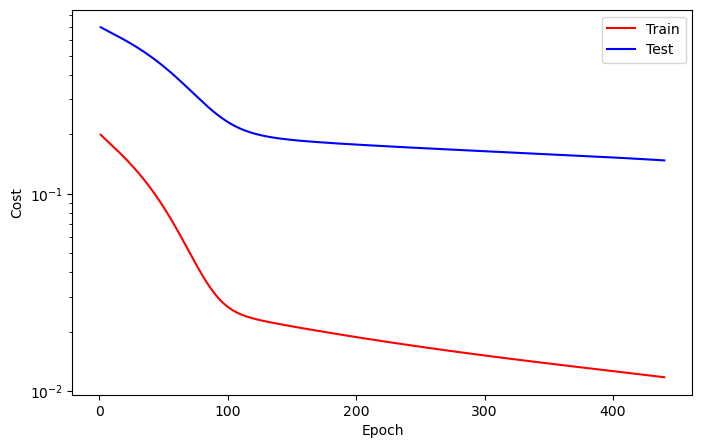

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   441
Train_cost  = 0.0117 | Test_cost  = 0.1470 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   442
Train_cost  = 0.0117 | Test_cost  = 0.1469 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   443
Train_cost  = 0.0117 | Test_cost  = 0.1467 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   444
Train_cost  = 0.0117 | Test_cost  = 0.1466 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   445
Train_cost  = 0.0116 | Test_cost  = 0.1464 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   446
Train_cost  = 0.0116 | Test_cost  = 0.1463 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   447
Train_cost  = 0.0116 | Test_cost  = 0.1461 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   448
Train_cost  = 0.0116 | Test_cost  = 0.1460 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   449
Train_cost  = 0.0115 | Test_cost  = 0.1459 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   450
Train_cost  = 0.0115 | Test_cost  = 0.1457 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   451
Train_cost  = 0.0115 | Test_cost  = 0.1456 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   452
Train_cost  = 0.0115 | Test_cost  = 0.1454 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   453
Train_cost  = 0.0115 | Test_cost  = 0.1453 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   454
Train_cost  = 0.0114 | Test_cost  = 0.1451 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   455
Train_cost  = 0.0114 | Test_cost  = 0.1450 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   456
Train_cost  = 0.0114 | Test_cost  = 0.1448 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   457
Train_cost  = 0.0114 | Test_cost  = 0.1447 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   458
Train_cost  = 0.0114 | Test_cost  = 0.1445 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   459
Train_cost  = 0.0113 | Test_cost  = 0.1444 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   460
Train_cost  = 0.0113 | Test_cost  = 0.1442 | 


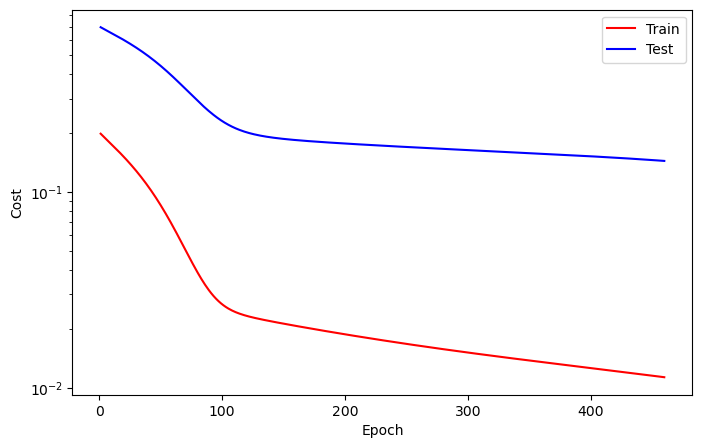

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   461
Train_cost  = 0.0113 | Test_cost  = 0.1441 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   462
Train_cost  = 0.0113 | Test_cost  = 0.1439 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   463
Train_cost  = 0.0113 | Test_cost  = 0.1438 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   464
Train_cost  = 0.0112 | Test_cost  = 0.1436 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   465
Train_cost  = 0.0112 | Test_cost  = 0.1434 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   466
Train_cost  = 0.0112 | Test_cost  = 0.1433 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   467
Train_cost  = 0.0112 | Test_cost  = 0.1431 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   468
Train_cost  = 0.0111 | Test_cost  = 0.1430 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   469
Train_cost  = 0.0111 | Test_cost  = 0.1428 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   470
Train_cost  = 0.0111 | Test_cost  = 0.1426 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   471
Train_cost  = 0.0111 | Test_cost  = 0.1425 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   472
Train_cost  = 0.0111 | Test_cost  = 0.1423 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   473
Train_cost  = 0.0110 | Test_cost  = 0.1421 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   474
Train_cost  = 0.0110 | Test_cost  = 0.1420 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   475
Train_cost  = 0.0110 | Test_cost  = 0.1418 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   476
Train_cost  = 0.0110 | Test_cost  = 0.1416 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   477
Train_cost  = 0.0110 | Test_cost  = 0.1415 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   478
Train_cost  = 0.0109 | Test_cost  = 0.1413 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   479
Train_cost  = 0.0109 | Test_cost  = 0.1411 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   480
Train_cost  = 0.0109 | Test_cost  = 0.1410 | 


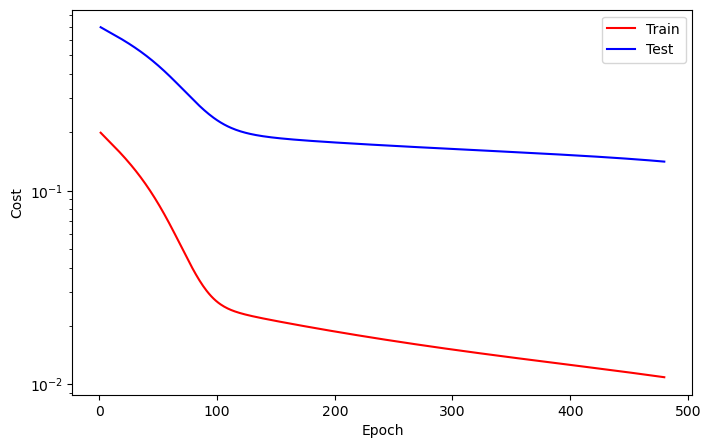

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   481
Train_cost  = 0.0109 | Test_cost  = 0.1408 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   482
Train_cost  = 0.0108 | Test_cost  = 0.1406 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   483
Train_cost  = 0.0108 | Test_cost  = 0.1404 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   484
Train_cost  = 0.0108 | Test_cost  = 0.1403 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   485
Train_cost  = 0.0108 | Test_cost  = 0.1401 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   486
Train_cost  = 0.0108 | Test_cost  = 0.1399 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   487
Train_cost  = 0.0107 | Test_cost  = 0.1397 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   488
Train_cost  = 0.0107 | Test_cost  = 0.1395 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   489
Train_cost  = 0.0107 | Test_cost  = 0.1394 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   490
Train_cost  = 0.0107 | Test_cost  = 0.1392 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   491
Train_cost  = 0.0107 | Test_cost  = 0.1390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   492
Train_cost  = 0.0106 | Test_cost  = 0.1388 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   493
Train_cost  = 0.0106 | Test_cost  = 0.1386 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   494
Train_cost  = 0.0106 | Test_cost  = 0.1384 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   495
Train_cost  = 0.0106 | Test_cost  = 0.1382 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   496
Train_cost  = 0.0105 | Test_cost  = 0.1380 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   497
Train_cost  = 0.0105 | Test_cost  = 0.1378 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   498
Train_cost  = 0.0105 | Test_cost  = 0.1376 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   499
Train_cost  = 0.0105 | Test_cost  = 0.1375 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   500
Train_cost  = 0.0105 | Test_cost  = 0.1373 | 


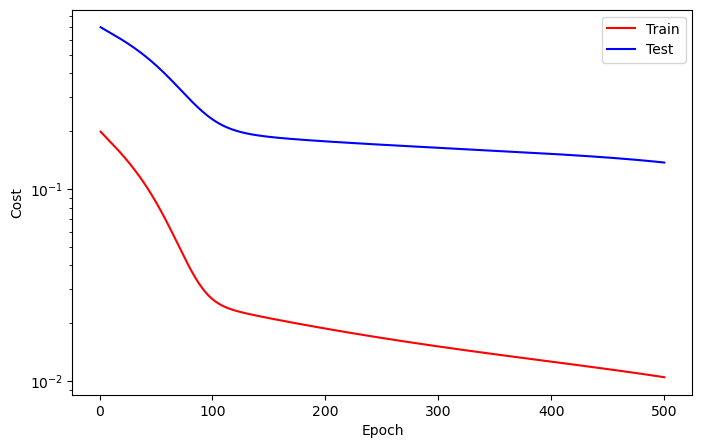

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   501
Train_cost  = 0.0104 | Test_cost  = 0.1371 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   502
Train_cost  = 0.0104 | Test_cost  = 0.1369 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   503
Train_cost  = 0.0104 | Test_cost  = 0.1366 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   504
Train_cost  = 0.0104 | Test_cost  = 0.1364 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   505
Train_cost  = 0.0104 | Test_cost  = 0.1362 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   506
Train_cost  = 0.0103 | Test_cost  = 0.1360 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   507
Train_cost  = 0.0103 | Test_cost  = 0.1358 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   508
Train_cost  = 0.0103 | Test_cost  = 0.1356 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   509
Train_cost  = 0.0103 | Test_cost  = 0.1354 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   510
Train_cost  = 0.0102 | Test_cost  = 0.1352 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   511
Train_cost  = 0.0102 | Test_cost  = 0.1350 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   512
Train_cost  = 0.0102 | Test_cost  = 0.1347 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   513
Train_cost  = 0.0102 | Test_cost  = 0.1345 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   514
Train_cost  = 0.0102 | Test_cost  = 0.1343 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   515
Train_cost  = 0.0101 | Test_cost  = 0.1341 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   516
Train_cost  = 0.0101 | Test_cost  = 0.1339 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   517
Train_cost  = 0.0101 | Test_cost  = 0.1336 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   518
Train_cost  = 0.0101 | Test_cost  = 0.1334 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   519
Train_cost  = 0.0100 | Test_cost  = 0.1332 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   520
Train_cost  = 0.0100 | Test_cost  = 0.1329 | 


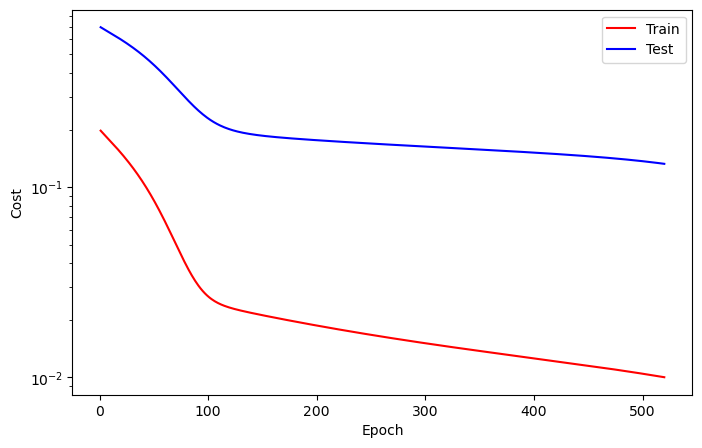

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   521
Train_cost  = 0.0100 | Test_cost  = 0.1327 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   522
Train_cost  = 0.0100 | Test_cost  = 0.1325 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   523
Train_cost  = 0.0100 | Test_cost  = 0.1322 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   524
Train_cost  = 0.0099 | Test_cost  = 0.1320 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   525
Train_cost  = 0.0099 | Test_cost  = 0.1317 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   526
Train_cost  = 0.0099 | Test_cost  = 0.1315 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   527
Train_cost  = 0.0099 | Test_cost  = 0.1313 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   528
Train_cost  = 0.0098 | Test_cost  = 0.1310 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   529
Train_cost  = 0.0098 | Test_cost  = 0.1308 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   530
Train_cost  = 0.0098 | Test_cost  = 0.1305 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   531
Train_cost  = 0.0098 | Test_cost  = 0.1303 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   532
Train_cost  = 0.0098 | Test_cost  = 0.1300 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   533
Train_cost  = 0.0097 | Test_cost  = 0.1297 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   534
Train_cost  = 0.0097 | Test_cost  = 0.1295 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   535
Train_cost  = 0.0097 | Test_cost  = 0.1292 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   536
Train_cost  = 0.0097 | Test_cost  = 0.1289 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   537
Train_cost  = 0.0097 | Test_cost  = 0.1287 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   538
Train_cost  = 0.0096 | Test_cost  = 0.1284 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   539
Train_cost  = 0.0096 | Test_cost  = 0.1281 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   540
Train_cost  = 0.0096 | Test_cost  = 0.1279 | 


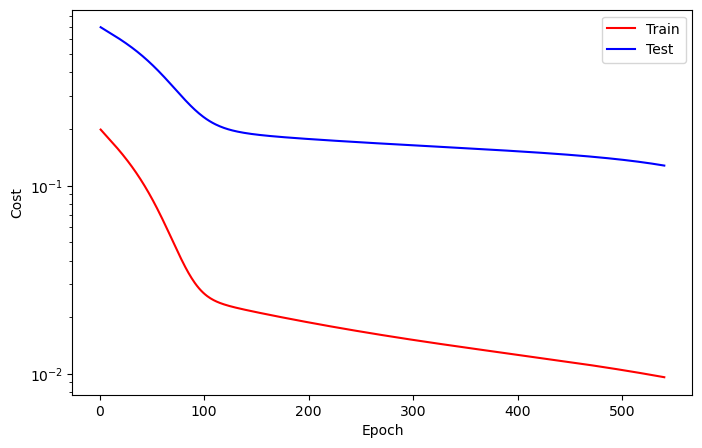

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   541
Train_cost  = 0.0096 | Test_cost  = 0.1276 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   542
Train_cost  = 0.0095 | Test_cost  = 0.1273 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   543
Train_cost  = 0.0095 | Test_cost  = 0.1270 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   544
Train_cost  = 0.0095 | Test_cost  = 0.1267 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   545
Train_cost  = 0.0095 | Test_cost  = 0.1264 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   546
Train_cost  = 0.0095 | Test_cost  = 0.1262 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   547
Train_cost  = 0.0094 | Test_cost  = 0.1259 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   548
Train_cost  = 0.0094 | Test_cost  = 0.1256 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   549
Train_cost  = 0.0094 | Test_cost  = 0.1253 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   550
Train_cost  = 0.0094 | Test_cost  = 0.1250 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   551
Train_cost  = 0.0093 | Test_cost  = 0.1247 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   552
Train_cost  = 0.0093 | Test_cost  = 0.1244 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   553
Train_cost  = 0.0093 | Test_cost  = 0.1241 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   554
Train_cost  = 0.0093 | Test_cost  = 0.1238 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   555
Train_cost  = 0.0093 | Test_cost  = 0.1234 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   556
Train_cost  = 0.0092 | Test_cost  = 0.1231 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   557
Train_cost  = 0.0092 | Test_cost  = 0.1228 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   558
Train_cost  = 0.0092 | Test_cost  = 0.1225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   559
Train_cost  = 0.0092 | Test_cost  = 0.1222 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   560
Train_cost  = 0.0091 | Test_cost  = 0.1218 | 


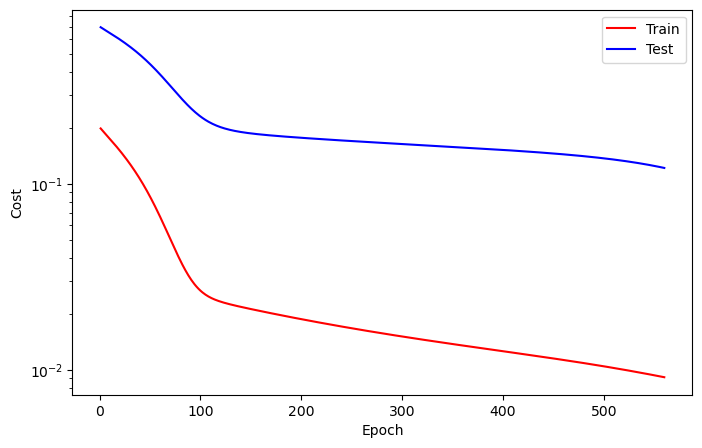

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   561
Train_cost  = 0.0091 | Test_cost  = 0.1215 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   562
Train_cost  = 0.0091 | Test_cost  = 0.1212 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   563
Train_cost  = 0.0091 | Test_cost  = 0.1209 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   564
Train_cost  = 0.0090 | Test_cost  = 0.1205 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   565
Train_cost  = 0.0090 | Test_cost  = 0.1202 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   566
Train_cost  = 0.0090 | Test_cost  = 0.1198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   567
Train_cost  = 0.0090 | Test_cost  = 0.1195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   568
Train_cost  = 0.0090 | Test_cost  = 0.1192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   569
Train_cost  = 0.0089 | Test_cost  = 0.1188 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   570
Train_cost  = 0.0089 | Test_cost  = 0.1185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   571
Train_cost  = 0.0089 | Test_cost  = 0.1181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   572
Train_cost  = 0.0089 | Test_cost  = 0.1177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   573
Train_cost  = 0.0088 | Test_cost  = 0.1174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   574
Train_cost  = 0.0088 | Test_cost  = 0.1170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   575
Train_cost  = 0.0088 | Test_cost  = 0.1167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   576
Train_cost  = 0.0088 | Test_cost  = 0.1163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   577
Train_cost  = 0.0088 | Test_cost  = 0.1159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   578
Train_cost  = 0.0087 | Test_cost  = 0.1156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   579
Train_cost  = 0.0087 | Test_cost  = 0.1152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   580
Train_cost  = 0.0087 | Test_cost  = 0.1148 | 


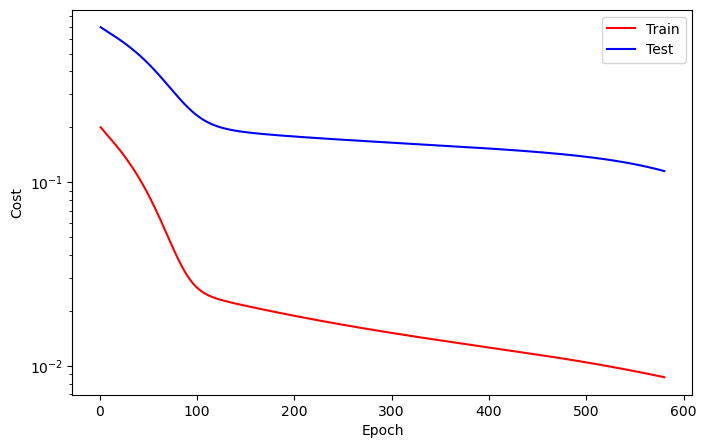

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   581
Train_cost  = 0.0087 | Test_cost  = 0.1144 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   582
Train_cost  = 0.0086 | Test_cost  = 0.1140 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   583
Train_cost  = 0.0086 | Test_cost  = 0.1137 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   584
Train_cost  = 0.0086 | Test_cost  = 0.1133 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   585
Train_cost  = 0.0086 | Test_cost  = 0.1129 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   586
Train_cost  = 0.0086 | Test_cost  = 0.1125 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   587
Train_cost  = 0.0085 | Test_cost  = 0.1121 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   588
Train_cost  = 0.0085 | Test_cost  = 0.1117 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   589
Train_cost  = 0.0085 | Test_cost  = 0.1113 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   590
Train_cost  = 0.0085 | Test_cost  = 0.1109 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   591
Train_cost  = 0.0084 | Test_cost  = 0.1105 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   592
Train_cost  = 0.0084 | Test_cost  = 0.1101 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   593
Train_cost  = 0.0084 | Test_cost  = 0.1097 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   594
Train_cost  = 0.0084 | Test_cost  = 0.1092 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   595
Train_cost  = 0.0083 | Test_cost  = 0.1088 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   596
Train_cost  = 0.0083 | Test_cost  = 0.1084 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   597
Train_cost  = 0.0083 | Test_cost  = 0.1080 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   598
Train_cost  = 0.0083 | Test_cost  = 0.1076 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   599
Train_cost  = 0.0083 | Test_cost  = 0.1071 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   600
Train_cost  = 0.0082 | Test_cost  = 0.1067 | 


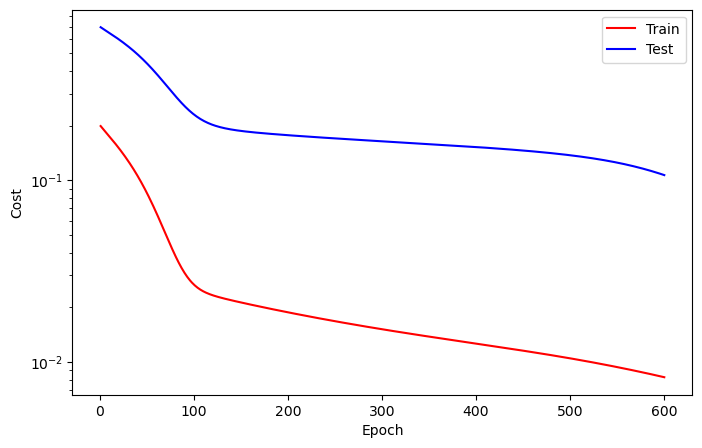

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   601
Train_cost  = 0.0082 | Test_cost  = 0.1063 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   602
Train_cost  = 0.0082 | Test_cost  = 0.1059 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   603
Train_cost  = 0.0082 | Test_cost  = 0.1054 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   604
Train_cost  = 0.0081 | Test_cost  = 0.1050 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   605
Train_cost  = 0.0081 | Test_cost  = 0.1045 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   606
Train_cost  = 0.0081 | Test_cost  = 0.1041 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   607
Train_cost  = 0.0081 | Test_cost  = 0.1037 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   608
Train_cost  = 0.0081 | Test_cost  = 0.1032 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   609
Train_cost  = 0.0080 | Test_cost  = 0.1028 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   610
Train_cost  = 0.0080 | Test_cost  = 0.1023 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   611
Train_cost  = 0.0080 | Test_cost  = 0.1019 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   612
Train_cost  = 0.0080 | Test_cost  = 0.1014 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   613
Train_cost  = 0.0079 | Test_cost  = 0.1010 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   614
Train_cost  = 0.0079 | Test_cost  = 0.1005 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   615
Train_cost  = 0.0079 | Test_cost  = 0.1000 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   616
Train_cost  = 0.0079 | Test_cost  = 0.0996 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   617
Train_cost  = 0.0078 | Test_cost  = 0.0991 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   618
Train_cost  = 0.0078 | Test_cost  = 0.0987 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   619
Train_cost  = 0.0078 | Test_cost  = 0.0982 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   620
Train_cost  = 0.0078 | Test_cost  = 0.0977 | 


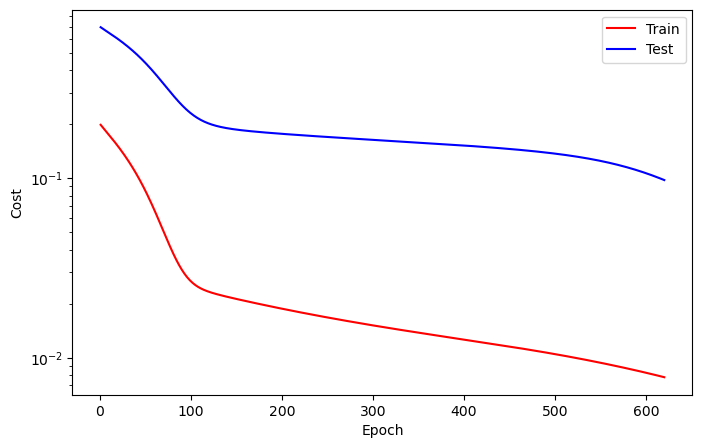

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   621
Train_cost  = 0.0078 | Test_cost  = 0.0973 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   622
Train_cost  = 0.0077 | Test_cost  = 0.0968 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   623
Train_cost  = 0.0077 | Test_cost  = 0.0963 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   624
Train_cost  = 0.0077 | Test_cost  = 0.0959 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   625
Train_cost  = 0.0077 | Test_cost  = 0.0954 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   626
Train_cost  = 0.0076 | Test_cost  = 0.0949 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   627
Train_cost  = 0.0076 | Test_cost  = 0.0944 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   628
Train_cost  = 0.0076 | Test_cost  = 0.0940 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   629
Train_cost  = 0.0076 | Test_cost  = 0.0935 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   630
Train_cost  = 0.0075 | Test_cost  = 0.0930 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   631
Train_cost  = 0.0075 | Test_cost  = 0.0925 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   632
Train_cost  = 0.0075 | Test_cost  = 0.0920 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   633
Train_cost  = 0.0075 | Test_cost  = 0.0916 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   634
Train_cost  = 0.0075 | Test_cost  = 0.0911 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   635
Train_cost  = 0.0074 | Test_cost  = 0.0906 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   636
Train_cost  = 0.0074 | Test_cost  = 0.0901 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   637
Train_cost  = 0.0074 | Test_cost  = 0.0896 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   638
Train_cost  = 0.0074 | Test_cost  = 0.0892 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   639
Train_cost  = 0.0073 | Test_cost  = 0.0887 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   640
Train_cost  = 0.0073 | Test_cost  = 0.0882 | 


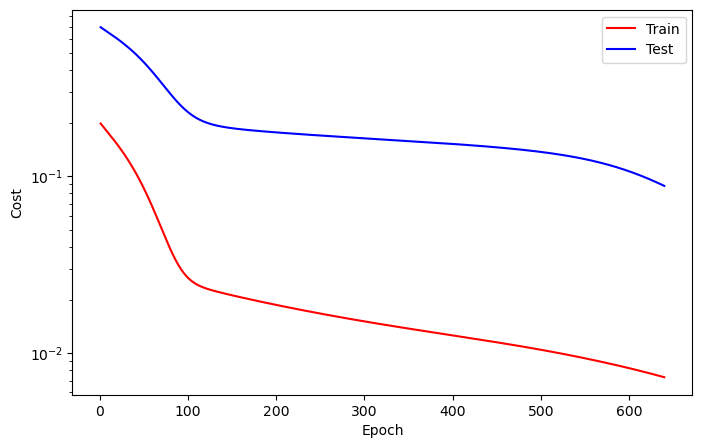

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   641
Train_cost  = 0.0073 | Test_cost  = 0.0877 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   642
Train_cost  = 0.0073 | Test_cost  = 0.0872 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   643
Train_cost  = 0.0072 | Test_cost  = 0.0867 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   644
Train_cost  = 0.0072 | Test_cost  = 0.0863 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   645
Train_cost  = 0.0072 | Test_cost  = 0.0858 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   646
Train_cost  = 0.0072 | Test_cost  = 0.0853 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   647
Train_cost  = 0.0072 | Test_cost  = 0.0848 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   648
Train_cost  = 0.0071 | Test_cost  = 0.0843 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   649
Train_cost  = 0.0071 | Test_cost  = 0.0838 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   650
Train_cost  = 0.0071 | Test_cost  = 0.0834 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   651
Train_cost  = 0.0071 | Test_cost  = 0.0829 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   652
Train_cost  = 0.0070 | Test_cost  = 0.0824 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   653
Train_cost  = 0.0070 | Test_cost  = 0.0819 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   654
Train_cost  = 0.0070 | Test_cost  = 0.0814 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   655
Train_cost  = 0.0070 | Test_cost  = 0.0810 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   656
Train_cost  = 0.0069 | Test_cost  = 0.0805 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   657
Train_cost  = 0.0069 | Test_cost  = 0.0800 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   658
Train_cost  = 0.0069 | Test_cost  = 0.0795 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   659
Train_cost  = 0.0069 | Test_cost  = 0.0791 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   660
Train_cost  = 0.0069 | Test_cost  = 0.0786 | 


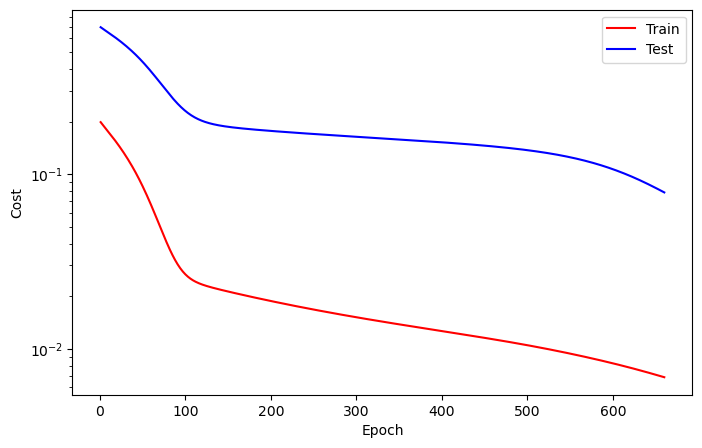

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   661
Train_cost  = 0.0068 | Test_cost  = 0.0781 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   662
Train_cost  = 0.0068 | Test_cost  = 0.0777 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   663
Train_cost  = 0.0068 | Test_cost  = 0.0772 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   664
Train_cost  = 0.0068 | Test_cost  = 0.0767 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   665
Train_cost  = 0.0067 | Test_cost  = 0.0763 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   666
Train_cost  = 0.0067 | Test_cost  = 0.0758 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   667
Train_cost  = 0.0067 | Test_cost  = 0.0753 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   668
Train_cost  = 0.0067 | Test_cost  = 0.0749 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   669
Train_cost  = 0.0067 | Test_cost  = 0.0744 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   670
Train_cost  = 0.0066 | Test_cost  = 0.0740 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   671
Train_cost  = 0.0066 | Test_cost  = 0.0735 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   672
Train_cost  = 0.0066 | Test_cost  = 0.0731 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   673
Train_cost  = 0.0066 | Test_cost  = 0.0726 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   674
Train_cost  = 0.0065 | Test_cost  = 0.0722 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   675
Train_cost  = 0.0065 | Test_cost  = 0.0717 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   676
Train_cost  = 0.0065 | Test_cost  = 0.0713 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   677
Train_cost  = 0.0065 | Test_cost  = 0.0709 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   678
Train_cost  = 0.0065 | Test_cost  = 0.0704 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   679
Train_cost  = 0.0064 | Test_cost  = 0.0700 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   680
Train_cost  = 0.0064 | Test_cost  = 0.0696 | 


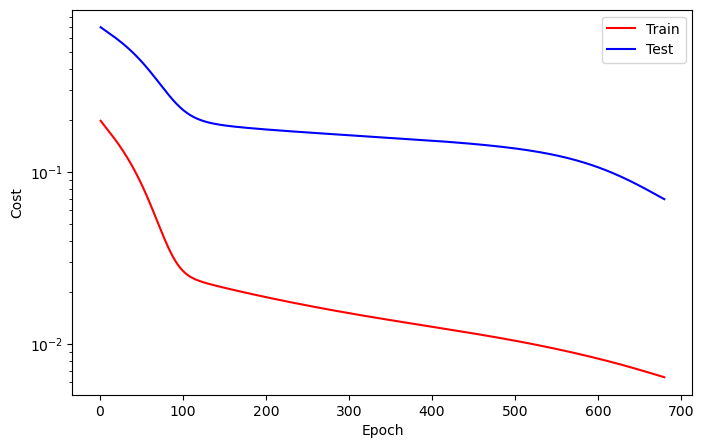

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   681
Train_cost  = 0.0064 | Test_cost  = 0.0691 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   682
Train_cost  = 0.0064 | Test_cost  = 0.0687 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   683
Train_cost  = 0.0063 | Test_cost  = 0.0683 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   684
Train_cost  = 0.0063 | Test_cost  = 0.0679 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   685
Train_cost  = 0.0063 | Test_cost  = 0.0675 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   686
Train_cost  = 0.0063 | Test_cost  = 0.0671 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   687
Train_cost  = 0.0063 | Test_cost  = 0.0667 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   688
Train_cost  = 0.0062 | Test_cost  = 0.0663 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   689
Train_cost  = 0.0062 | Test_cost  = 0.0659 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   690
Train_cost  = 0.0062 | Test_cost  = 0.0655 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   691
Train_cost  = 0.0062 | Test_cost  = 0.0651 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   692
Train_cost  = 0.0062 | Test_cost  = 0.0647 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   693
Train_cost  = 0.0061 | Test_cost  = 0.0643 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   694
Train_cost  = 0.0061 | Test_cost  = 0.0639 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   695
Train_cost  = 0.0061 | Test_cost  = 0.0635 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   696
Train_cost  = 0.0061 | Test_cost  = 0.0632 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   697
Train_cost  = 0.0061 | Test_cost  = 0.0628 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   698
Train_cost  = 0.0060 | Test_cost  = 0.0624 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   699
Train_cost  = 0.0060 | Test_cost  = 0.0620 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   700
Train_cost  = 0.0060 | Test_cost  = 0.0617 | 


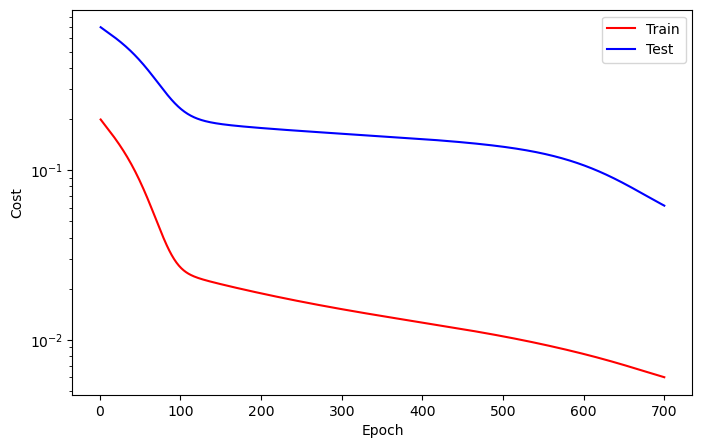

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   701
Train_cost  = 0.0060 | Test_cost  = 0.0613 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   702
Train_cost  = 0.0060 | Test_cost  = 0.0610 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   703
Train_cost  = 0.0059 | Test_cost  = 0.0606 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   704
Train_cost  = 0.0059 | Test_cost  = 0.0603 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   705
Train_cost  = 0.0059 | Test_cost  = 0.0599 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   706
Train_cost  = 0.0059 | Test_cost  = 0.0596 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   707
Train_cost  = 0.0059 | Test_cost  = 0.0593 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   708
Train_cost  = 0.0059 | Test_cost  = 0.0589 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   709
Train_cost  = 0.0058 | Test_cost  = 0.0586 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   710
Train_cost  = 0.0058 | Test_cost  = 0.0583 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   711
Train_cost  = 0.0058 | Test_cost  = 0.0580 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   712
Train_cost  = 0.0058 | Test_cost  = 0.0577 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   713
Train_cost  = 0.0058 | Test_cost  = 0.0574 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   714
Train_cost  = 0.0058 | Test_cost  = 0.0571 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   715
Train_cost  = 0.0057 | Test_cost  = 0.0568 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   716
Train_cost  = 0.0057 | Test_cost  = 0.0565 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   717
Train_cost  = 0.0057 | Test_cost  = 0.0562 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   718
Train_cost  = 0.0057 | Test_cost  = 0.0559 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   719
Train_cost  = 0.0057 | Test_cost  = 0.0556 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   720
Train_cost  = 0.0057 | Test_cost  = 0.0553 | 


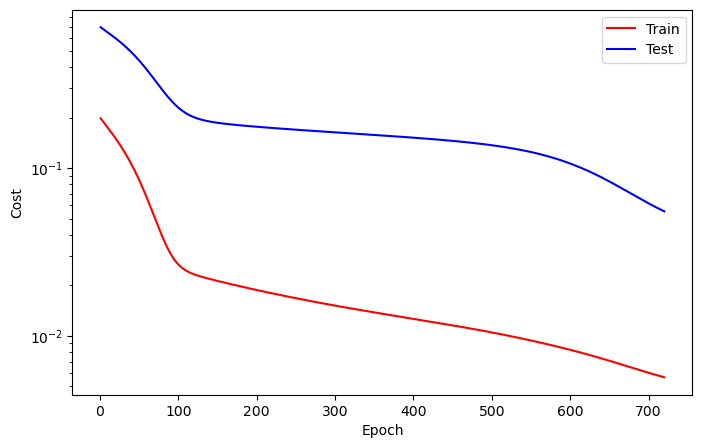

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   721
Train_cost  = 0.0056 | Test_cost  = 0.0550 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   722
Train_cost  = 0.0056 | Test_cost  = 0.0548 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   723
Train_cost  = 0.0056 | Test_cost  = 0.0545 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   724
Train_cost  = 0.0056 | Test_cost  = 0.0542 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   725
Train_cost  = 0.0056 | Test_cost  = 0.0540 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   726
Train_cost  = 0.0056 | Test_cost  = 0.0537 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   727
Train_cost  = 0.0055 | Test_cost  = 0.0535 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   728
Train_cost  = 0.0055 | Test_cost  = 0.0532 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   729
Train_cost  = 0.0055 | Test_cost  = 0.0530 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   730
Train_cost  = 0.0055 | Test_cost  = 0.0527 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   731
Train_cost  = 0.0055 | Test_cost  = 0.0525 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   732
Train_cost  = 0.0055 | Test_cost  = 0.0522 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   733
Train_cost  = 0.0055 | Test_cost  = 0.0520 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   734
Train_cost  = 0.0054 | Test_cost  = 0.0518 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   735
Train_cost  = 0.0054 | Test_cost  = 0.0516 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   736
Train_cost  = 0.0054 | Test_cost  = 0.0513 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   737
Train_cost  = 0.0054 | Test_cost  = 0.0511 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   738
Train_cost  = 0.0054 | Test_cost  = 0.0509 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   739
Train_cost  = 0.0054 | Test_cost  = 0.0507 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   740
Train_cost  = 0.0054 | Test_cost  = 0.0505 | 


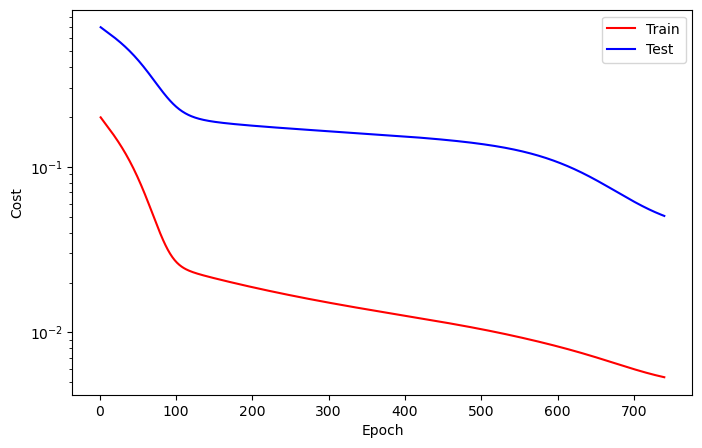

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   741
Train_cost  = 0.0054 | Test_cost  = 0.0503 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   742
Train_cost  = 0.0053 | Test_cost  = 0.0501 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   743
Train_cost  = 0.0053 | Test_cost  = 0.0499 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   744
Train_cost  = 0.0053 | Test_cost  = 0.0497 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   745
Train_cost  = 0.0053 | Test_cost  = 0.0495 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   746
Train_cost  = 0.0053 | Test_cost  = 0.0493 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   747
Train_cost  = 0.0053 | Test_cost  = 0.0491 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   748
Train_cost  = 0.0053 | Test_cost  = 0.0490 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   749
Train_cost  = 0.0053 | Test_cost  = 0.0488 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   750
Train_cost  = 0.0052 | Test_cost  = 0.0486 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   751
Train_cost  = 0.0052 | Test_cost  = 0.0484 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   752
Train_cost  = 0.0052 | Test_cost  = 0.0483 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   753
Train_cost  = 0.0052 | Test_cost  = 0.0481 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   754
Train_cost  = 0.0052 | Test_cost  = 0.0479 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   755
Train_cost  = 0.0052 | Test_cost  = 0.0478 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   756
Train_cost  = 0.0052 | Test_cost  = 0.0476 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   757
Train_cost  = 0.0052 | Test_cost  = 0.0475 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   758
Train_cost  = 0.0052 | Test_cost  = 0.0473 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   759
Train_cost  = 0.0052 | Test_cost  = 0.0472 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   760
Train_cost  = 0.0051 | Test_cost  = 0.0470 | 


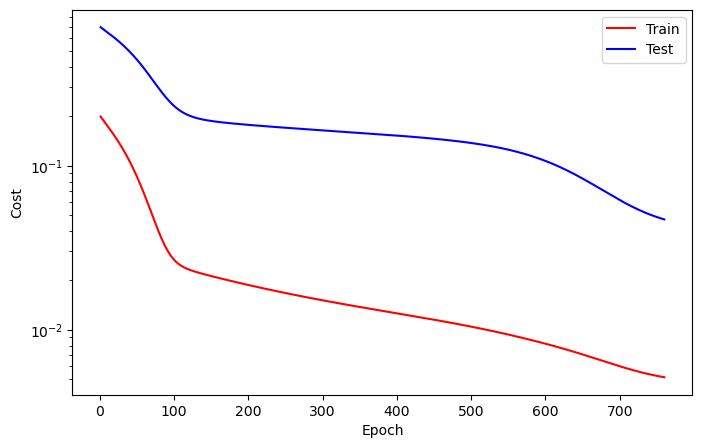

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   761
Train_cost  = 0.0051 | Test_cost  = 0.0469 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   762
Train_cost  = 0.0051 | Test_cost  = 0.0467 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   763
Train_cost  = 0.0051 | Test_cost  = 0.0466 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   764
Train_cost  = 0.0051 | Test_cost  = 0.0465 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   765
Train_cost  = 0.0051 | Test_cost  = 0.0463 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   766
Train_cost  = 0.0051 | Test_cost  = 0.0462 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   767
Train_cost  = 0.0051 | Test_cost  = 0.0461 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   768
Train_cost  = 0.0051 | Test_cost  = 0.0460 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   769
Train_cost  = 0.0051 | Test_cost  = 0.0458 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   770
Train_cost  = 0.0051 | Test_cost  = 0.0457 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   771
Train_cost  = 0.0051 | Test_cost  = 0.0456 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   772
Train_cost  = 0.0050 | Test_cost  = 0.0455 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   773
Train_cost  = 0.0050 | Test_cost  = 0.0454 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   774
Train_cost  = 0.0050 | Test_cost  = 0.0452 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   775
Train_cost  = 0.0050 | Test_cost  = 0.0451 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   776
Train_cost  = 0.0050 | Test_cost  = 0.0450 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   777
Train_cost  = 0.0050 | Test_cost  = 0.0449 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   778
Train_cost  = 0.0050 | Test_cost  = 0.0448 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   779
Train_cost  = 0.0050 | Test_cost  = 0.0447 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   780
Train_cost  = 0.0050 | Test_cost  = 0.0446 | 


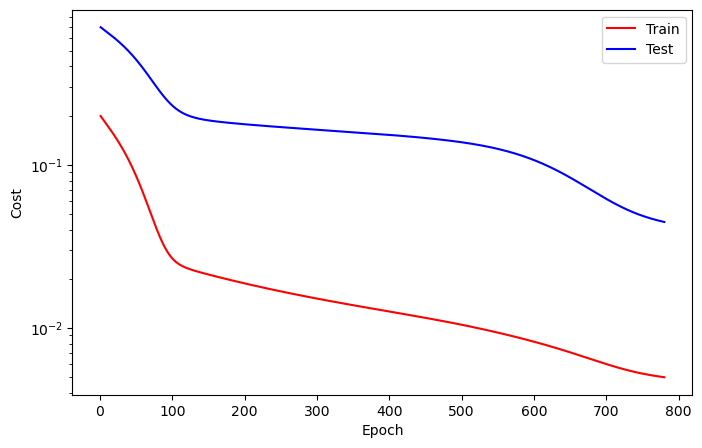

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   781
Train_cost  = 0.0050 | Test_cost  = 0.0445 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   782
Train_cost  = 0.0050 | Test_cost  = 0.0444 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   783
Train_cost  = 0.0050 | Test_cost  = 0.0443 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   784
Train_cost  = 0.0050 | Test_cost  = 0.0442 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   785
Train_cost  = 0.0050 | Test_cost  = 0.0441 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   786
Train_cost  = 0.0050 | Test_cost  = 0.0440 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   787
Train_cost  = 0.0049 | Test_cost  = 0.0439 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   788
Train_cost  = 0.0049 | Test_cost  = 0.0438 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   789
Train_cost  = 0.0049 | Test_cost  = 0.0437 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   790
Train_cost  = 0.0049 | Test_cost  = 0.0437 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   791
Train_cost  = 0.0049 | Test_cost  = 0.0436 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   792
Train_cost  = 0.0049 | Test_cost  = 0.0435 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   793
Train_cost  = 0.0049 | Test_cost  = 0.0434 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   794
Train_cost  = 0.0049 | Test_cost  = 0.0433 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   795
Train_cost  = 0.0049 | Test_cost  = 0.0432 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   796
Train_cost  = 0.0049 | Test_cost  = 0.0432 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   797
Train_cost  = 0.0049 | Test_cost  = 0.0431 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   798
Train_cost  = 0.0049 | Test_cost  = 0.0430 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   799
Train_cost  = 0.0049 | Test_cost  = 0.0429 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   800
Train_cost  = 0.0049 | Test_cost  = 0.0429 | 


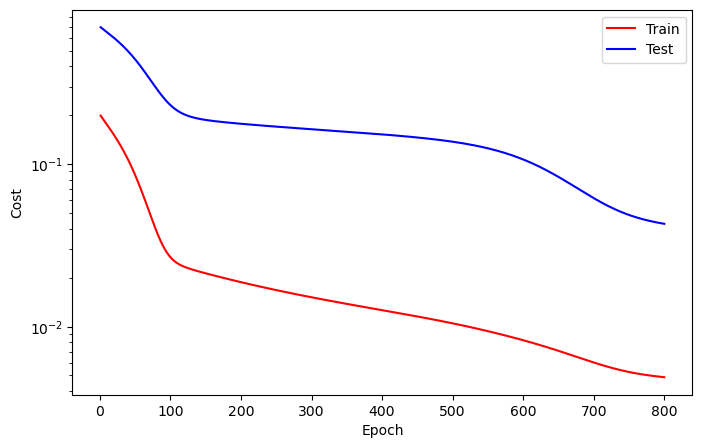

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   801
Train_cost  = 0.0049 | Test_cost  = 0.0428 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   802
Train_cost  = 0.0049 | Test_cost  = 0.0427 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   803
Train_cost  = 0.0049 | Test_cost  = 0.0426 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   804
Train_cost  = 0.0049 | Test_cost  = 0.0426 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   805
Train_cost  = 0.0048 | Test_cost  = 0.0425 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   806
Train_cost  = 0.0048 | Test_cost  = 0.0424 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   807
Train_cost  = 0.0048 | Test_cost  = 0.0424 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   808
Train_cost  = 0.0048 | Test_cost  = 0.0423 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   809
Train_cost  = 0.0048 | Test_cost  = 0.0422 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   810
Train_cost  = 0.0048 | Test_cost  = 0.0422 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   811
Train_cost  = 0.0048 | Test_cost  = 0.0421 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   812
Train_cost  = 0.0048 | Test_cost  = 0.0420 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   813
Train_cost  = 0.0048 | Test_cost  = 0.0420 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   814
Train_cost  = 0.0048 | Test_cost  = 0.0419 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   815
Train_cost  = 0.0048 | Test_cost  = 0.0419 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   816
Train_cost  = 0.0048 | Test_cost  = 0.0418 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   817
Train_cost  = 0.0048 | Test_cost  = 0.0417 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   818
Train_cost  = 0.0048 | Test_cost  = 0.0417 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   819
Train_cost  = 0.0048 | Test_cost  = 0.0416 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   820
Train_cost  = 0.0048 | Test_cost  = 0.0416 | 


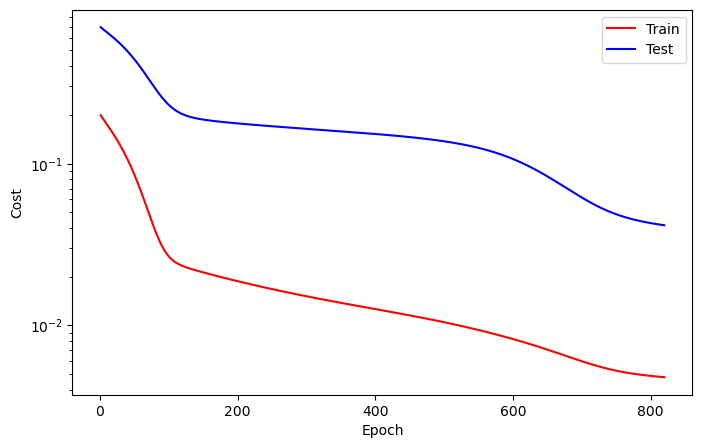

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   821
Train_cost  = 0.0048 | Test_cost  = 0.0415 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   822
Train_cost  = 0.0048 | Test_cost  = 0.0414 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   823
Train_cost  = 0.0048 | Test_cost  = 0.0414 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   824
Train_cost  = 0.0048 | Test_cost  = 0.0413 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   825
Train_cost  = 0.0048 | Test_cost  = 0.0413 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   826
Train_cost  = 0.0048 | Test_cost  = 0.0412 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   827
Train_cost  = 0.0048 | Test_cost  = 0.0412 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   828
Train_cost  = 0.0048 | Test_cost  = 0.0411 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   829
Train_cost  = 0.0047 | Test_cost  = 0.0411 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   830
Train_cost  = 0.0047 | Test_cost  = 0.0410 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   831
Train_cost  = 0.0047 | Test_cost  = 0.0410 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   832
Train_cost  = 0.0047 | Test_cost  = 0.0409 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   833
Train_cost  = 0.0047 | Test_cost  = 0.0408 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   834
Train_cost  = 0.0047 | Test_cost  = 0.0408 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   835
Train_cost  = 0.0047 | Test_cost  = 0.0407 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   836
Train_cost  = 0.0047 | Test_cost  = 0.0407 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   837
Train_cost  = 0.0047 | Test_cost  = 0.0406 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   838
Train_cost  = 0.0047 | Test_cost  = 0.0406 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   839
Train_cost  = 0.0047 | Test_cost  = 0.0405 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   840
Train_cost  = 0.0047 | Test_cost  = 0.0405 | 


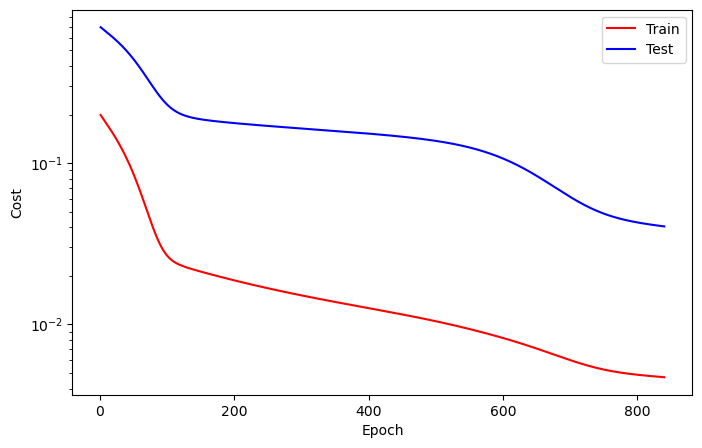

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   841
Train_cost  = 0.0047 | Test_cost  = 0.0404 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   842
Train_cost  = 0.0047 | Test_cost  = 0.0404 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   843
Train_cost  = 0.0047 | Test_cost  = 0.0404 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   844
Train_cost  = 0.0047 | Test_cost  = 0.0403 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   845
Train_cost  = 0.0047 | Test_cost  = 0.0403 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   846
Train_cost  = 0.0047 | Test_cost  = 0.0402 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   847
Train_cost  = 0.0047 | Test_cost  = 0.0402 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   848
Train_cost  = 0.0047 | Test_cost  = 0.0401 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   849
Train_cost  = 0.0047 | Test_cost  = 0.0401 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   850
Train_cost  = 0.0047 | Test_cost  = 0.0400 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   851
Train_cost  = 0.0047 | Test_cost  = 0.0400 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   852
Train_cost  = 0.0047 | Test_cost  = 0.0399 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   853
Train_cost  = 0.0047 | Test_cost  = 0.0399 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   854
Train_cost  = 0.0047 | Test_cost  = 0.0398 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   855
Train_cost  = 0.0047 | Test_cost  = 0.0398 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   856
Train_cost  = 0.0046 | Test_cost  = 0.0398 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   857
Train_cost  = 0.0046 | Test_cost  = 0.0397 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   858
Train_cost  = 0.0046 | Test_cost  = 0.0397 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   859
Train_cost  = 0.0046 | Test_cost  = 0.0396 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   860
Train_cost  = 0.0046 | Test_cost  = 0.0396 | 


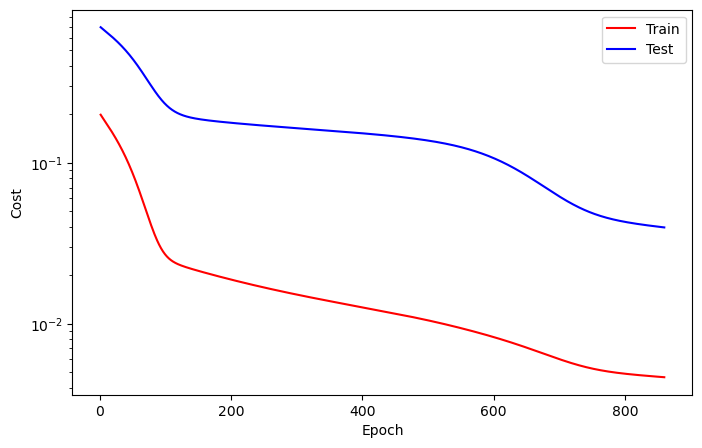

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   861
Train_cost  = 0.0046 | Test_cost  = 0.0395 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   862
Train_cost  = 0.0046 | Test_cost  = 0.0395 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   863
Train_cost  = 0.0046 | Test_cost  = 0.0395 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   864
Train_cost  = 0.0046 | Test_cost  = 0.0394 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   865
Train_cost  = 0.0046 | Test_cost  = 0.0394 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   866
Train_cost  = 0.0046 | Test_cost  = 0.0393 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   867
Train_cost  = 0.0046 | Test_cost  = 0.0393 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   868
Train_cost  = 0.0046 | Test_cost  = 0.0392 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   869
Train_cost  = 0.0046 | Test_cost  = 0.0392 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   870
Train_cost  = 0.0046 | Test_cost  = 0.0392 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   871
Train_cost  = 0.0046 | Test_cost  = 0.0391 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   872
Train_cost  = 0.0046 | Test_cost  = 0.0391 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   873
Train_cost  = 0.0046 | Test_cost  = 0.0390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   874
Train_cost  = 0.0046 | Test_cost  = 0.0390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   875
Train_cost  = 0.0046 | Test_cost  = 0.0390 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   876
Train_cost  = 0.0046 | Test_cost  = 0.0389 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   877
Train_cost  = 0.0046 | Test_cost  = 0.0389 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   878
Train_cost  = 0.0046 | Test_cost  = 0.0388 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   879
Train_cost  = 0.0046 | Test_cost  = 0.0388 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   880
Train_cost  = 0.0046 | Test_cost  = 0.0387 | 


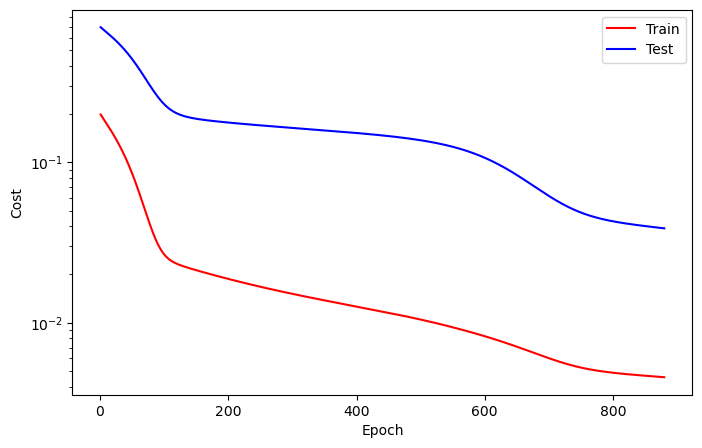

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   881
Train_cost  = 0.0046 | Test_cost  = 0.0387 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   882
Train_cost  = 0.0046 | Test_cost  = 0.0387 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   883
Train_cost  = 0.0046 | Test_cost  = 0.0386 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   884
Train_cost  = 0.0046 | Test_cost  = 0.0386 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   885
Train_cost  = 0.0046 | Test_cost  = 0.0385 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   886
Train_cost  = 0.0046 | Test_cost  = 0.0385 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   887
Train_cost  = 0.0045 | Test_cost  = 0.0385 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   888
Train_cost  = 0.0045 | Test_cost  = 0.0384 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   889
Train_cost  = 0.0045 | Test_cost  = 0.0384 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   890
Train_cost  = 0.0045 | Test_cost  = 0.0384 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   891
Train_cost  = 0.0045 | Test_cost  = 0.0383 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   892
Train_cost  = 0.0045 | Test_cost  = 0.0383 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   893
Train_cost  = 0.0045 | Test_cost  = 0.0382 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   894
Train_cost  = 0.0045 | Test_cost  = 0.0382 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   895
Train_cost  = 0.0045 | Test_cost  = 0.0382 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   896
Train_cost  = 0.0045 | Test_cost  = 0.0381 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   897
Train_cost  = 0.0045 | Test_cost  = 0.0381 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   898
Train_cost  = 0.0045 | Test_cost  = 0.0380 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   899
Train_cost  = 0.0045 | Test_cost  = 0.0380 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   900
Train_cost  = 0.0045 | Test_cost  = 0.0380 | 


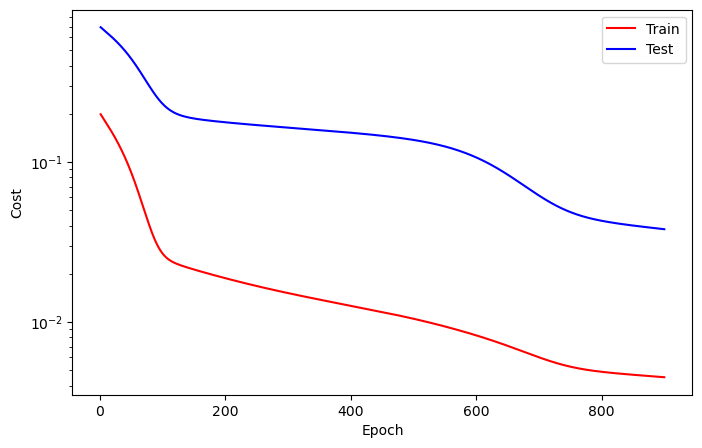

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   901
Train_cost  = 0.0045 | Test_cost  = 0.0379 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   902
Train_cost  = 0.0045 | Test_cost  = 0.0379 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   903
Train_cost  = 0.0045 | Test_cost  = 0.0378 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   904
Train_cost  = 0.0045 | Test_cost  = 0.0378 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   905
Train_cost  = 0.0045 | Test_cost  = 0.0378 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   906
Train_cost  = 0.0045 | Test_cost  = 0.0377 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   907
Train_cost  = 0.0045 | Test_cost  = 0.0377 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   908
Train_cost  = 0.0045 | Test_cost  = 0.0377 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   909
Train_cost  = 0.0045 | Test_cost  = 0.0376 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   910
Train_cost  = 0.0045 | Test_cost  = 0.0376 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   911
Train_cost  = 0.0045 | Test_cost  = 0.0375 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   912
Train_cost  = 0.0045 | Test_cost  = 0.0375 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   913
Train_cost  = 0.0045 | Test_cost  = 0.0375 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   914
Train_cost  = 0.0045 | Test_cost  = 0.0374 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   915
Train_cost  = 0.0045 | Test_cost  = 0.0374 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   916
Train_cost  = 0.0045 | Test_cost  = 0.0374 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   917
Train_cost  = 0.0045 | Test_cost  = 0.0373 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   918
Train_cost  = 0.0045 | Test_cost  = 0.0373 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   919
Train_cost  = 0.0045 | Test_cost  = 0.0372 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   920
Train_cost  = 0.0044 | Test_cost  = 0.0372 | 


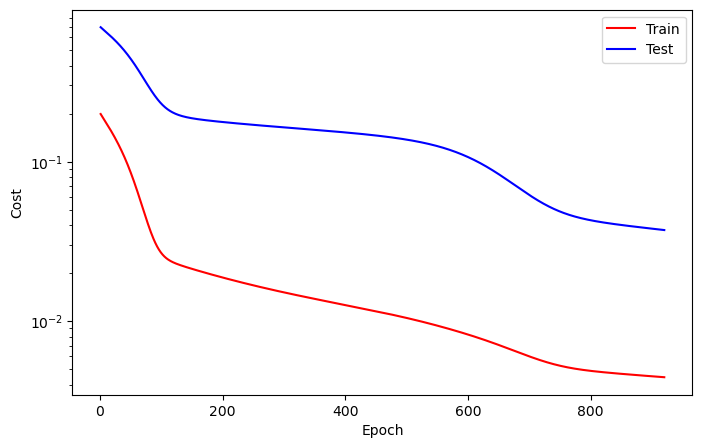

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   921
Train_cost  = 0.0044 | Test_cost  = 0.0372 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   922
Train_cost  = 0.0044 | Test_cost  = 0.0371 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   923
Train_cost  = 0.0044 | Test_cost  = 0.0371 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   924
Train_cost  = 0.0044 | Test_cost  = 0.0371 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   925
Train_cost  = 0.0044 | Test_cost  = 0.0370 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   926
Train_cost  = 0.0044 | Test_cost  = 0.0370 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   927
Train_cost  = 0.0044 | Test_cost  = 0.0370 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   928
Train_cost  = 0.0044 | Test_cost  = 0.0369 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   929
Train_cost  = 0.0044 | Test_cost  = 0.0369 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   930
Train_cost  = 0.0044 | Test_cost  = 0.0368 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   931
Train_cost  = 0.0044 | Test_cost  = 0.0368 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   932
Train_cost  = 0.0044 | Test_cost  = 0.0368 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   933
Train_cost  = 0.0044 | Test_cost  = 0.0367 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   934
Train_cost  = 0.0044 | Test_cost  = 0.0367 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   935
Train_cost  = 0.0044 | Test_cost  = 0.0367 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   936
Train_cost  = 0.0044 | Test_cost  = 0.0366 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   937
Train_cost  = 0.0044 | Test_cost  = 0.0366 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   938
Train_cost  = 0.0044 | Test_cost  = 0.0366 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   939
Train_cost  = 0.0044 | Test_cost  = 0.0365 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   940
Train_cost  = 0.0044 | Test_cost  = 0.0365 | 


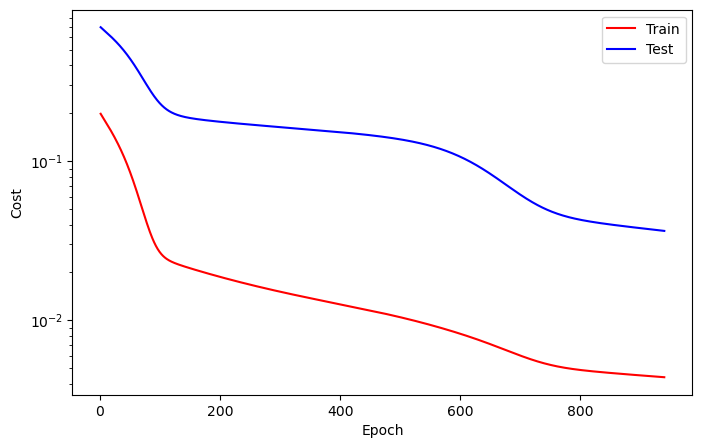

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   941
Train_cost  = 0.0044 | Test_cost  = 0.0364 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   942
Train_cost  = 0.0044 | Test_cost  = 0.0364 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   943
Train_cost  = 0.0044 | Test_cost  = 0.0364 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   944
Train_cost  = 0.0044 | Test_cost  = 0.0363 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   945
Train_cost  = 0.0044 | Test_cost  = 0.0363 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   946
Train_cost  = 0.0044 | Test_cost  = 0.0363 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   947
Train_cost  = 0.0044 | Test_cost  = 0.0362 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   948
Train_cost  = 0.0044 | Test_cost  = 0.0362 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   949
Train_cost  = 0.0044 | Test_cost  = 0.0362 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   950
Train_cost  = 0.0044 | Test_cost  = 0.0361 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   951
Train_cost  = 0.0044 | Test_cost  = 0.0361 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   952
Train_cost  = 0.0044 | Test_cost  = 0.0360 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   953
Train_cost  = 0.0044 | Test_cost  = 0.0360 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   954
Train_cost  = 0.0043 | Test_cost  = 0.0360 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   955
Train_cost  = 0.0043 | Test_cost  = 0.0359 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   956
Train_cost  = 0.0043 | Test_cost  = 0.0359 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   957
Train_cost  = 0.0043 | Test_cost  = 0.0359 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   958
Train_cost  = 0.0043 | Test_cost  = 0.0358 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   959
Train_cost  = 0.0043 | Test_cost  = 0.0358 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   960
Train_cost  = 0.0043 | Test_cost  = 0.0358 | 


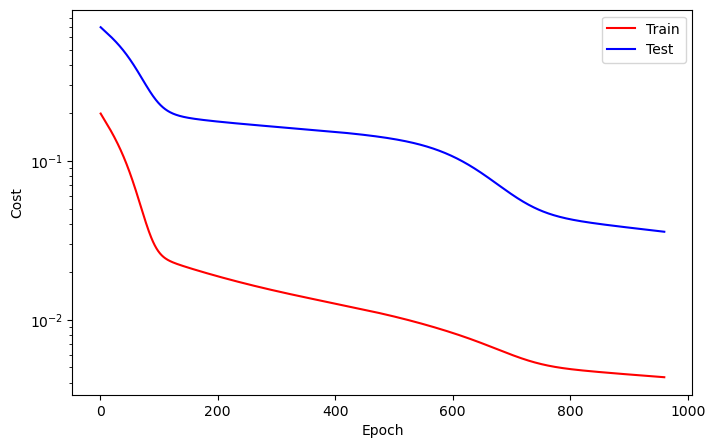

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   961
Train_cost  = 0.0043 | Test_cost  = 0.0357 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   962
Train_cost  = 0.0043 | Test_cost  = 0.0357 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   963
Train_cost  = 0.0043 | Test_cost  = 0.0357 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   964
Train_cost  = 0.0043 | Test_cost  = 0.0356 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   965
Train_cost  = 0.0043 | Test_cost  = 0.0356 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   966
Train_cost  = 0.0043 | Test_cost  = 0.0356 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   967
Train_cost  = 0.0043 | Test_cost  = 0.0355 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   968
Train_cost  = 0.0043 | Test_cost  = 0.0355 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   969
Train_cost  = 0.0043 | Test_cost  = 0.0354 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   970
Train_cost  = 0.0043 | Test_cost  = 0.0354 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   971
Train_cost  = 0.0043 | Test_cost  = 0.0354 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   972
Train_cost  = 0.0043 | Test_cost  = 0.0353 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   973
Train_cost  = 0.0043 | Test_cost  = 0.0353 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   974
Train_cost  = 0.0043 | Test_cost  = 0.0353 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   975
Train_cost  = 0.0043 | Test_cost  = 0.0352 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   976
Train_cost  = 0.0043 | Test_cost  = 0.0352 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   977
Train_cost  = 0.0043 | Test_cost  = 0.0352 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   978
Train_cost  = 0.0043 | Test_cost  = 0.0351 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   979
Train_cost  = 0.0043 | Test_cost  = 0.0351 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   980
Train_cost  = 0.0043 | Test_cost  = 0.0351 | 


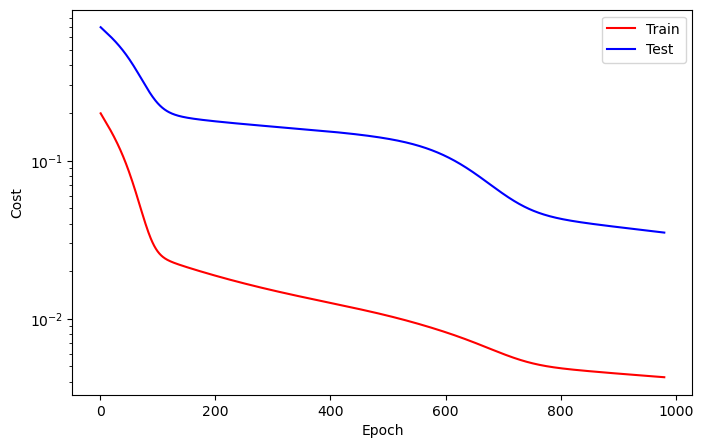

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   981
Train_cost  = 0.0043 | Test_cost  = 0.0350 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   982
Train_cost  = 0.0043 | Test_cost  = 0.0350 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   983
Train_cost  = 0.0043 | Test_cost  = 0.0350 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   984
Train_cost  = 0.0043 | Test_cost  = 0.0349 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   985
Train_cost  = 0.0043 | Test_cost  = 0.0349 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   986
Train_cost  = 0.0043 | Test_cost  = 0.0349 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   987
Train_cost  = 0.0043 | Test_cost  = 0.0348 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   988
Train_cost  = 0.0043 | Test_cost  = 0.0348 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   989
Train_cost  = 0.0043 | Test_cost  = 0.0347 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   990
Train_cost  = 0.0043 | Test_cost  = 0.0347 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   991
Train_cost  = 0.0042 | Test_cost  = 0.0347 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   992
Train_cost  = 0.0042 | Test_cost  = 0.0346 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   993
Train_cost  = 0.0042 | Test_cost  = 0.0346 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   994
Train_cost  = 0.0042 | Test_cost  = 0.0346 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   995
Train_cost  = 0.0042 | Test_cost  = 0.0345 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   996
Train_cost  = 0.0042 | Test_cost  = 0.0345 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   997
Train_cost  = 0.0042 | Test_cost  = 0.0345 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   998
Train_cost  = 0.0042 | Test_cost  = 0.0344 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch   999
Train_cost  = 0.0042 | Test_cost  = 0.0344 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1000
Train_cost  = 0.0042 | Test_cost  = 0.0344 | 


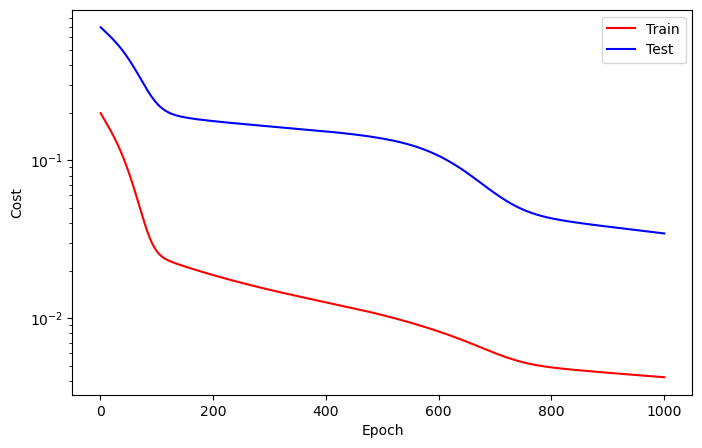

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1001
Train_cost  = 0.0042 | Test_cost  = 0.0343 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1002
Train_cost  = 0.0042 | Test_cost  = 0.0343 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1003
Train_cost  = 0.0042 | Test_cost  = 0.0343 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1004
Train_cost  = 0.0042 | Test_cost  = 0.0342 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1005
Train_cost  = 0.0042 | Test_cost  = 0.0342 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1006
Train_cost  = 0.0042 | Test_cost  = 0.0342 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1007
Train_cost  = 0.0042 | Test_cost  = 0.0341 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1008
Train_cost  = 0.0042 | Test_cost  = 0.0341 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1009
Train_cost  = 0.0042 | Test_cost  = 0.0341 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1010
Train_cost  = 0.0042 | Test_cost  = 0.0340 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1011
Train_cost  = 0.0042 | Test_cost  = 0.0340 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1012
Train_cost  = 0.0042 | Test_cost  = 0.0340 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1013
Train_cost  = 0.0042 | Test_cost  = 0.0339 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1014
Train_cost  = 0.0042 | Test_cost  = 0.0339 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1015
Train_cost  = 0.0042 | Test_cost  = 0.0339 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1016
Train_cost  = 0.0042 | Test_cost  = 0.0338 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1017
Train_cost  = 0.0042 | Test_cost  = 0.0338 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1018
Train_cost  = 0.0042 | Test_cost  = 0.0338 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1019
Train_cost  = 0.0042 | Test_cost  = 0.0337 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1020
Train_cost  = 0.0042 | Test_cost  = 0.0337 | 


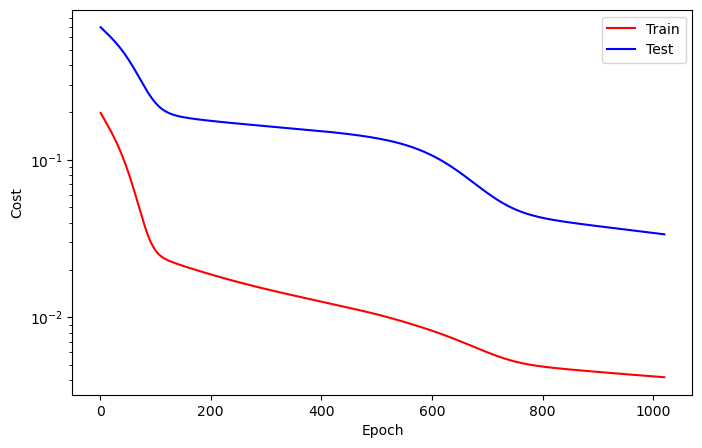

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1021
Train_cost  = 0.0042 | Test_cost  = 0.0337 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1022
Train_cost  = 0.0042 | Test_cost  = 0.0336 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1023
Train_cost  = 0.0042 | Test_cost  = 0.0336 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1024
Train_cost  = 0.0042 | Test_cost  = 0.0336 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1025
Train_cost  = 0.0042 | Test_cost  = 0.0335 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1026
Train_cost  = 0.0042 | Test_cost  = 0.0335 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1027
Train_cost  = 0.0042 | Test_cost  = 0.0335 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1028
Train_cost  = 0.0042 | Test_cost  = 0.0334 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1029
Train_cost  = 0.0041 | Test_cost  = 0.0334 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1030
Train_cost  = 0.0041 | Test_cost  = 0.0334 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1031
Train_cost  = 0.0041 | Test_cost  = 0.0333 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1032
Train_cost  = 0.0041 | Test_cost  = 0.0333 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1033
Train_cost  = 0.0041 | Test_cost  = 0.0333 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1034
Train_cost  = 0.0041 | Test_cost  = 0.0332 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1035
Train_cost  = 0.0041 | Test_cost  = 0.0332 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1036
Train_cost  = 0.0041 | Test_cost  = 0.0332 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1037
Train_cost  = 0.0041 | Test_cost  = 0.0331 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1038
Train_cost  = 0.0041 | Test_cost  = 0.0331 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1039
Train_cost  = 0.0041 | Test_cost  = 0.0331 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1040
Train_cost  = 0.0041 | Test_cost  = 0.0330 | 


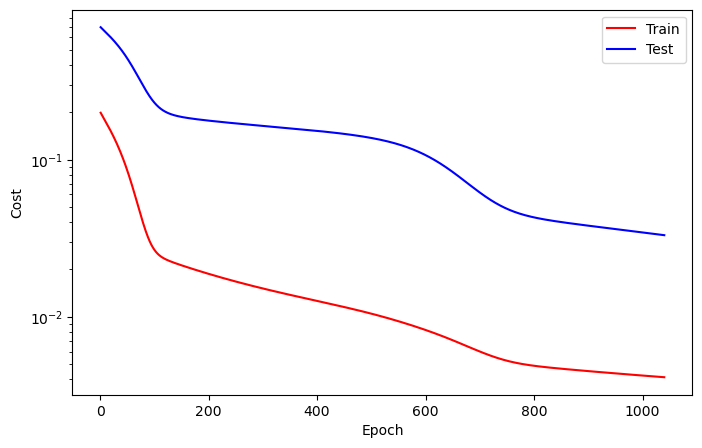

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1041
Train_cost  = 0.0041 | Test_cost  = 0.0330 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1042
Train_cost  = 0.0041 | Test_cost  = 0.0330 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1043
Train_cost  = 0.0041 | Test_cost  = 0.0329 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1044
Train_cost  = 0.0041 | Test_cost  = 0.0329 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1045
Train_cost  = 0.0041 | Test_cost  = 0.0329 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1046
Train_cost  = 0.0041 | Test_cost  = 0.0328 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1047
Train_cost  = 0.0041 | Test_cost  = 0.0328 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1048
Train_cost  = 0.0041 | Test_cost  = 0.0328 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1049
Train_cost  = 0.0041 | Test_cost  = 0.0327 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1065
Train_cost  = 0.0041 | Test_cost  = 0.0322 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1066
Train_cost  = 0.0041 | Test_cost  = 0.0322 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1067
Train_cost  = 0.0041 | Test_cost  = 0.0322 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1068
Train_cost  = 0.0041 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1069
Train_cost  = 0.0041 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1070
Train_cost  = 0.0040 | Test_cost  = 0.0321 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1071
Train_cost  = 0.0040 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1072
Train_cost  = 0.0040 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1073
Train_cost  = 0.0040 | Test_cost  = 0.0320 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1074
Train_cost  = 0.0040 | Test_cost  = 0.0319 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1075
Train_cost  = 0.0040 | Test_cost  = 0.0319 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1076
Train_cost  = 0.0040 | Test_cost  = 0.0319 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1077
Train_cost  = 0.0040 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1078
Train_cost  = 0.0040 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1079
Train_cost  = 0.0040 | Test_cost  = 0.0318 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1080
Train_cost  = 0.0040 | Test_cost  = 0.0317 | 


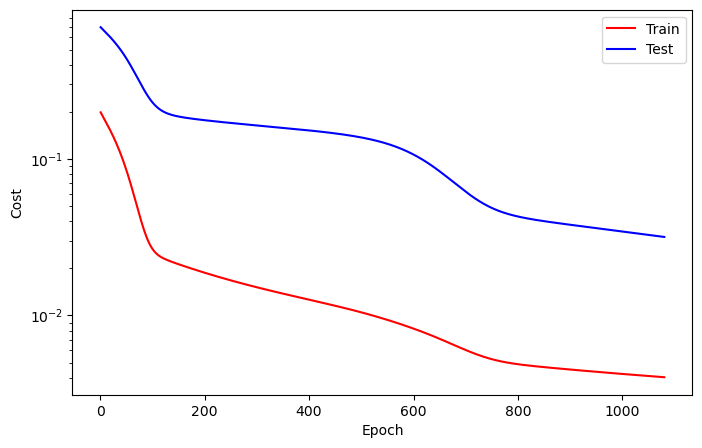

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1081
Train_cost  = 0.0040 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1082
Train_cost  = 0.0040 | Test_cost  = 0.0317 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1083
Train_cost  = 0.0040 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1084
Train_cost  = 0.0040 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1085
Train_cost  = 0.0040 | Test_cost  = 0.0316 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1086
Train_cost  = 0.0040 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1087
Train_cost  = 0.0040 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1088
Train_cost  = 0.0040 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1089
Train_cost  = 0.0040 | Test_cost  = 0.0315 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1090
Train_cost  = 0.0040 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1091
Train_cost  = 0.0040 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1092
Train_cost  = 0.0040 | Test_cost  = 0.0314 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1093
Train_cost  = 0.0040 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1094
Train_cost  = 0.0040 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1095
Train_cost  = 0.0040 | Test_cost  = 0.0313 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1096
Train_cost  = 0.0040 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1097
Train_cost  = 0.0040 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1098
Train_cost  = 0.0040 | Test_cost  = 0.0312 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1099
Train_cost  = 0.0040 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1100
Train_cost  = 0.0040 | Test_cost  = 0.0311 | 


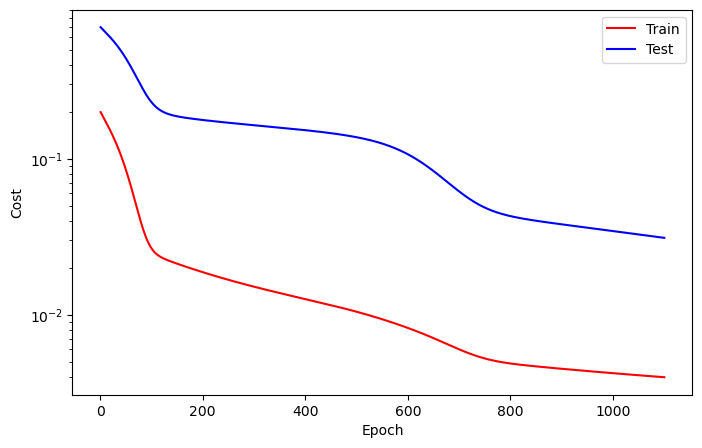

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1101
Train_cost  = 0.0040 | Test_cost  = 0.0311 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1102
Train_cost  = 0.0040 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1103
Train_cost  = 0.0040 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1104
Train_cost  = 0.0040 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1105
Train_cost  = 0.0040 | Test_cost  = 0.0310 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1106
Train_cost  = 0.0040 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1107
Train_cost  = 0.0040 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1108
Train_cost  = 0.0040 | Test_cost  = 0.0309 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1109
Train_cost  = 0.0040 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1110
Train_cost  = 0.0040 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1111
Train_cost  = 0.0040 | Test_cost  = 0.0308 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1112
Train_cost  = 0.0040 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1113
Train_cost  = 0.0040 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1114
Train_cost  = 0.0039 | Test_cost  = 0.0307 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1115
Train_cost  = 0.0039 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1116
Train_cost  = 0.0039 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1117
Train_cost  = 0.0039 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1118
Train_cost  = 0.0039 | Test_cost  = 0.0306 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1119
Train_cost  = 0.0039 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1120
Train_cost  = 0.0039 | Test_cost  = 0.0305 | 


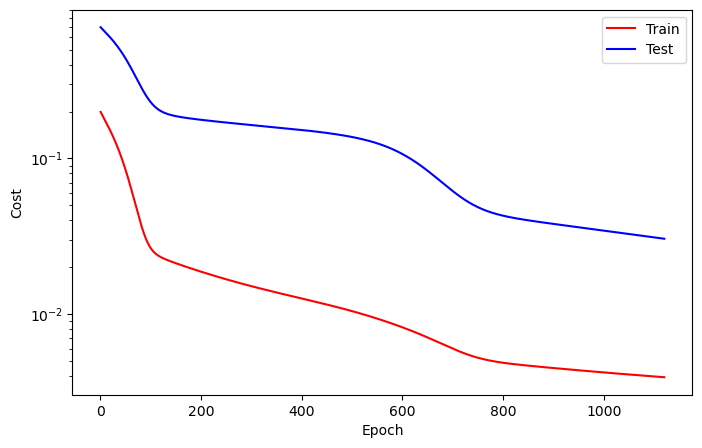

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1121
Train_cost  = 0.0039 | Test_cost  = 0.0305 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1122
Train_cost  = 0.0039 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1123
Train_cost  = 0.0039 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1124
Train_cost  = 0.0039 | Test_cost  = 0.0304 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1125
Train_cost  = 0.0039 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1126
Train_cost  = 0.0039 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1127
Train_cost  = 0.0039 | Test_cost  = 0.0303 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1128
Train_cost  = 0.0039 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1129
Train_cost  = 0.0039 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1130
Train_cost  = 0.0039 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1131
Train_cost  = 0.0039 | Test_cost  = 0.0302 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1132
Train_cost  = 0.0039 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1133
Train_cost  = 0.0039 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1134
Train_cost  = 0.0039 | Test_cost  = 0.0301 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1135
Train_cost  = 0.0039 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1136
Train_cost  = 0.0039 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1137
Train_cost  = 0.0039 | Test_cost  = 0.0300 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1138
Train_cost  = 0.0039 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1139
Train_cost  = 0.0039 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1140
Train_cost  = 0.0039 | Test_cost  = 0.0299 | 


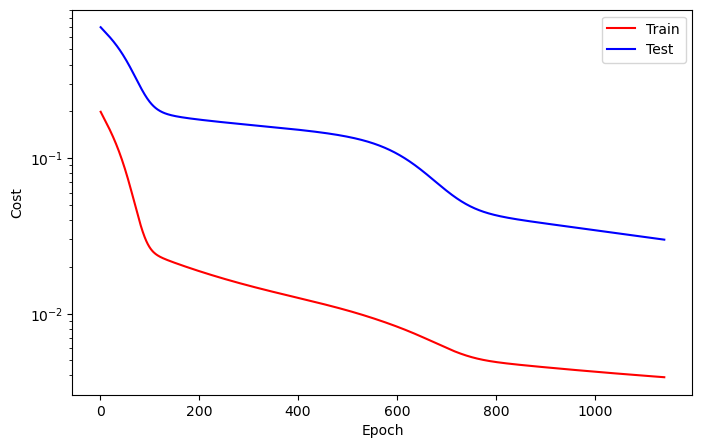

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1141
Train_cost  = 0.0039 | Test_cost  = 0.0299 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1142
Train_cost  = 0.0039 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1143
Train_cost  = 0.0039 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1144
Train_cost  = 0.0039 | Test_cost  = 0.0298 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1145
Train_cost  = 0.0039 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1146
Train_cost  = 0.0039 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1147
Train_cost  = 0.0039 | Test_cost  = 0.0297 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1148
Train_cost  = 0.0039 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1149
Train_cost  = 0.0039 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1150
Train_cost  = 0.0039 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1151
Train_cost  = 0.0039 | Test_cost  = 0.0296 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1152
Train_cost  = 0.0039 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1153
Train_cost  = 0.0039 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1154
Train_cost  = 0.0039 | Test_cost  = 0.0295 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1155
Train_cost  = 0.0039 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1156
Train_cost  = 0.0039 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1157
Train_cost  = 0.0039 | Test_cost  = 0.0294 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1158
Train_cost  = 0.0039 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1159
Train_cost  = 0.0039 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1160
Train_cost  = 0.0039 | Test_cost  = 0.0293 | 


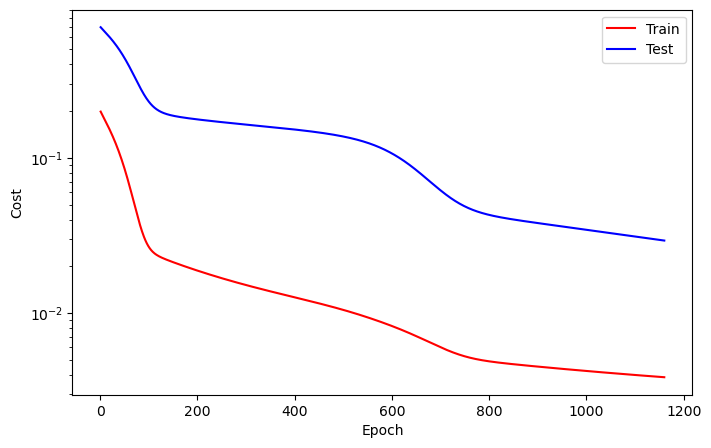

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1161
Train_cost  = 0.0038 | Test_cost  = 0.0293 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1162
Train_cost  = 0.0038 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1163
Train_cost  = 0.0038 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1164
Train_cost  = 0.0038 | Test_cost  = 0.0292 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1165
Train_cost  = 0.0038 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1166
Train_cost  = 0.0038 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1167
Train_cost  = 0.0038 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1168
Train_cost  = 0.0038 | Test_cost  = 0.0291 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1169
Train_cost  = 0.0038 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1170
Train_cost  = 0.0038 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1171
Train_cost  = 0.0038 | Test_cost  = 0.0290 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1172
Train_cost  = 0.0038 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1173
Train_cost  = 0.0038 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1174
Train_cost  = 0.0038 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1175
Train_cost  = 0.0038 | Test_cost  = 0.0289 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1176
Train_cost  = 0.0038 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1177
Train_cost  = 0.0038 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1178
Train_cost  = 0.0038 | Test_cost  = 0.0288 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1179
Train_cost  = 0.0038 | Test_cost  = 0.0287 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1180
Train_cost  = 0.0038 | Test_cost  = 0.0287 | 


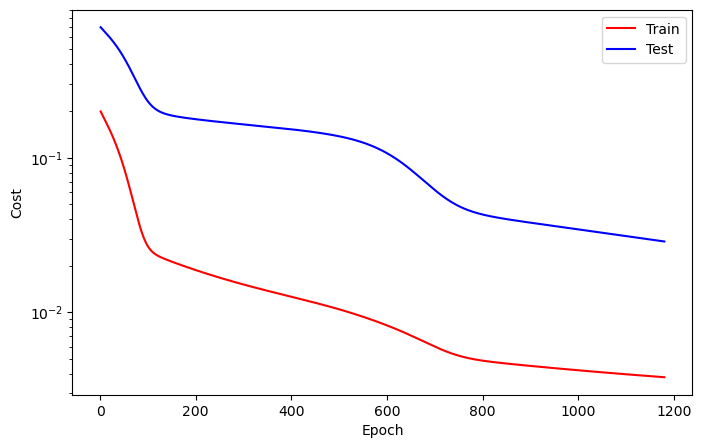

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1181
Train_cost  = 0.0038 | Test_cost  = 0.0287 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1182
Train_cost  = 0.0038 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1183
Train_cost  = 0.0038 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1184
Train_cost  = 0.0038 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1185
Train_cost  = 0.0038 | Test_cost  = 0.0286 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1186
Train_cost  = 0.0038 | Test_cost  = 0.0285 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1187
Train_cost  = 0.0038 | Test_cost  = 0.0285 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1188
Train_cost  = 0.0038 | Test_cost  = 0.0285 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1189
Train_cost  = 0.0038 | Test_cost  = 0.0284 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1190
Train_cost  = 0.0038 | Test_cost  = 0.0284 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1191
Train_cost  = 0.0038 | Test_cost  = 0.0284 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1192
Train_cost  = 0.0038 | Test_cost  = 0.0284 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1193
Train_cost  = 0.0038 | Test_cost  = 0.0283 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1194
Train_cost  = 0.0038 | Test_cost  = 0.0283 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1195
Train_cost  = 0.0038 | Test_cost  = 0.0283 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1196
Train_cost  = 0.0038 | Test_cost  = 0.0283 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1197
Train_cost  = 0.0038 | Test_cost  = 0.0282 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1198
Train_cost  = 0.0038 | Test_cost  = 0.0282 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1199
Train_cost  = 0.0038 | Test_cost  = 0.0282 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1200
Train_cost  = 0.0038 | Test_cost  = 0.0281 | 


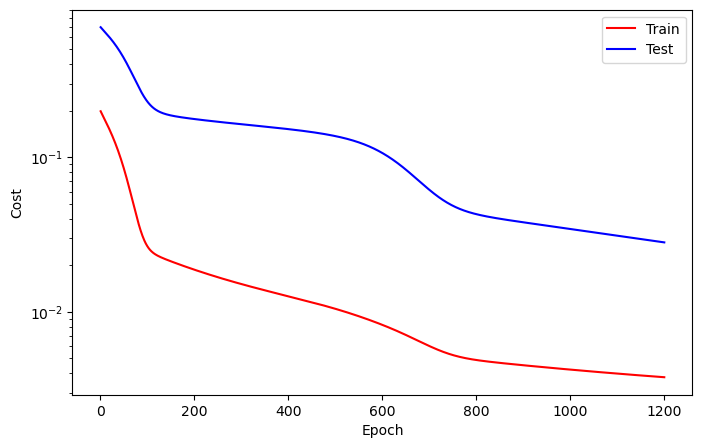

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1201
Train_cost  = 0.0038 | Test_cost  = 0.0281 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1202
Train_cost  = 0.0038 | Test_cost  = 0.0281 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1203
Train_cost  = 0.0038 | Test_cost  = 0.0281 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1204
Train_cost  = 0.0038 | Test_cost  = 0.0280 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1205
Train_cost  = 0.0038 | Test_cost  = 0.0280 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1206
Train_cost  = 0.0038 | Test_cost  = 0.0280 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1207
Train_cost  = 0.0038 | Test_cost  = 0.0279 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1208
Train_cost  = 0.0038 | Test_cost  = 0.0279 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1209
Train_cost  = 0.0038 | Test_cost  = 0.0279 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1210
Train_cost  = 0.0038 | Test_cost  = 0.0279 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1211
Train_cost  = 0.0037 | Test_cost  = 0.0278 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1212
Train_cost  = 0.0037 | Test_cost  = 0.0278 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1213
Train_cost  = 0.0037 | Test_cost  = 0.0278 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1214
Train_cost  = 0.0037 | Test_cost  = 0.0277 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1215
Train_cost  = 0.0037 | Test_cost  = 0.0277 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1216
Train_cost  = 0.0037 | Test_cost  = 0.0277 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1217
Train_cost  = 0.0037 | Test_cost  = 0.0277 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1218
Train_cost  = 0.0037 | Test_cost  = 0.0276 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1219
Train_cost  = 0.0037 | Test_cost  = 0.0276 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1220
Train_cost  = 0.0037 | Test_cost  = 0.0276 | 


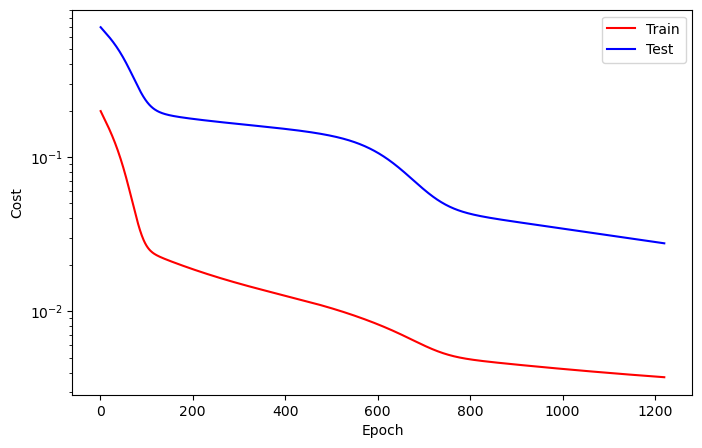

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1221
Train_cost  = 0.0037 | Test_cost  = 0.0276 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1222
Train_cost  = 0.0037 | Test_cost  = 0.0275 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1223
Train_cost  = 0.0037 | Test_cost  = 0.0275 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1224
Train_cost  = 0.0037 | Test_cost  = 0.0275 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1225
Train_cost  = 0.0037 | Test_cost  = 0.0274 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1226
Train_cost  = 0.0037 | Test_cost  = 0.0274 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1227
Train_cost  = 0.0037 | Test_cost  = 0.0274 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1228
Train_cost  = 0.0037 | Test_cost  = 0.0274 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1229
Train_cost  = 0.0037 | Test_cost  = 0.0273 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1230
Train_cost  = 0.0037 | Test_cost  = 0.0273 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1231
Train_cost  = 0.0037 | Test_cost  = 0.0273 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1232
Train_cost  = 0.0037 | Test_cost  = 0.0273 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1233
Train_cost  = 0.0037 | Test_cost  = 0.0272 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1234
Train_cost  = 0.0037 | Test_cost  = 0.0272 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1235
Train_cost  = 0.0037 | Test_cost  = 0.0272 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1236
Train_cost  = 0.0037 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1237
Train_cost  = 0.0037 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1238
Train_cost  = 0.0037 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1239
Train_cost  = 0.0037 | Test_cost  = 0.0271 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1240
Train_cost  = 0.0037 | Test_cost  = 0.0270 | 


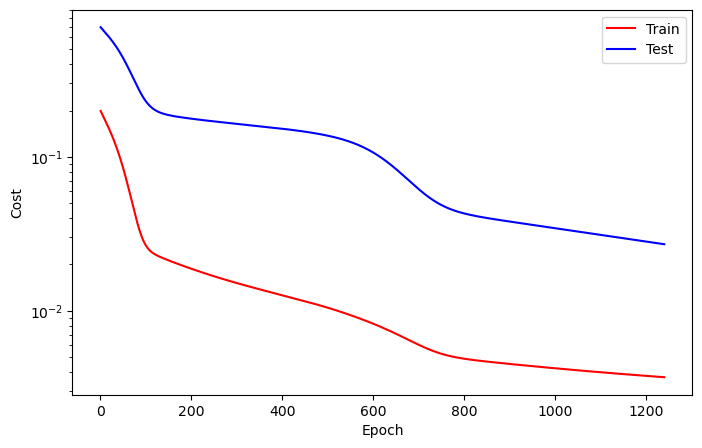

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1241
Train_cost  = 0.0037 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1242
Train_cost  = 0.0037 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1243
Train_cost  = 0.0037 | Test_cost  = 0.0270 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1244
Train_cost  = 0.0037 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1245
Train_cost  = 0.0037 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1246
Train_cost  = 0.0037 | Test_cost  = 0.0269 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1247
Train_cost  = 0.0037 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1248
Train_cost  = 0.0037 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1249
Train_cost  = 0.0037 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1250
Train_cost  = 0.0037 | Test_cost  = 0.0268 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1251
Train_cost  = 0.0037 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1252
Train_cost  = 0.0037 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1253
Train_cost  = 0.0037 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1254
Train_cost  = 0.0037 | Test_cost  = 0.0267 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1255
Train_cost  = 0.0037 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1256
Train_cost  = 0.0037 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1257
Train_cost  = 0.0037 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1258
Train_cost  = 0.0037 | Test_cost  = 0.0266 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1259
Train_cost  = 0.0037 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1260
Train_cost  = 0.0037 | Test_cost  = 0.0265 | 


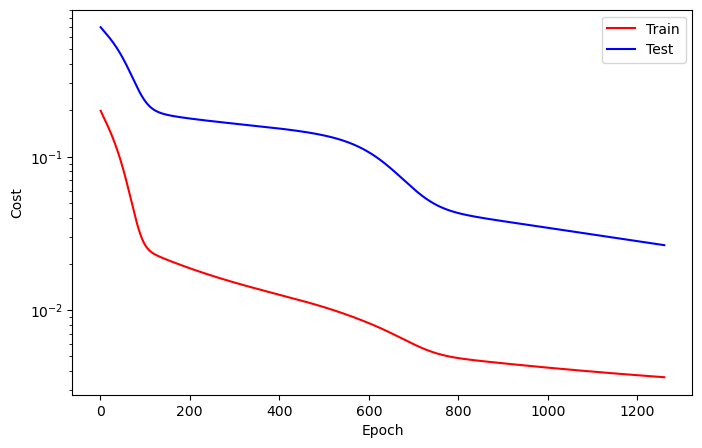

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1261
Train_cost  = 0.0037 | Test_cost  = 0.0265 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1262
Train_cost  = 0.0037 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1263
Train_cost  = 0.0037 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1264
Train_cost  = 0.0037 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1265
Train_cost  = 0.0037 | Test_cost  = 0.0264 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1266
Train_cost  = 0.0036 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1267
Train_cost  = 0.0036 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1268
Train_cost  = 0.0036 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1269
Train_cost  = 0.0036 | Test_cost  = 0.0263 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1270
Train_cost  = 0.0036 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1271
Train_cost  = 0.0036 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1272
Train_cost  = 0.0036 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1273
Train_cost  = 0.0036 | Test_cost  = 0.0262 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1274
Train_cost  = 0.0036 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1275
Train_cost  = 0.0036 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1276
Train_cost  = 0.0036 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1277
Train_cost  = 0.0036 | Test_cost  = 0.0261 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1278
Train_cost  = 0.0036 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1279
Train_cost  = 0.0036 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1280
Train_cost  = 0.0036 | Test_cost  = 0.0260 | 


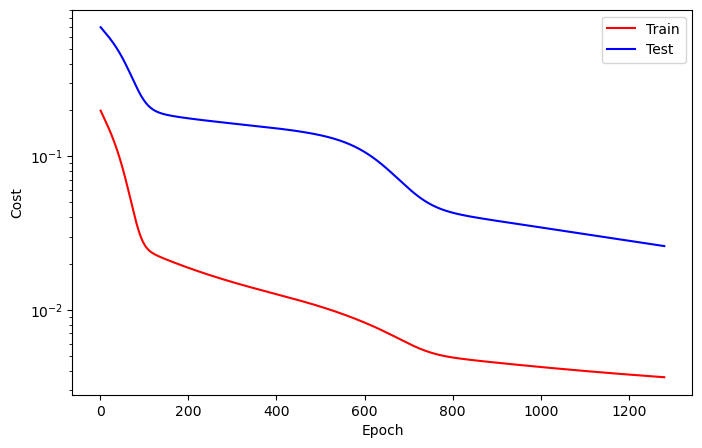

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1281
Train_cost  = 0.0036 | Test_cost  = 0.0260 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1282
Train_cost  = 0.0036 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1283
Train_cost  = 0.0036 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1284
Train_cost  = 0.0036 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1285
Train_cost  = 0.0036 | Test_cost  = 0.0259 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1286
Train_cost  = 0.0036 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1287
Train_cost  = 0.0036 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1288
Train_cost  = 0.0036 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1289
Train_cost  = 0.0036 | Test_cost  = 0.0258 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1290
Train_cost  = 0.0036 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1291
Train_cost  = 0.0036 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1292
Train_cost  = 0.0036 | Test_cost  = 0.0257 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1293
Train_cost  = 0.0036 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1294
Train_cost  = 0.0036 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1295
Train_cost  = 0.0036 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1296
Train_cost  = 0.0036 | Test_cost  = 0.0256 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1297
Train_cost  = 0.0036 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1298
Train_cost  = 0.0036 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1299
Train_cost  = 0.0036 | Test_cost  = 0.0255 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1300
Train_cost  = 0.0036 | Test_cost  = 0.0255 | 


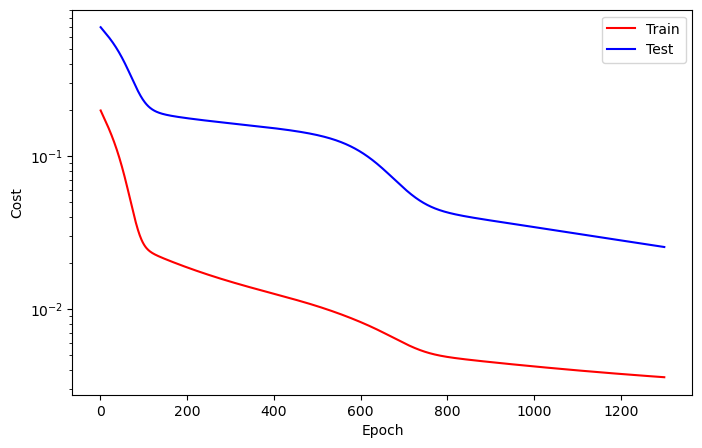

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1301
Train_cost  = 0.0036 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1302
Train_cost  = 0.0036 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1303
Train_cost  = 0.0036 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1304
Train_cost  = 0.0036 | Test_cost  = 0.0254 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1305
Train_cost  = 0.0036 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1306
Train_cost  = 0.0036 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1307
Train_cost  = 0.0036 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1308
Train_cost  = 0.0036 | Test_cost  = 0.0253 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1309
Train_cost  = 0.0036 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1310
Train_cost  = 0.0036 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1311
Train_cost  = 0.0036 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1312
Train_cost  = 0.0036 | Test_cost  = 0.0252 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1313
Train_cost  = 0.0036 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1314
Train_cost  = 0.0036 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1315
Train_cost  = 0.0036 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1316
Train_cost  = 0.0036 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1317
Train_cost  = 0.0036 | Test_cost  = 0.0251 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1318
Train_cost  = 0.0036 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1319
Train_cost  = 0.0036 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1320
Train_cost  = 0.0036 | Test_cost  = 0.0250 | 


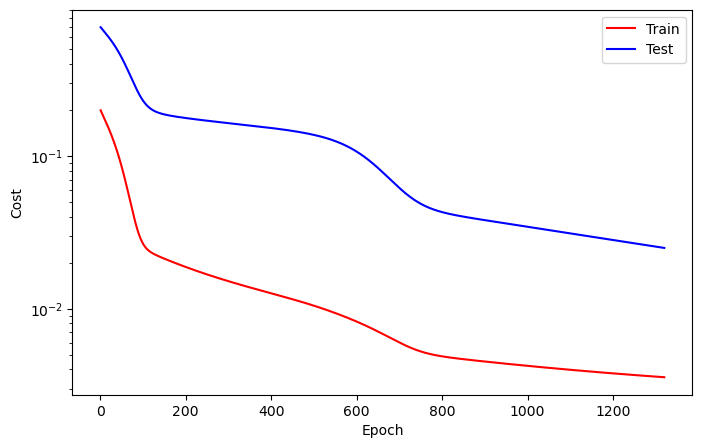

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1321
Train_cost  = 0.0036 | Test_cost  = 0.0250 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1322
Train_cost  = 0.0036 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1323
Train_cost  = 0.0036 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1324
Train_cost  = 0.0036 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1325
Train_cost  = 0.0036 | Test_cost  = 0.0249 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1326
Train_cost  = 0.0035 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1327
Train_cost  = 0.0035 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1328
Train_cost  = 0.0035 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1329
Train_cost  = 0.0035 | Test_cost  = 0.0248 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1330
Train_cost  = 0.0035 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1331
Train_cost  = 0.0035 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1332
Train_cost  = 0.0035 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1333
Train_cost  = 0.0035 | Test_cost  = 0.0247 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1334
Train_cost  = 0.0035 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1335
Train_cost  = 0.0035 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1336
Train_cost  = 0.0035 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1337
Train_cost  = 0.0035 | Test_cost  = 0.0246 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1338
Train_cost  = 0.0035 | Test_cost  = 0.0245 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1339
Train_cost  = 0.0035 | Test_cost  = 0.0245 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1340
Train_cost  = 0.0035 | Test_cost  = 0.0245 | 


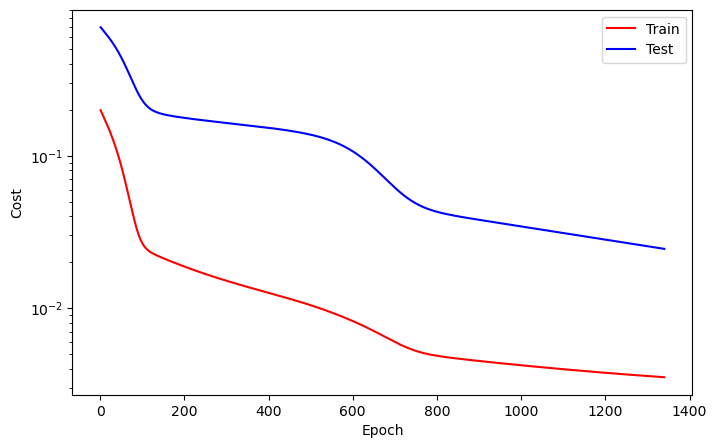

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1341
Train_cost  = 0.0035 | Test_cost  = 0.0245 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1342
Train_cost  = 0.0035 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1343
Train_cost  = 0.0035 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1344
Train_cost  = 0.0035 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1345
Train_cost  = 0.0035 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1346
Train_cost  = 0.0035 | Test_cost  = 0.0244 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1347
Train_cost  = 0.0035 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1348
Train_cost  = 0.0035 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1349
Train_cost  = 0.0035 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1350
Train_cost  = 0.0035 | Test_cost  = 0.0243 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1351
Train_cost  = 0.0035 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1352
Train_cost  = 0.0035 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1353
Train_cost  = 0.0035 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1354
Train_cost  = 0.0035 | Test_cost  = 0.0242 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1355
Train_cost  = 0.0035 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1356
Train_cost  = 0.0035 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1357
Train_cost  = 0.0035 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1358
Train_cost  = 0.0035 | Test_cost  = 0.0241 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1359
Train_cost  = 0.0035 | Test_cost  = 0.0240 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1360
Train_cost  = 0.0035 | Test_cost  = 0.0240 | 


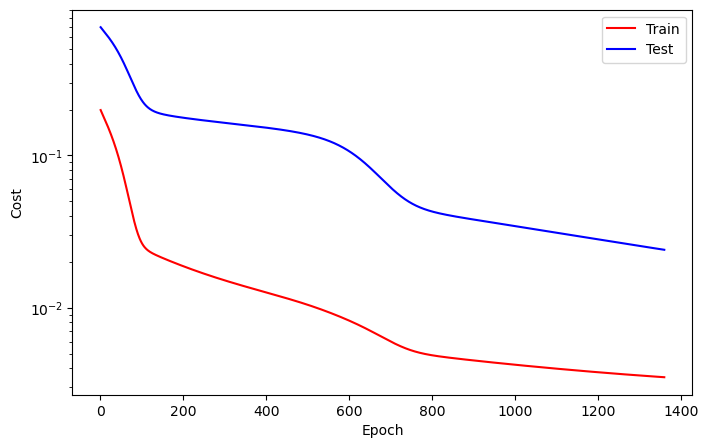

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1361
Train_cost  = 0.0035 | Test_cost  = 0.0240 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1362
Train_cost  = 0.0035 | Test_cost  = 0.0240 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1363
Train_cost  = 0.0035 | Test_cost  = 0.0240 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1364
Train_cost  = 0.0035 | Test_cost  = 0.0239 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1365
Train_cost  = 0.0035 | Test_cost  = 0.0239 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1366
Train_cost  = 0.0035 | Test_cost  = 0.0239 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1367
Train_cost  = 0.0035 | Test_cost  = 0.0239 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1368
Train_cost  = 0.0035 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1369
Train_cost  = 0.0035 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1370
Train_cost  = 0.0035 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1371
Train_cost  = 0.0035 | Test_cost  = 0.0238 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1372
Train_cost  = 0.0035 | Test_cost  = 0.0237 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1373
Train_cost  = 0.0035 | Test_cost  = 0.0237 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1374
Train_cost  = 0.0035 | Test_cost  = 0.0237 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1375
Train_cost  = 0.0035 | Test_cost  = 0.0237 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1376
Train_cost  = 0.0035 | Test_cost  = 0.0237 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1377
Train_cost  = 0.0035 | Test_cost  = 0.0236 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1378
Train_cost  = 0.0035 | Test_cost  = 0.0236 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1379
Train_cost  = 0.0035 | Test_cost  = 0.0236 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1380
Train_cost  = 0.0035 | Test_cost  = 0.0236 | 


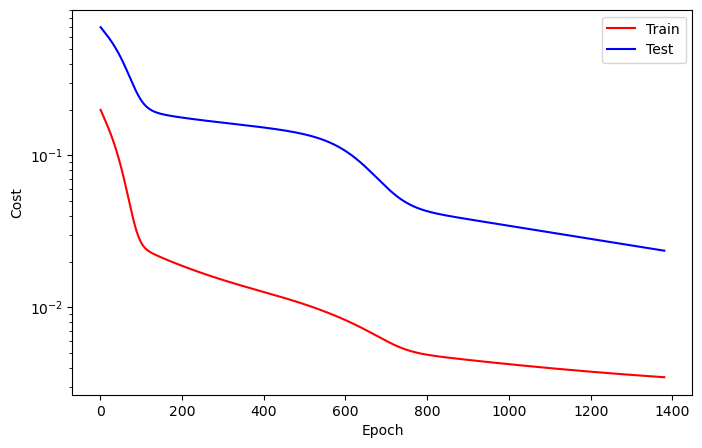

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1381
Train_cost  = 0.0035 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1382
Train_cost  = 0.0035 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1383
Train_cost  = 0.0035 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1384
Train_cost  = 0.0035 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1385
Train_cost  = 0.0035 | Test_cost  = 0.0235 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1386
Train_cost  = 0.0035 | Test_cost  = 0.0234 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1387
Train_cost  = 0.0035 | Test_cost  = 0.0234 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1388
Train_cost  = 0.0035 | Test_cost  = 0.0234 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1389
Train_cost  = 0.0035 | Test_cost  = 0.0234 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1390
Train_cost  = 0.0035 | Test_cost  = 0.0233 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1391
Train_cost  = 0.0035 | Test_cost  = 0.0233 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1392
Train_cost  = 0.0035 | Test_cost  = 0.0233 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1393
Train_cost  = 0.0034 | Test_cost  = 0.0233 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1394
Train_cost  = 0.0034 | Test_cost  = 0.0233 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1395
Train_cost  = 0.0034 | Test_cost  = 0.0232 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1396
Train_cost  = 0.0034 | Test_cost  = 0.0232 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1397
Train_cost  = 0.0034 | Test_cost  = 0.0232 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1398
Train_cost  = 0.0034 | Test_cost  = 0.0232 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1399
Train_cost  = 0.0034 | Test_cost  = 0.0231 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1400
Train_cost  = 0.0034 | Test_cost  = 0.0231 | 


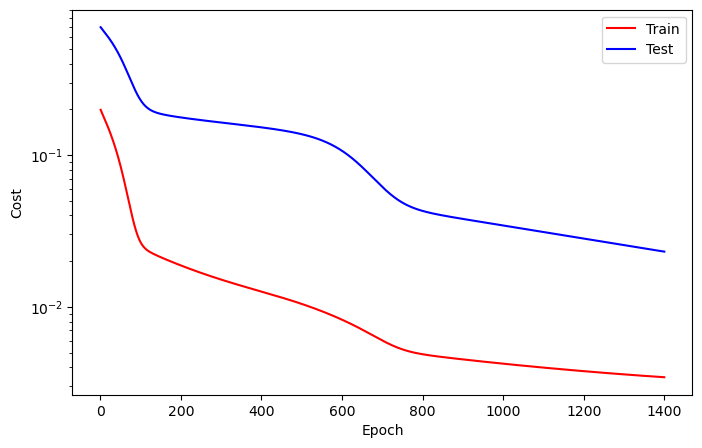

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1401
Train_cost  = 0.0034 | Test_cost  = 0.0231 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1402
Train_cost  = 0.0034 | Test_cost  = 0.0231 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1403
Train_cost  = 0.0034 | Test_cost  = 0.0231 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1404
Train_cost  = 0.0034 | Test_cost  = 0.0230 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1405
Train_cost  = 0.0034 | Test_cost  = 0.0230 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1406
Train_cost  = 0.0034 | Test_cost  = 0.0230 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1407
Train_cost  = 0.0034 | Test_cost  = 0.0230 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1408
Train_cost  = 0.0034 | Test_cost  = 0.0229 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1409
Train_cost  = 0.0034 | Test_cost  = 0.0229 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1410
Train_cost  = 0.0034 | Test_cost  = 0.0229 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1411
Train_cost  = 0.0034 | Test_cost  = 0.0229 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1412
Train_cost  = 0.0034 | Test_cost  = 0.0229 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1413
Train_cost  = 0.0034 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1414
Train_cost  = 0.0034 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1415
Train_cost  = 0.0034 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1416
Train_cost  = 0.0034 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1417
Train_cost  = 0.0034 | Test_cost  = 0.0228 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1418
Train_cost  = 0.0034 | Test_cost  = 0.0227 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1419
Train_cost  = 0.0034 | Test_cost  = 0.0227 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1420
Train_cost  = 0.0034 | Test_cost  = 0.0227 | 


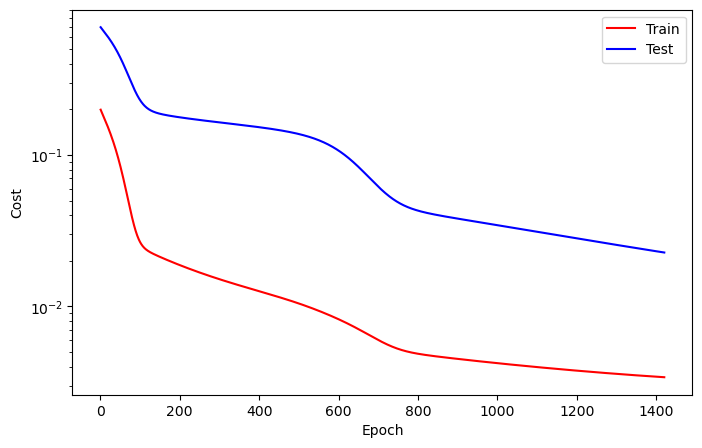

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1421
Train_cost  = 0.0034 | Test_cost  = 0.0227 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1422
Train_cost  = 0.0034 | Test_cost  = 0.0226 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1423
Train_cost  = 0.0034 | Test_cost  = 0.0226 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1424
Train_cost  = 0.0034 | Test_cost  = 0.0226 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1425
Train_cost  = 0.0034 | Test_cost  = 0.0226 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1426
Train_cost  = 0.0034 | Test_cost  = 0.0226 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1427
Train_cost  = 0.0034 | Test_cost  = 0.0225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1428
Train_cost  = 0.0034 | Test_cost  = 0.0225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1429
Train_cost  = 0.0034 | Test_cost  = 0.0225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1430
Train_cost  = 0.0034 | Test_cost  = 0.0225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1431
Train_cost  = 0.0034 | Test_cost  = 0.0225 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1432
Train_cost  = 0.0034 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1433
Train_cost  = 0.0034 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1434
Train_cost  = 0.0034 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1435
Train_cost  = 0.0034 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1436
Train_cost  = 0.0034 | Test_cost  = 0.0224 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1437
Train_cost  = 0.0034 | Test_cost  = 0.0223 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1438
Train_cost  = 0.0034 | Test_cost  = 0.0223 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1439
Train_cost  = 0.0034 | Test_cost  = 0.0223 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1440
Train_cost  = 0.0034 | Test_cost  = 0.0223 | 


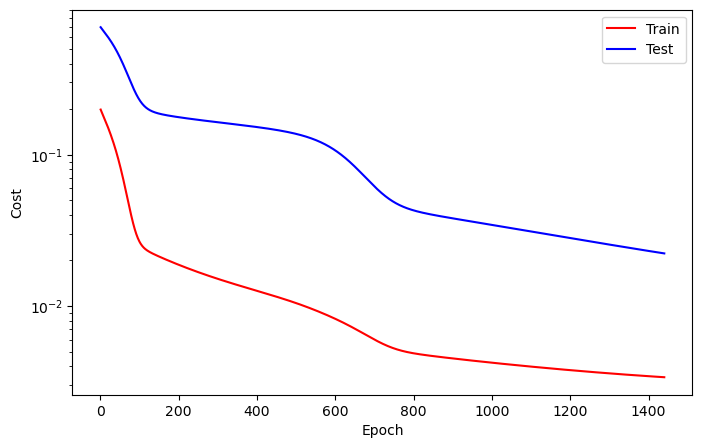

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1441
Train_cost  = 0.0034 | Test_cost  = 0.0223 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1442
Train_cost  = 0.0034 | Test_cost  = 0.0222 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1443
Train_cost  = 0.0034 | Test_cost  = 0.0222 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1444
Train_cost  = 0.0034 | Test_cost  = 0.0222 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1445
Train_cost  = 0.0034 | Test_cost  = 0.0222 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1446
Train_cost  = 0.0034 | Test_cost  = 0.0222 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1447
Train_cost  = 0.0034 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1448
Train_cost  = 0.0034 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1449
Train_cost  = 0.0034 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1450
Train_cost  = 0.0034 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1451
Train_cost  = 0.0034 | Test_cost  = 0.0221 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1452
Train_cost  = 0.0034 | Test_cost  = 0.0220 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1453
Train_cost  = 0.0034 | Test_cost  = 0.0220 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1454
Train_cost  = 0.0034 | Test_cost  = 0.0220 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1455
Train_cost  = 0.0034 | Test_cost  = 0.0220 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1456
Train_cost  = 0.0034 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1457
Train_cost  = 0.0034 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1458
Train_cost  = 0.0034 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1459
Train_cost  = 0.0034 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1460
Train_cost  = 0.0034 | Test_cost  = 0.0219 | 


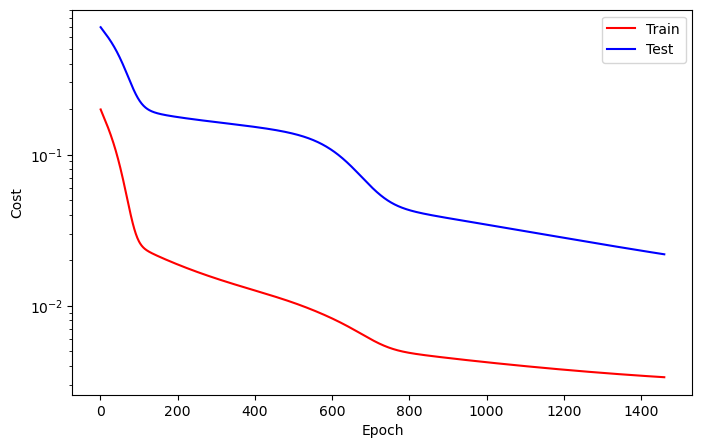

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1461
Train_cost  = 0.0034 | Test_cost  = 0.0219 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1462
Train_cost  = 0.0034 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1463
Train_cost  = 0.0034 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1464
Train_cost  = 0.0034 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1465
Train_cost  = 0.0034 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1466
Train_cost  = 0.0034 | Test_cost  = 0.0218 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1467
Train_cost  = 0.0034 | Test_cost  = 0.0217 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1468
Train_cost  = 0.0034 | Test_cost  = 0.0217 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1469
Train_cost  = 0.0034 | Test_cost  = 0.0217 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1470
Train_cost  = 0.0033 | Test_cost  = 0.0217 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1471
Train_cost  = 0.0033 | Test_cost  = 0.0217 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1472
Train_cost  = 0.0033 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1473
Train_cost  = 0.0033 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1474
Train_cost  = 0.0033 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1475
Train_cost  = 0.0033 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1476
Train_cost  = 0.0033 | Test_cost  = 0.0216 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1477
Train_cost  = 0.0033 | Test_cost  = 0.0215 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1478
Train_cost  = 0.0033 | Test_cost  = 0.0215 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1479
Train_cost  = 0.0033 | Test_cost  = 0.0215 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1480
Train_cost  = 0.0033 | Test_cost  = 0.0215 | 


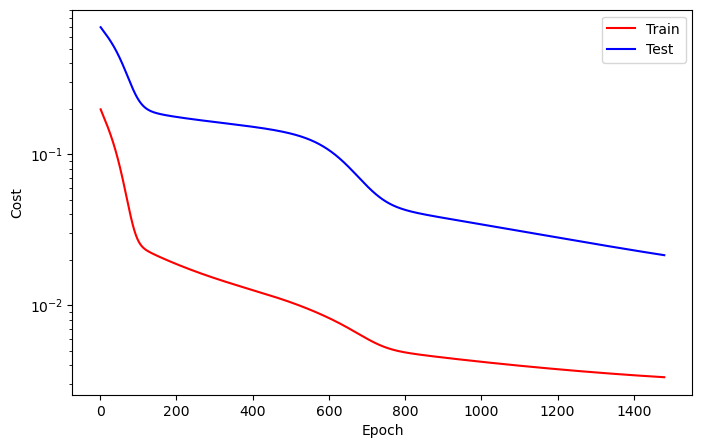

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1481
Train_cost  = 0.0033 | Test_cost  = 0.0215 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1482
Train_cost  = 0.0033 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1483
Train_cost  = 0.0033 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1484
Train_cost  = 0.0033 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1485
Train_cost  = 0.0033 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1486
Train_cost  = 0.0033 | Test_cost  = 0.0214 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1487
Train_cost  = 0.0033 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1488
Train_cost  = 0.0033 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1489
Train_cost  = 0.0033 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1490
Train_cost  = 0.0033 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1491
Train_cost  = 0.0033 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1492
Train_cost  = 0.0033 | Test_cost  = 0.0213 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1493
Train_cost  = 0.0033 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1494
Train_cost  = 0.0033 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1495
Train_cost  = 0.0033 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1496
Train_cost  = 0.0033 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1497
Train_cost  = 0.0033 | Test_cost  = 0.0212 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1498
Train_cost  = 0.0033 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1499
Train_cost  = 0.0033 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1500
Train_cost  = 0.0033 | Test_cost  = 0.0211 | 


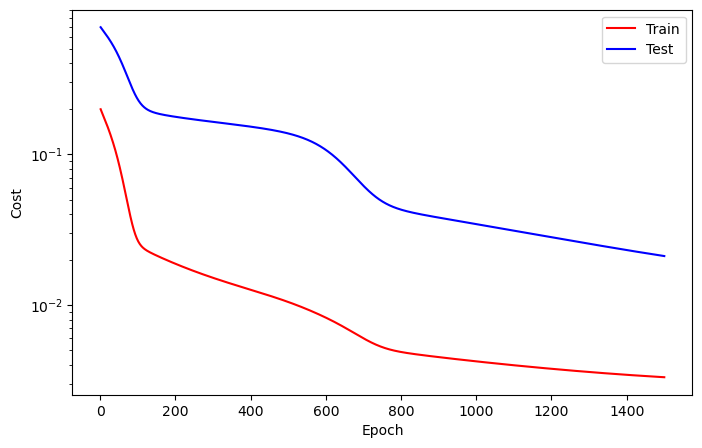

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1501
Train_cost  = 0.0033 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1502
Train_cost  = 0.0033 | Test_cost  = 0.0211 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1503
Train_cost  = 0.0033 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1504
Train_cost  = 0.0033 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1505
Train_cost  = 0.0033 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1506
Train_cost  = 0.0033 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1507
Train_cost  = 0.0033 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1508
Train_cost  = 0.0033 | Test_cost  = 0.0210 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1509
Train_cost  = 0.0033 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1510
Train_cost  = 0.0033 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1511
Train_cost  = 0.0033 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1512
Train_cost  = 0.0033 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1513
Train_cost  = 0.0033 | Test_cost  = 0.0209 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1514
Train_cost  = 0.0033 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1515
Train_cost  = 0.0033 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1516
Train_cost  = 0.0033 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1517
Train_cost  = 0.0033 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1518
Train_cost  = 0.0033 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1519
Train_cost  = 0.0033 | Test_cost  = 0.0208 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1520
Train_cost  = 0.0033 | Test_cost  = 0.0207 | 


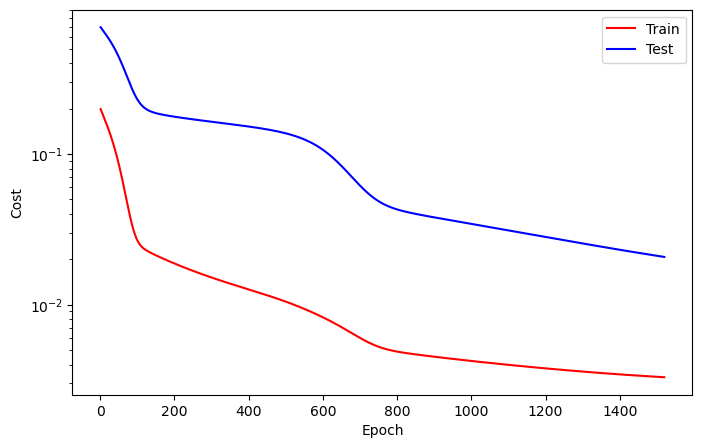

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1521
Train_cost  = 0.0033 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1522
Train_cost  = 0.0033 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1523
Train_cost  = 0.0033 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1524
Train_cost  = 0.0033 | Test_cost  = 0.0207 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1525
Train_cost  = 0.0033 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1526
Train_cost  = 0.0033 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1527
Train_cost  = 0.0033 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1528
Train_cost  = 0.0033 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1529
Train_cost  = 0.0033 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1530
Train_cost  = 0.0033 | Test_cost  = 0.0206 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1531
Train_cost  = 0.0033 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1532
Train_cost  = 0.0033 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1533
Train_cost  = 0.0033 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1534
Train_cost  = 0.0033 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1535
Train_cost  = 0.0033 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1536
Train_cost  = 0.0033 | Test_cost  = 0.0205 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1537
Train_cost  = 0.0033 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1538
Train_cost  = 0.0033 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1539
Train_cost  = 0.0033 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1540
Train_cost  = 0.0033 | Test_cost  = 0.0204 | 


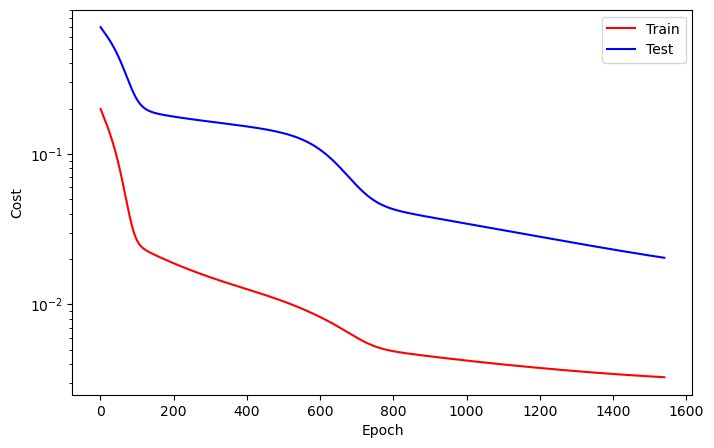

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1541
Train_cost  = 0.0033 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1542
Train_cost  = 0.0033 | Test_cost  = 0.0204 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1543
Train_cost  = 0.0033 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1544
Train_cost  = 0.0033 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1545
Train_cost  = 0.0033 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1546
Train_cost  = 0.0033 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1547
Train_cost  = 0.0033 | Test_cost  = 0.0203 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1548
Train_cost  = 0.0033 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1549
Train_cost  = 0.0033 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1550
Train_cost  = 0.0033 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1551
Train_cost  = 0.0033 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1552
Train_cost  = 0.0033 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1553
Train_cost  = 0.0033 | Test_cost  = 0.0202 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1554
Train_cost  = 0.0033 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1555
Train_cost  = 0.0033 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1556
Train_cost  = 0.0033 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1557
Train_cost  = 0.0033 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1558
Train_cost  = 0.0033 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1559
Train_cost  = 0.0033 | Test_cost  = 0.0201 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1560
Train_cost  = 0.0033 | Test_cost  = 0.0200 | 


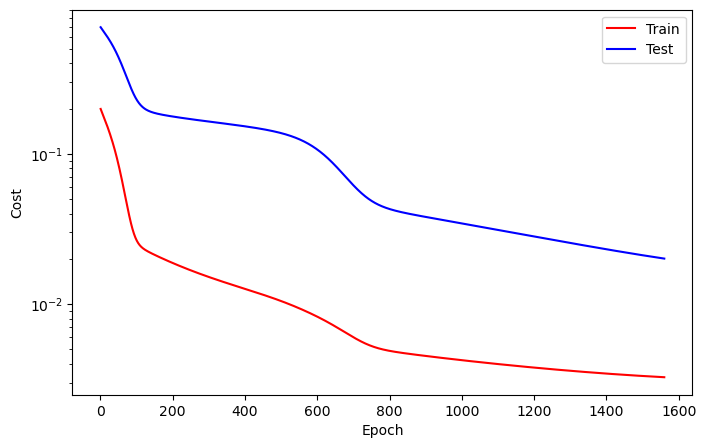

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1561
Train_cost  = 0.0033 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1562
Train_cost  = 0.0033 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1563
Train_cost  = 0.0033 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1564
Train_cost  = 0.0032 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1565
Train_cost  = 0.0032 | Test_cost  = 0.0200 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1566
Train_cost  = 0.0032 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1567
Train_cost  = 0.0032 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1568
Train_cost  = 0.0032 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1569
Train_cost  = 0.0032 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1570
Train_cost  = 0.0032 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1571
Train_cost  = 0.0032 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1572
Train_cost  = 0.0032 | Test_cost  = 0.0199 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1573
Train_cost  = 0.0032 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1574
Train_cost  = 0.0032 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1575
Train_cost  = 0.0032 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1576
Train_cost  = 0.0032 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1577
Train_cost  = 0.0032 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1578
Train_cost  = 0.0032 | Test_cost  = 0.0198 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1579
Train_cost  = 0.0032 | Test_cost  = 0.0197 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1580
Train_cost  = 0.0032 | Test_cost  = 0.0197 | 


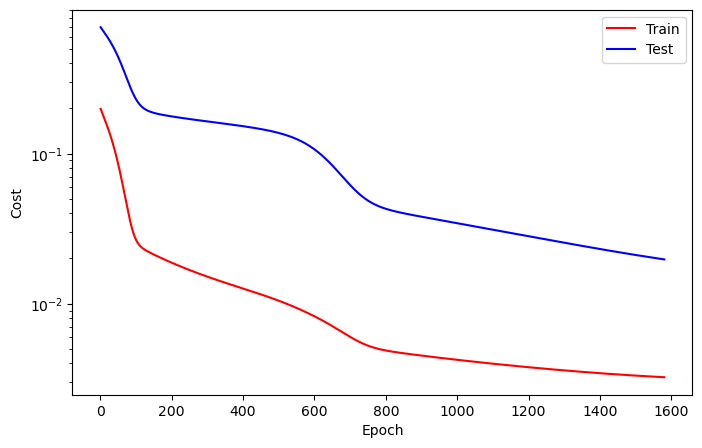

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1581
Train_cost  = 0.0032 | Test_cost  = 0.0197 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1582
Train_cost  = 0.0032 | Test_cost  = 0.0197 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1583
Train_cost  = 0.0032 | Test_cost  = 0.0197 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1584
Train_cost  = 0.0032 | Test_cost  = 0.0197 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1585
Train_cost  = 0.0032 | Test_cost  = 0.0196 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1586
Train_cost  = 0.0032 | Test_cost  = 0.0196 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1587
Train_cost  = 0.0032 | Test_cost  = 0.0196 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1588
Train_cost  = 0.0032 | Test_cost  = 0.0196 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1589
Train_cost  = 0.0032 | Test_cost  = 0.0196 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1590
Train_cost  = 0.0032 | Test_cost  = 0.0196 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1591
Train_cost  = 0.0032 | Test_cost  = 0.0195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1592
Train_cost  = 0.0032 | Test_cost  = 0.0195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1593
Train_cost  = 0.0032 | Test_cost  = 0.0195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1594
Train_cost  = 0.0032 | Test_cost  = 0.0195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1595
Train_cost  = 0.0032 | Test_cost  = 0.0195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1596
Train_cost  = 0.0032 | Test_cost  = 0.0195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1597
Train_cost  = 0.0032 | Test_cost  = 0.0195 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1598
Train_cost  = 0.0032 | Test_cost  = 0.0194 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1599
Train_cost  = 0.0032 | Test_cost  = 0.0194 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1600
Train_cost  = 0.0032 | Test_cost  = 0.0194 | 


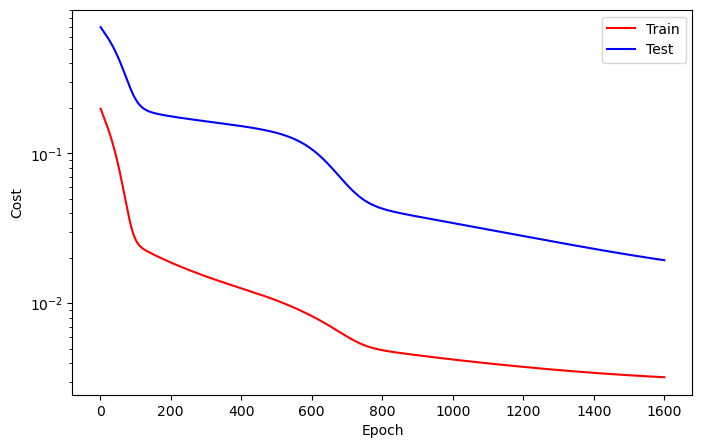

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1601
Train_cost  = 0.0032 | Test_cost  = 0.0194 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1602
Train_cost  = 0.0032 | Test_cost  = 0.0194 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1603
Train_cost  = 0.0032 | Test_cost  = 0.0194 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1604
Train_cost  = 0.0032 | Test_cost  = 0.0193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1605
Train_cost  = 0.0032 | Test_cost  = 0.0193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1606
Train_cost  = 0.0032 | Test_cost  = 0.0193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1607
Train_cost  = 0.0032 | Test_cost  = 0.0193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1608
Train_cost  = 0.0032 | Test_cost  = 0.0193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1609
Train_cost  = 0.0032 | Test_cost  = 0.0193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1610
Train_cost  = 0.0032 | Test_cost  = 0.0193 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1611
Train_cost  = 0.0032 | Test_cost  = 0.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1612
Train_cost  = 0.0032 | Test_cost  = 0.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1613
Train_cost  = 0.0032 | Test_cost  = 0.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1614
Train_cost  = 0.0032 | Test_cost  = 0.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1615
Train_cost  = 0.0032 | Test_cost  = 0.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1616
Train_cost  = 0.0032 | Test_cost  = 0.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1617
Train_cost  = 0.0032 | Test_cost  = 0.0192 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1618
Train_cost  = 0.0032 | Test_cost  = 0.0191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1619
Train_cost  = 0.0032 | Test_cost  = 0.0191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1620
Train_cost  = 0.0032 | Test_cost  = 0.0191 | 


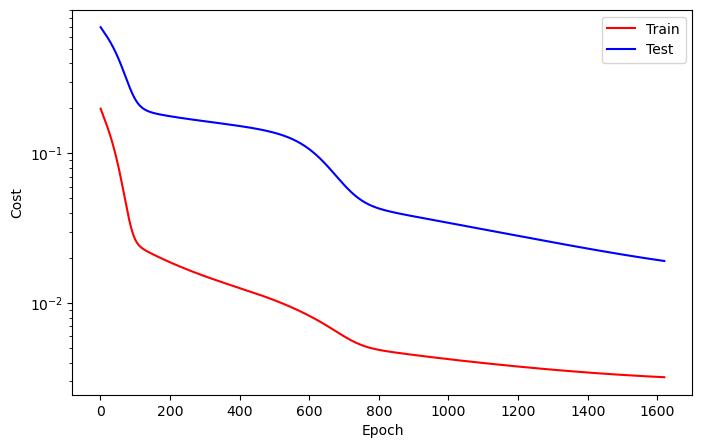

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1621
Train_cost  = 0.0032 | Test_cost  = 0.0191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1622
Train_cost  = 0.0032 | Test_cost  = 0.0191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1623
Train_cost  = 0.0032 | Test_cost  = 0.0191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1624
Train_cost  = 0.0032 | Test_cost  = 0.0191 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1625
Train_cost  = 0.0032 | Test_cost  = 0.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1626
Train_cost  = 0.0032 | Test_cost  = 0.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1627
Train_cost  = 0.0032 | Test_cost  = 0.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1628
Train_cost  = 0.0032 | Test_cost  = 0.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1629
Train_cost  = 0.0032 | Test_cost  = 0.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1630
Train_cost  = 0.0032 | Test_cost  = 0.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1631
Train_cost  = 0.0032 | Test_cost  = 0.0190 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1632
Train_cost  = 0.0032 | Test_cost  = 0.0189 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1633
Train_cost  = 0.0032 | Test_cost  = 0.0189 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1634
Train_cost  = 0.0032 | Test_cost  = 0.0189 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1635
Train_cost  = 0.0032 | Test_cost  = 0.0189 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1636
Train_cost  = 0.0032 | Test_cost  = 0.0189 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1637
Train_cost  = 0.0032 | Test_cost  = 0.0189 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1638
Train_cost  = 0.0032 | Test_cost  = 0.0189 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1639
Train_cost  = 0.0032 | Test_cost  = 0.0188 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1640
Train_cost  = 0.0032 | Test_cost  = 0.0188 | 


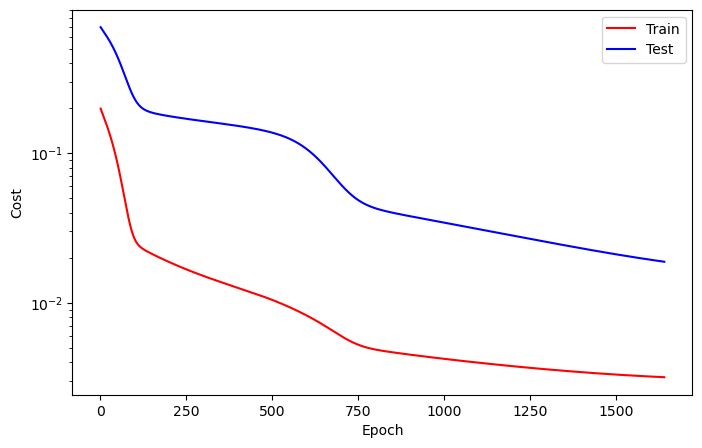

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1641
Train_cost  = 0.0032 | Test_cost  = 0.0188 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1642
Train_cost  = 0.0032 | Test_cost  = 0.0188 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1643
Train_cost  = 0.0032 | Test_cost  = 0.0188 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1644
Train_cost  = 0.0032 | Test_cost  = 0.0188 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1645
Train_cost  = 0.0032 | Test_cost  = 0.0188 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1646
Train_cost  = 0.0032 | Test_cost  = 0.0187 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1647
Train_cost  = 0.0032 | Test_cost  = 0.0187 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1648
Train_cost  = 0.0032 | Test_cost  = 0.0187 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1649
Train_cost  = 0.0032 | Test_cost  = 0.0187 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1650
Train_cost  = 0.0032 | Test_cost  = 0.0187 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1651
Train_cost  = 0.0032 | Test_cost  = 0.0187 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1652
Train_cost  = 0.0032 | Test_cost  = 0.0187 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1653
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1654
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1655
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1656
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1657
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1658
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1659
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1660
Train_cost  = 0.0032 | Test_cost  = 0.0186 | 


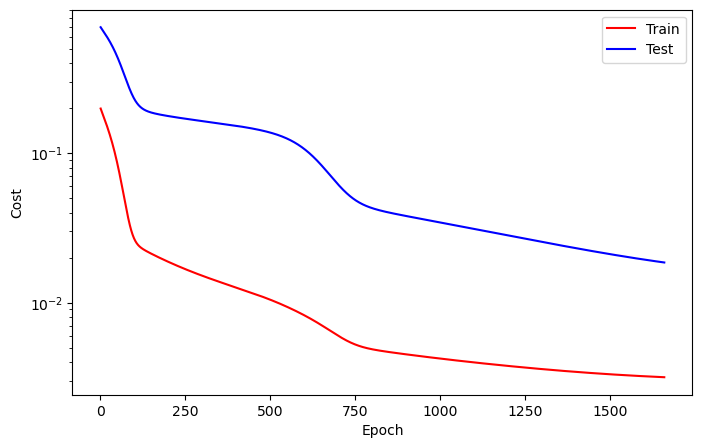

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1661
Train_cost  = 0.0032 | Test_cost  = 0.0185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1662
Train_cost  = 0.0032 | Test_cost  = 0.0185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1663
Train_cost  = 0.0032 | Test_cost  = 0.0185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1664
Train_cost  = 0.0032 | Test_cost  = 0.0185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1665
Train_cost  = 0.0032 | Test_cost  = 0.0185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1666
Train_cost  = 0.0032 | Test_cost  = 0.0185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1667
Train_cost  = 0.0032 | Test_cost  = 0.0185 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1668
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1669
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1670
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1671
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1672
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1673
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1674
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1675
Train_cost  = 0.0032 | Test_cost  = 0.0184 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1676
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1677
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1678
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1679
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1680
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


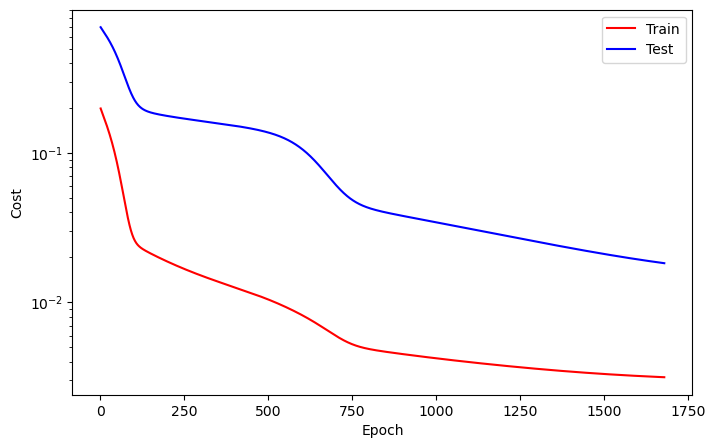

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1681
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1682
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1683
Train_cost  = 0.0032 | Test_cost  = 0.0183 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1684
Train_cost  = 0.0032 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1685
Train_cost  = 0.0032 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1686
Train_cost  = 0.0031 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1687
Train_cost  = 0.0031 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1688
Train_cost  = 0.0031 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1689
Train_cost  = 0.0031 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1690
Train_cost  = 0.0031 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1691
Train_cost  = 0.0031 | Test_cost  = 0.0182 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1692
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1693
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1694
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1695
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1696
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1697
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1698
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1699
Train_cost  = 0.0031 | Test_cost  = 0.0181 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1700
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


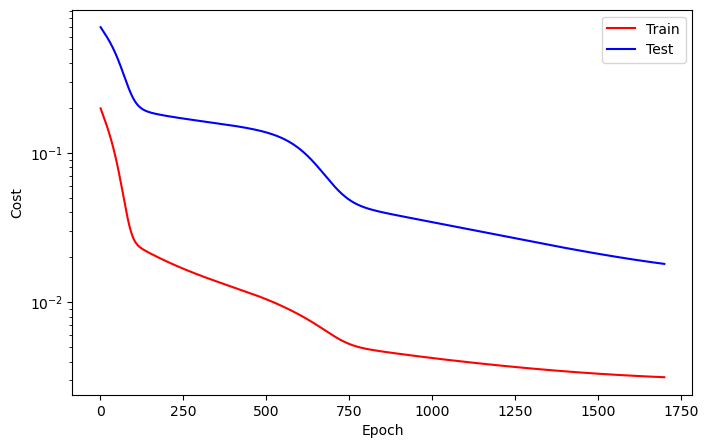

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1701
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1702
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1703
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1704
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1705
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1706
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1707
Train_cost  = 0.0031 | Test_cost  = 0.0180 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1708
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1709
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1710
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1711
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1712
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1713
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1714
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1715
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1716
Train_cost  = 0.0031 | Test_cost  = 0.0179 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1717
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1718
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1719
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1720
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


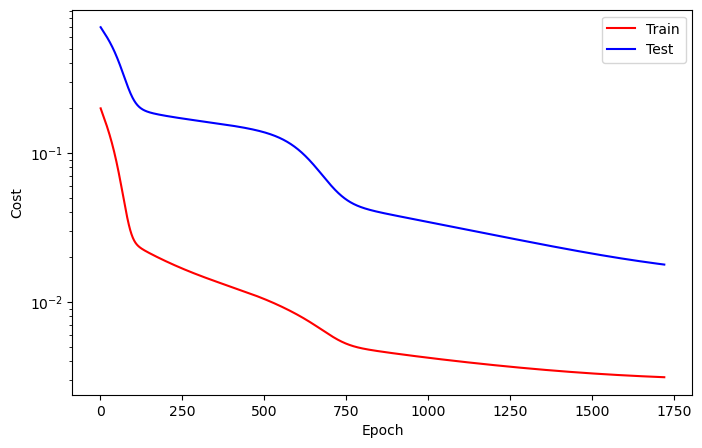

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1721
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1722
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1723
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1724
Train_cost  = 0.0031 | Test_cost  = 0.0178 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1725
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1726
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1727
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1728
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1729
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1730
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1731
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1732
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1733
Train_cost  = 0.0031 | Test_cost  = 0.0177 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1734
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1735
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1736
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1737
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1738
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1739
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1740
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


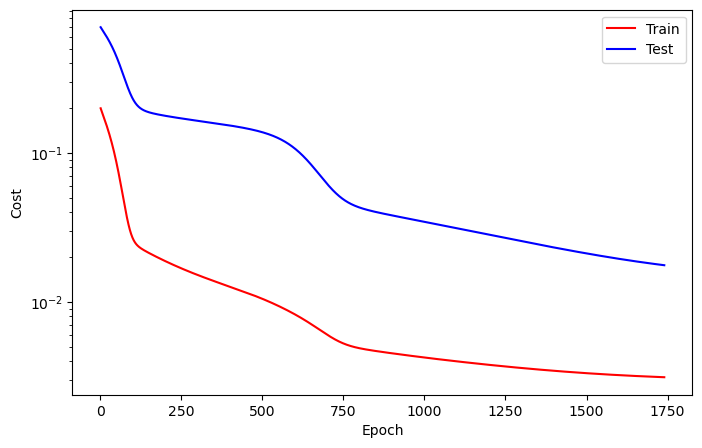

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1741
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1742
Train_cost  = 0.0031 | Test_cost  = 0.0176 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1743
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1744
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1745
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1746
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1747
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1748
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1749
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1750
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1751
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1752
Train_cost  = 0.0031 | Test_cost  = 0.0175 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1753
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1754
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1755
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1756
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1757
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1758
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1759
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1760
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


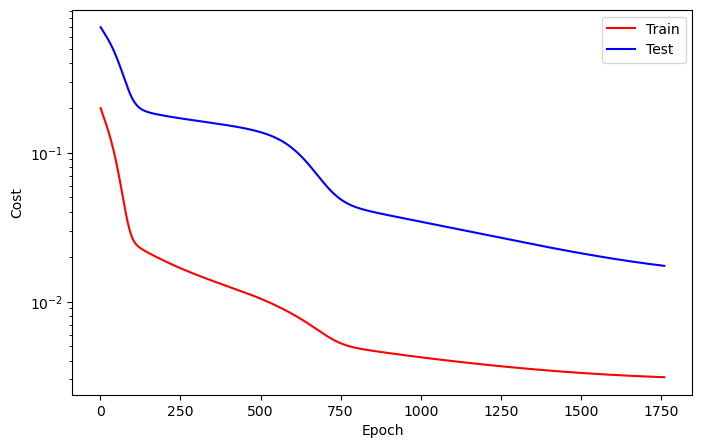

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1761
Train_cost  = 0.0031 | Test_cost  = 0.0174 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1762
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1763
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1764
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1765
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1766
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1767
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1768
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1769
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1770
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1771
Train_cost  = 0.0031 | Test_cost  = 0.0173 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1772
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1773
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1774
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1775
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1776
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1777
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1778
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1779
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1780
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


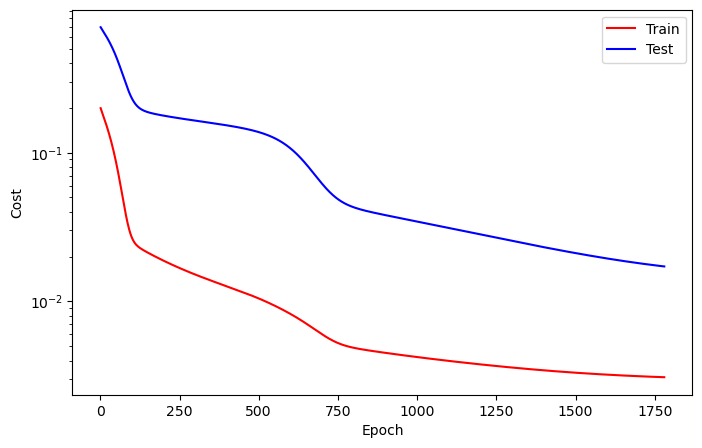

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1781
Train_cost  = 0.0031 | Test_cost  = 0.0172 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1782
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1783
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1784
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1785
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1786
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1787
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1788
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1789
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1790
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1791
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1792
Train_cost  = 0.0031 | Test_cost  = 0.0171 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1793
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1794
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1795
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1796
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1797
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1798
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1799
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1800
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


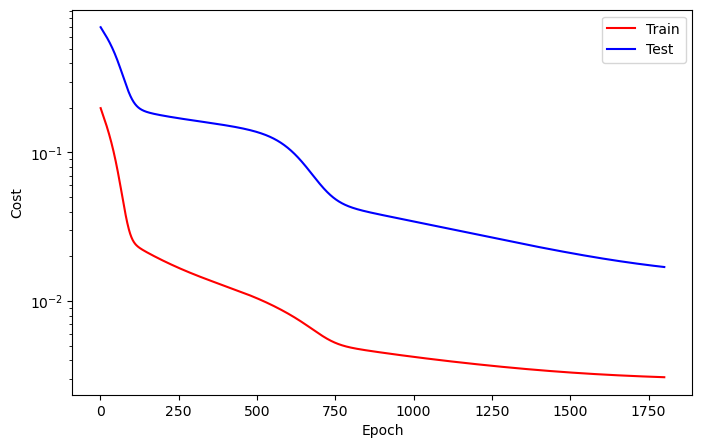

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1801
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1802
Train_cost  = 0.0031 | Test_cost  = 0.0170 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1803
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1804
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1805
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1806
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1807
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1808
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1809
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1810
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1811
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1812
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1813
Train_cost  = 0.0031 | Test_cost  = 0.0169 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1814
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1815
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1816
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1817
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1818
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1819
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1820
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


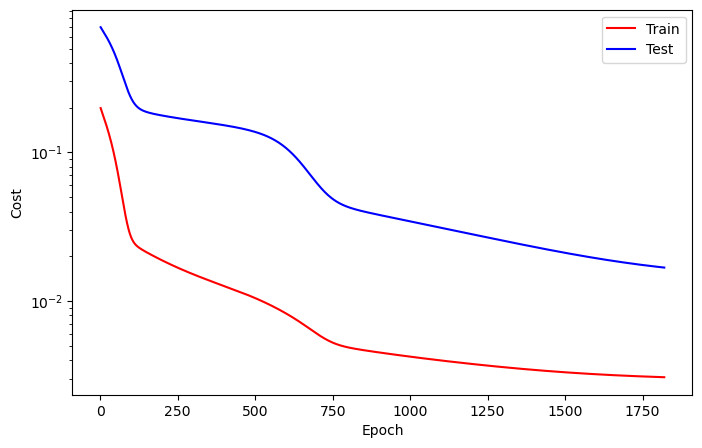

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1821
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1822
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1823
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1824
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1825
Train_cost  = 0.0031 | Test_cost  = 0.0168 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1826
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1827
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1828
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1829
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1830
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1831
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1832
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1833
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1834
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1835
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1836
Train_cost  = 0.0031 | Test_cost  = 0.0167 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1837
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1838
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1839
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1840
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


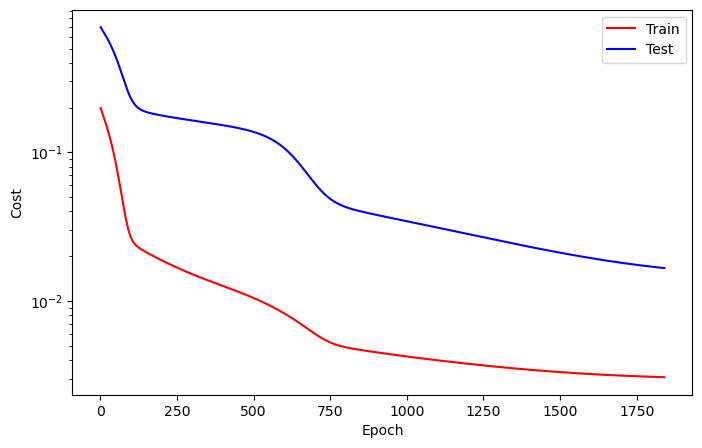

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1841
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1842
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1843
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1844
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1845
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1846
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1847
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1848
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1849
Train_cost  = 0.0031 | Test_cost  = 0.0166 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1850
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1851
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1852
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1853
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1854
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1855
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1856
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1857
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1858
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1859
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1860
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


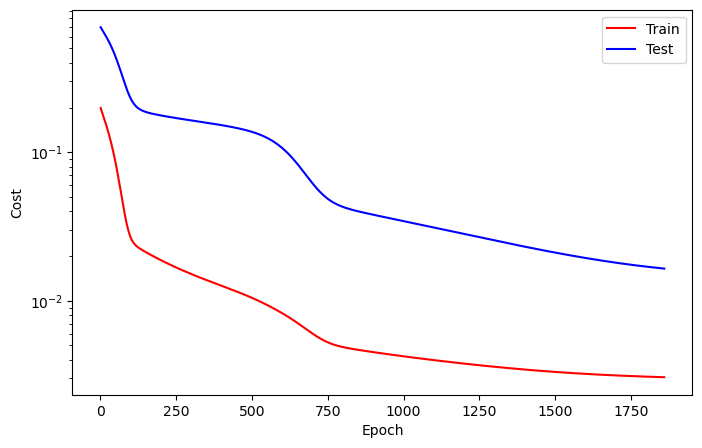

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1861
Train_cost  = 0.0031 | Test_cost  = 0.0165 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1862
Train_cost  = 0.0031 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1863
Train_cost  = 0.0031 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1864
Train_cost  = 0.0031 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1865
Train_cost  = 0.0031 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1866
Train_cost  = 0.0031 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1867
Train_cost  = 0.0031 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1868
Train_cost  = 0.0031 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1869
Train_cost  = 0.0030 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1870
Train_cost  = 0.0030 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1871
Train_cost  = 0.0030 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1872
Train_cost  = 0.0030 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1873
Train_cost  = 0.0030 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1874
Train_cost  = 0.0030 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1875
Train_cost  = 0.0030 | Test_cost  = 0.0164 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1876
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1877
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1878
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1879
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1880
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


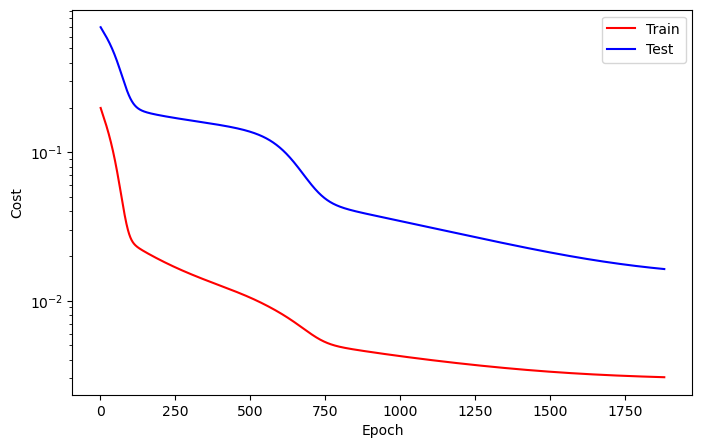

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1881
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1882
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1883
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1884
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1885
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1886
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1887
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1888
Train_cost  = 0.0030 | Test_cost  = 0.0163 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1889
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1890
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1891
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1892
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1893
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1894
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1895
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1896
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1897
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1898
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1899
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1900
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


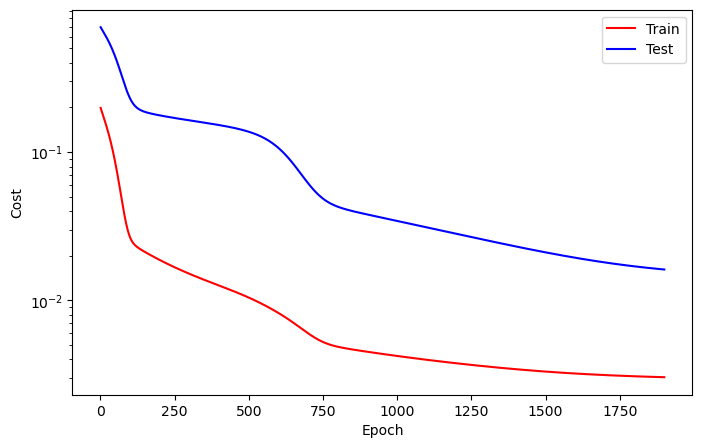

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1901
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1902
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1903
Train_cost  = 0.0030 | Test_cost  = 0.0162 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1904
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1905
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1906
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1907
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1908
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1909
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1910
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1911
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1912
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1913
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1914
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1915
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1916
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1917
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1918
Train_cost  = 0.0030 | Test_cost  = 0.0161 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1919
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1920
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


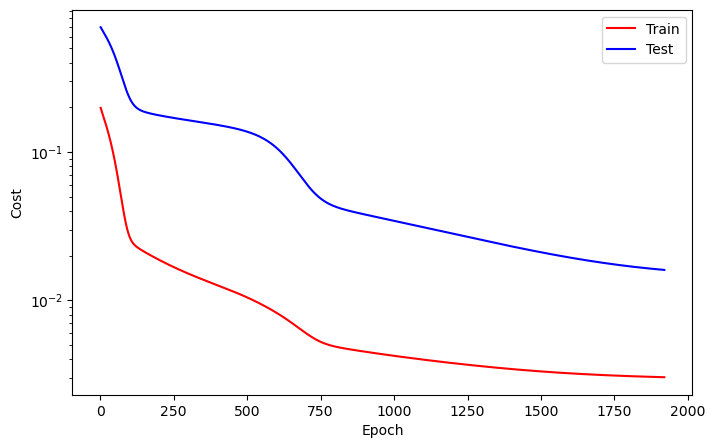

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1921
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1922
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1923
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1924
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1925
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1926
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1927
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1928
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1929
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1930
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1931
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1932
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1933
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1934
Train_cost  = 0.0030 | Test_cost  = 0.0160 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1935
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1936
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1937
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1938
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1939
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1940
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


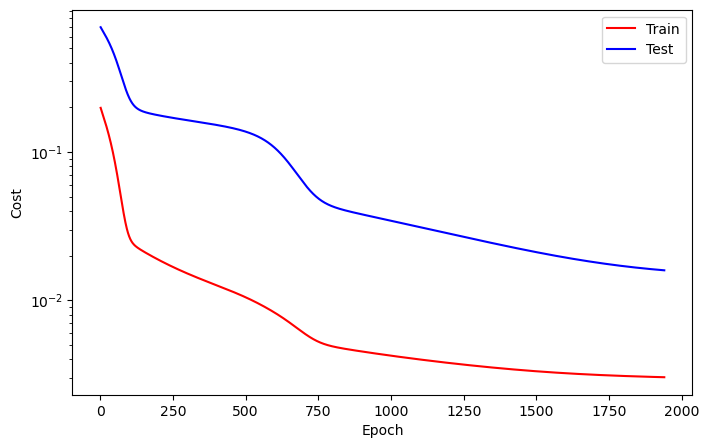

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1941
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1942
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1943
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1944
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1945
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1946
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1947
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1948
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1949
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1950
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1951
Train_cost  = 0.0030 | Test_cost  = 0.0159 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1952
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1953
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1954
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1955
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1956
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1957
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1958
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1959
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1960
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


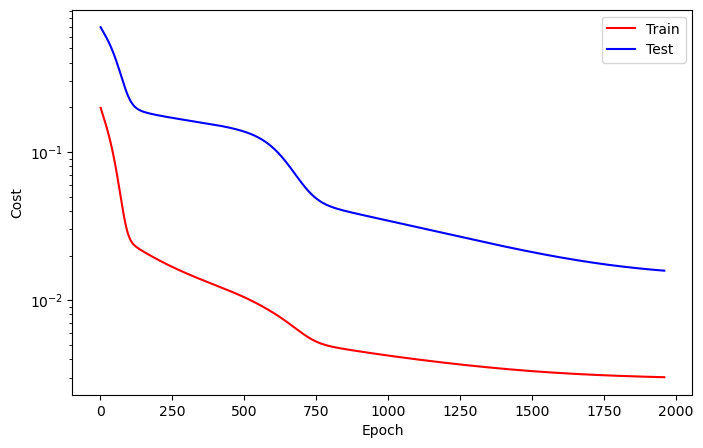

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1961
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1962
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1963
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1964
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1965
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1966
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1967
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1968
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1969
Train_cost  = 0.0030 | Test_cost  = 0.0158 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1970
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1971
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1972
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1973
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1974
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1975
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1976
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1977
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1978
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1979
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1980
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


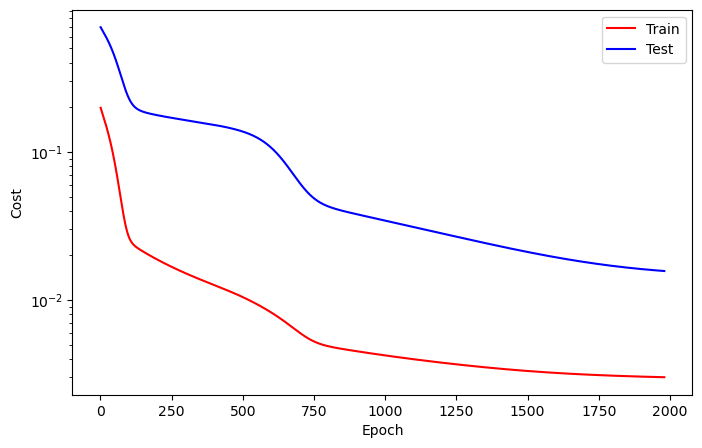

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1981
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1982
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1983
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1984
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1985
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1986
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1987
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1988
Train_cost  = 0.0030 | Test_cost  = 0.0157 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1989
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1990
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1991
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1992
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1993
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1994
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1995
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1996
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1997
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1998
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  1999
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2000
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


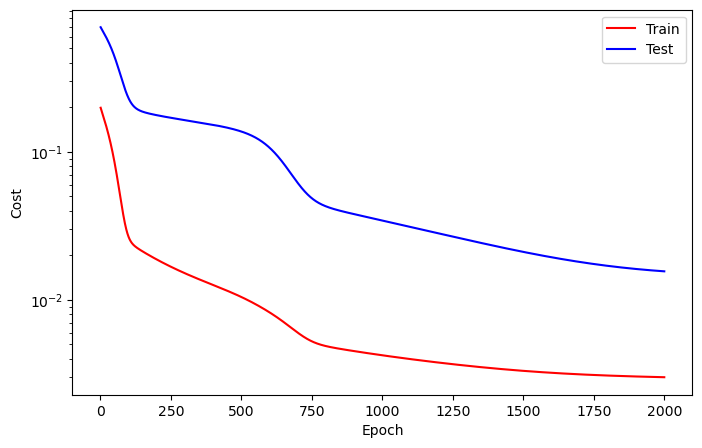

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2001
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2002
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2003
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2004
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2005
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2006
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2007
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2008
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2009
Train_cost  = 0.0030 | Test_cost  = 0.0156 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2010
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2011
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2012
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2013
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2014
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2015
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2016
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2017
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2018
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2019
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2020
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


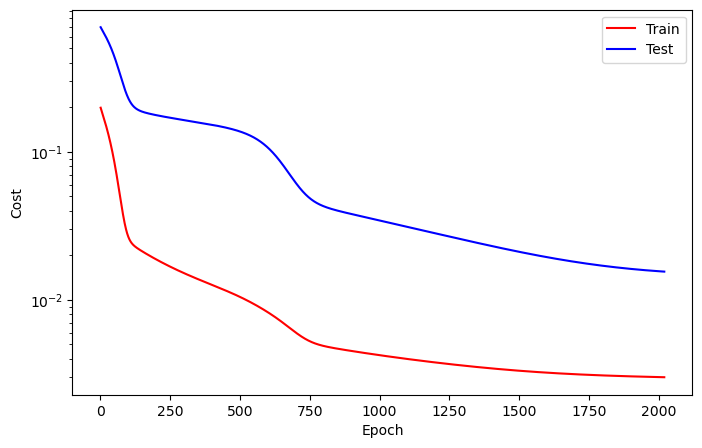

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2021
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2022
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2023
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2024
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2025
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2026
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2027
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2028
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2029
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2030
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2031
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2032
Train_cost  = 0.0030 | Test_cost  = 0.0155 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2033
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2034
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2035
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2036
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2037
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2038
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2039
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2040
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


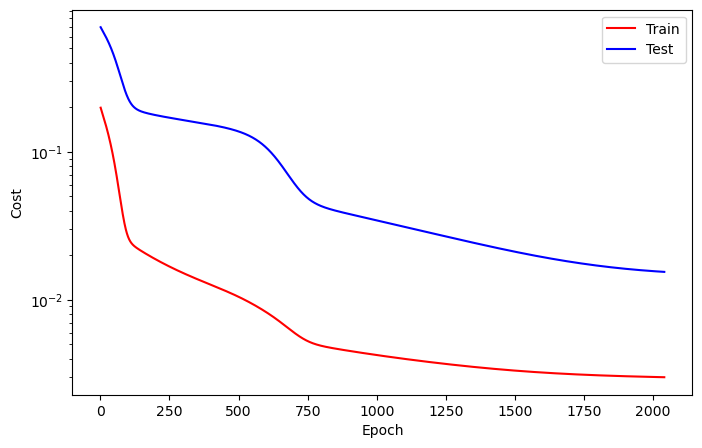

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2041
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2042
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2043
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2044
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2045
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2046
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2047
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2048
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2049
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2052
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2053
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2054
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2055
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2056
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2057
Train_cost  = 0.0030 | Test_cost  = 0.0154 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2058
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2059
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2060
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


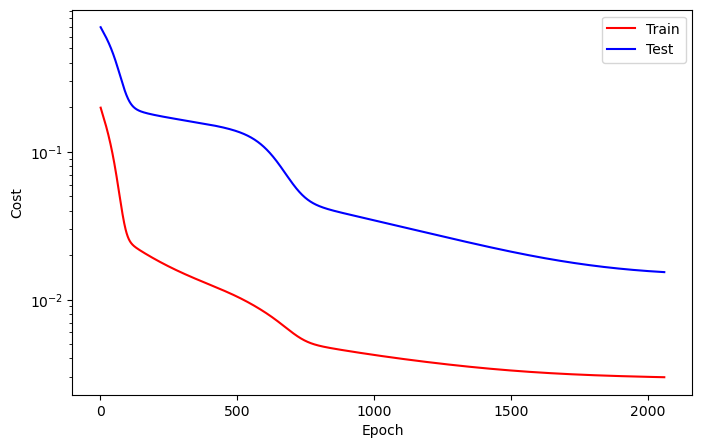

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2061
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2062
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2063
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2064
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2065
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2066
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2067
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2068
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2069
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2070
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2071
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2072
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2073
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2074
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2075
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2076
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2077
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2078
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2079
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2080
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


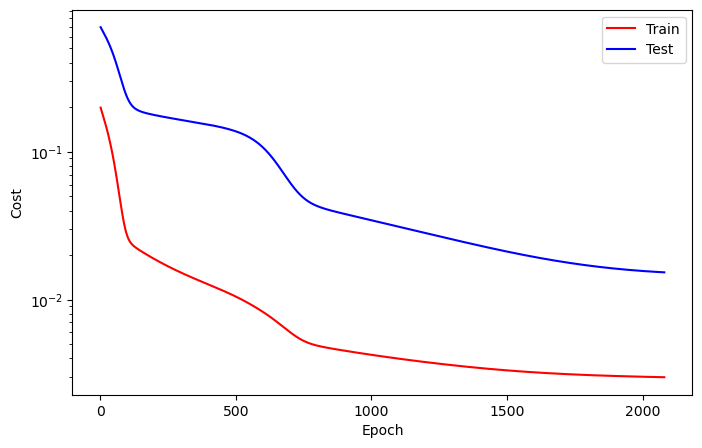

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2081
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2082
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2083
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2084
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2085
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2086
Train_cost  = 0.0030 | Test_cost  = 0.0153 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2087
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2088
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2089
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2090
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2091
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2092
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2093
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2094
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2095
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2096
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2097
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2098
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2099
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2100
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


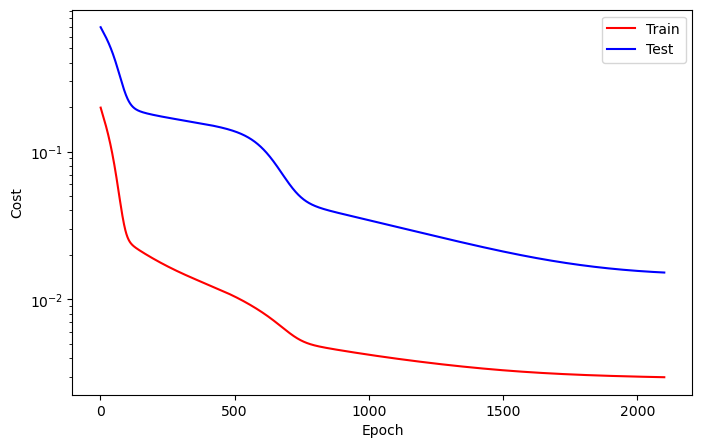

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2101
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2102
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2103
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2104
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2105
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2106
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2107
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2108
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2109
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2110
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2111
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2112
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2113
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2114
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2115
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2116
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2117
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2118
Train_cost  = 0.0030 | Test_cost  = 0.0152 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2119
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2120
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


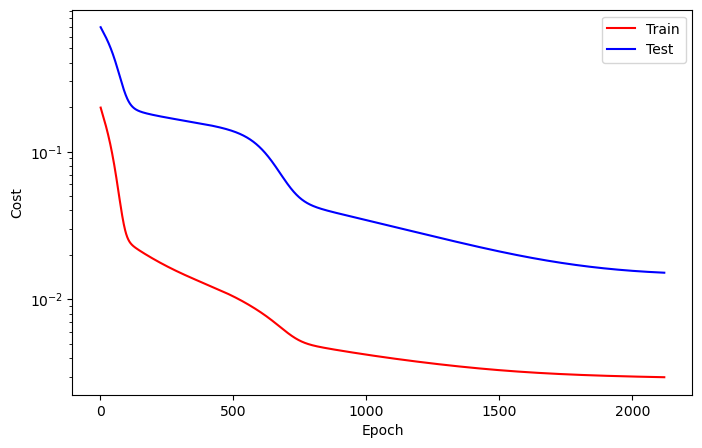

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2121
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2122
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2123
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2124
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2125
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2126
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2127
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2128
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2129
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2130
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2131
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2132
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2133
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2134
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2135
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2136
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2137
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2138
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2139
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2140
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


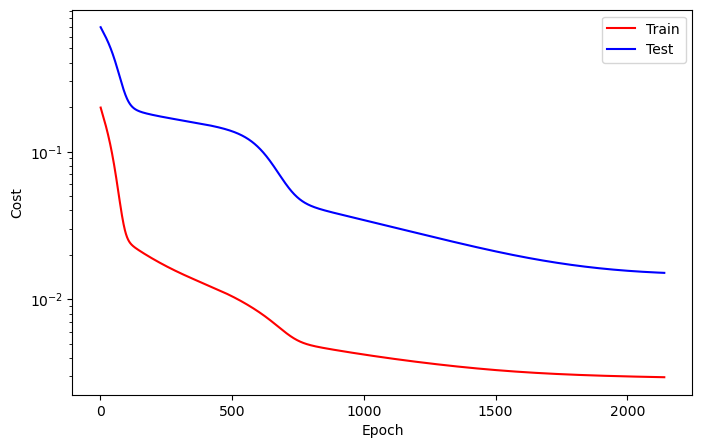

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2141
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2142
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2143
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2144
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2145
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2146
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2147
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2148
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2149
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2150
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2151
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2152
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2153
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2154
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2155
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2156
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2157
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2158
Train_cost  = 0.0030 | Test_cost  = 0.0151 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2159
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2160
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


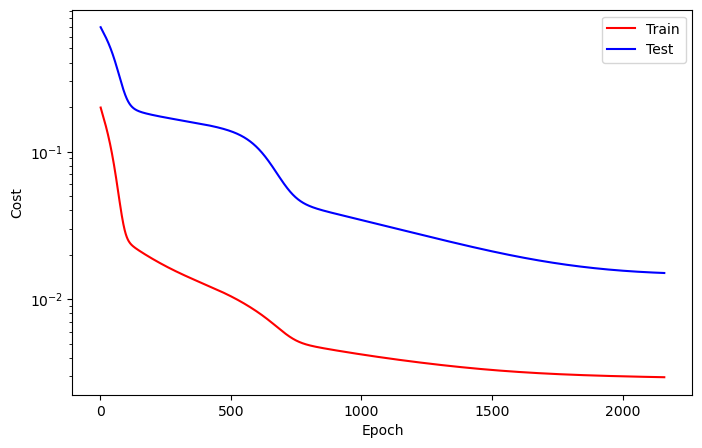

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2161
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2162
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2163
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2164
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2165
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2166
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2167
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2168
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2169
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2170
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2171
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2172
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2173
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2174
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2175
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2176
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2177
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2178
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2179
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2180
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


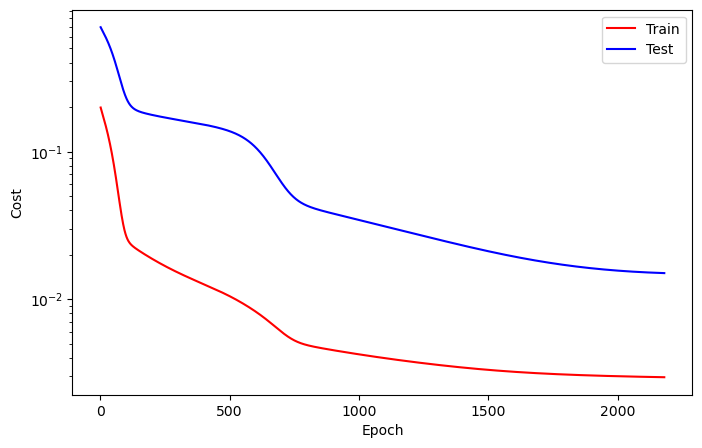

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2181
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2182
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2183
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2184
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2185
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2186
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2187
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2188
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2189
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2190
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2191
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2192
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2193
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2194
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2195
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2196
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2197
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2198
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2199
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2200
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


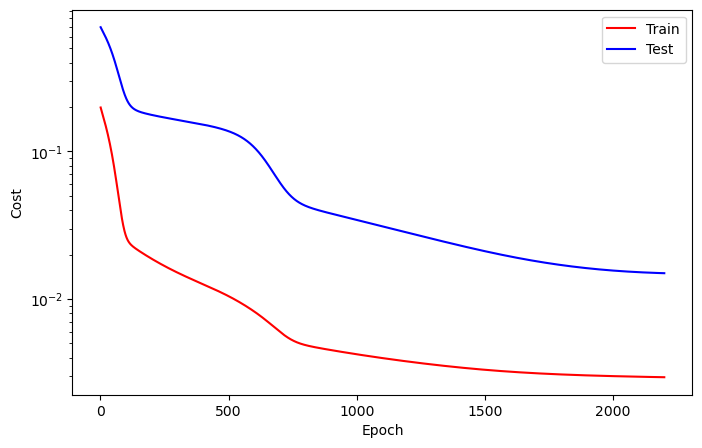

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2201
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2202
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2203
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2204
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2205
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2206
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2207
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2208
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2209
Train_cost  = 0.0030 | Test_cost  = 0.0150 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2210
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2211
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2212
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2213
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2214
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2215
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2216
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2217
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2218
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2219
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2220
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


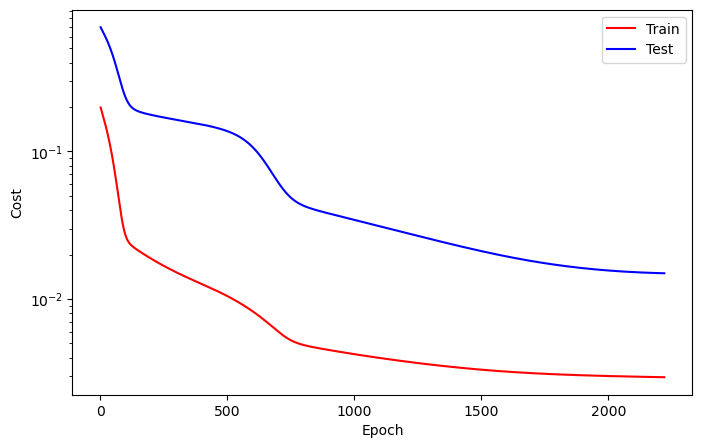

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2221
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2222
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2223
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2224
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2225
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2226
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2227
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2228
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2229
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2230
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2231
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2232
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2233
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2234
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2235
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2236
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2237
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2238
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2239
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2240
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


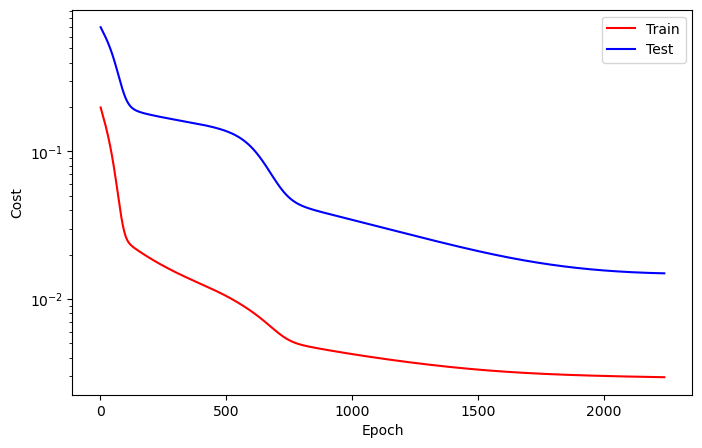

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2241
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2242
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2243
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2244
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2245
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2246
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2247
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2248
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2249
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2250
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2251
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2252
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2253
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2254
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2255
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2256
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2257
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2258
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2259
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2260
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


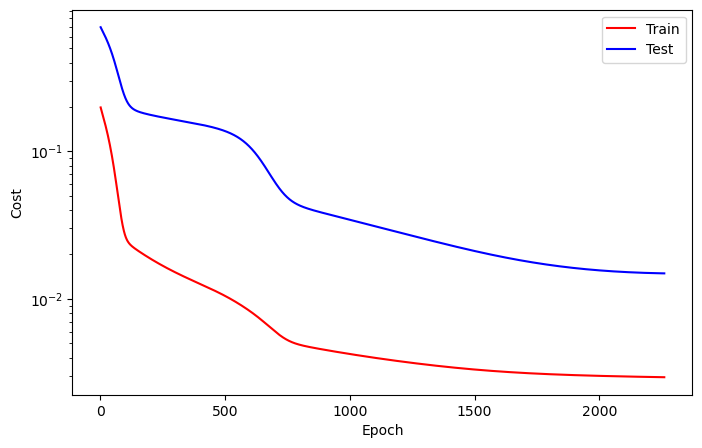

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2261
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2262
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2263
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2264
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2265
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2266
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2267
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2268
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2269
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2270
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2271
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2272
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2273
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2274
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2275
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2276
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2277
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2278
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2279
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2280
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


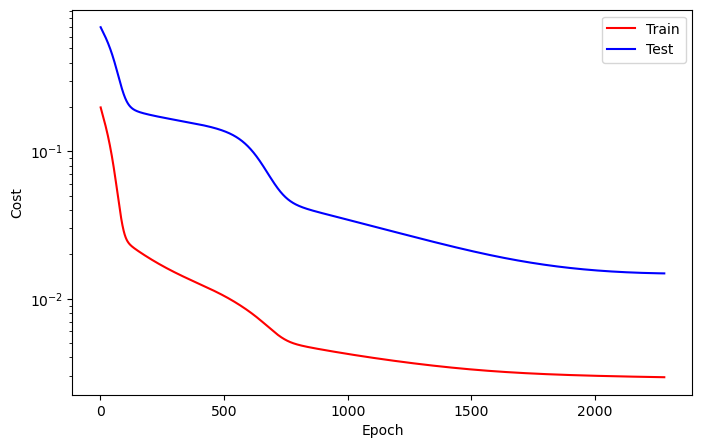

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2281
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2282
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2283
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2284
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2285
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2286
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2287
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2288
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2289
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2290
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2291
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2292
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2293
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2294
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2295
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2296
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2297
Train_cost  = 0.0029 | Test_cost  = 0.0149 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2298
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2299
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2300
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


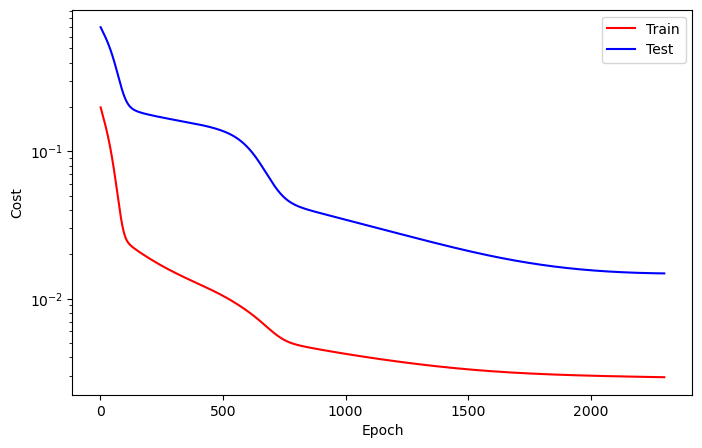

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2301
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2302
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2303
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2304
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2305
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2306
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2307
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2308
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2309
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2310
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2311
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2312
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2313
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2314
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2315
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2316
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2317
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2318
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2319
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2320
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


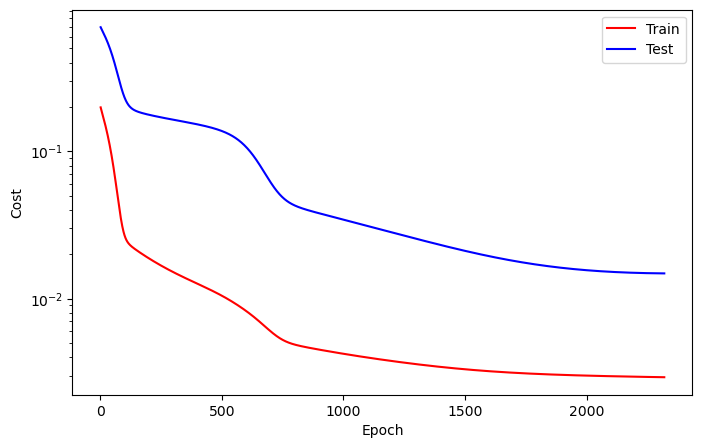

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2321
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2322
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2323
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2324
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2325
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2326
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2327
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2328
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2329
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2330
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2331
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2332
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2333
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2334
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2335
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2336
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2337
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2338
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2339
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2340
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


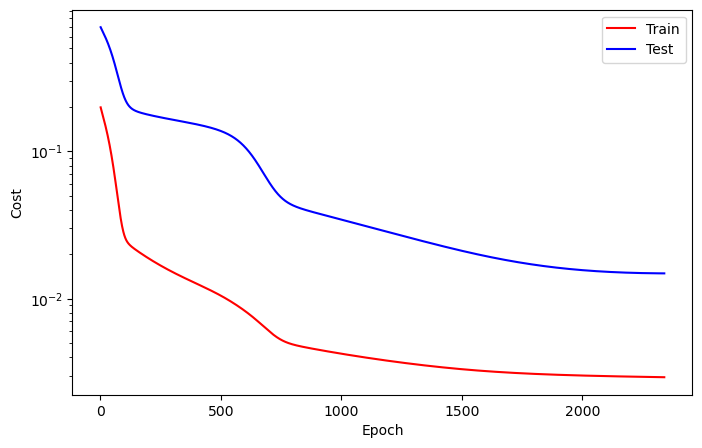

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2341
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2342
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2343
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2344
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2345
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2346
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2347
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2348
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2349
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2350
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2351
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2352
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2353
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2354
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2355
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2356
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2357
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2358
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2359
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2360
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


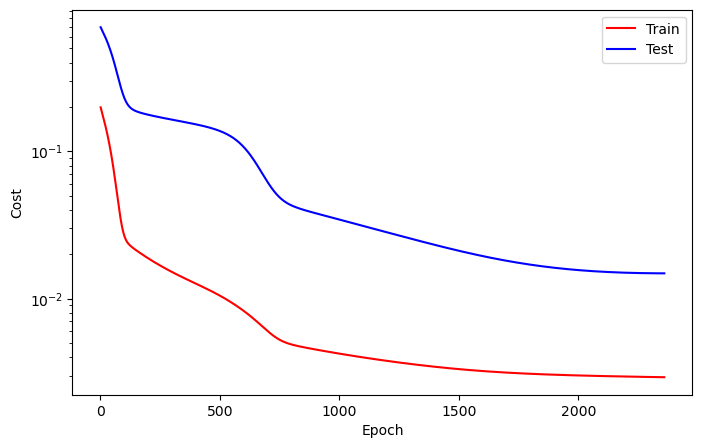

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2361
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2362
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2363
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2364
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2365
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2366
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2367
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2368
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2369
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2370
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2371
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2372
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2373
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2374
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2375
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2376
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2377
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2378
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2379
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2380
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


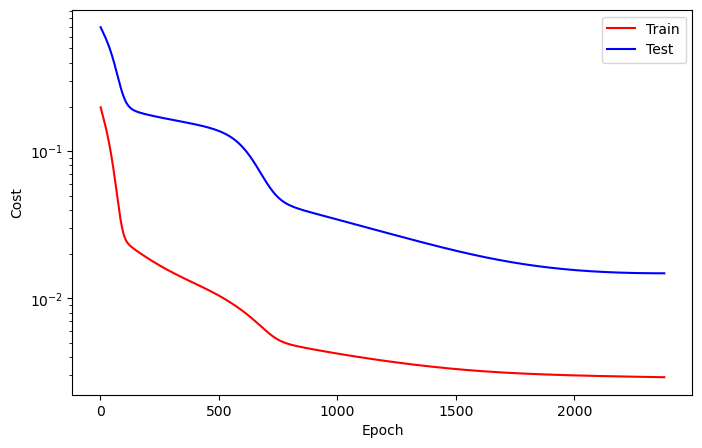

Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2381
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2382
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 
==> EarlyStop patience =  1 | Best test_cost: 0.0148


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2383
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 
==> EarlyStop patience =  2 | Best test_cost: 0.0148


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2384
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 
==> EarlyStop patience =  3 | Best test_cost: 0.0148


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2385
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 
==> EarlyStop patience =  4 | Best test_cost: 0.0148


Train:   0%|          | 0/7 [00:00<?, ?it/s]

Test:   0%|          | 0/2 [00:00<?, ?it/s]


Epoch  2386
Train_cost  = 0.0029 | Test_cost  = 0.0148 | 
==> EarlyStop patience =  5 | Best test_cost: 0.0148
==> Execute Early Stopping at epoch: 2386 | Best test_cost: 0.0148
==> Best model is saved at model/LSTM


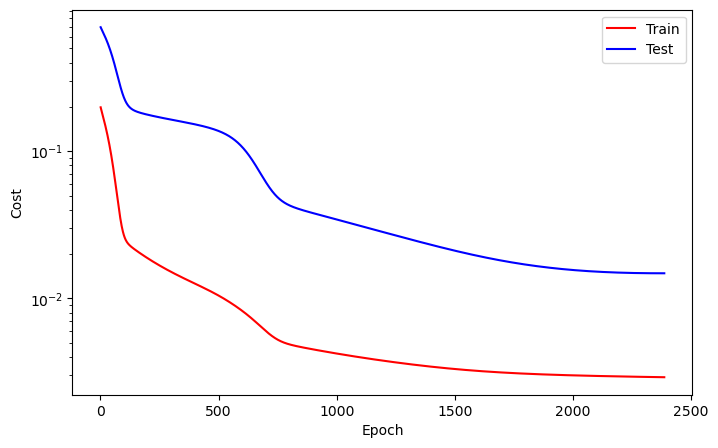

In [13]:
while True: 
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)


    #logging
    callback.log(train_cost, test_cost)

    #checkpoint 
    callback.save_checkpoint()

    callback.cost_runtime_plotting()

    #early stopping 
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

In [20]:
torch.save(model.state_dict(), "model.pth")

In [29]:
model.load_state_dict(torch.load("model.pth"))
model.to(device)

LSTM(
  (rnn): LSTM(1, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

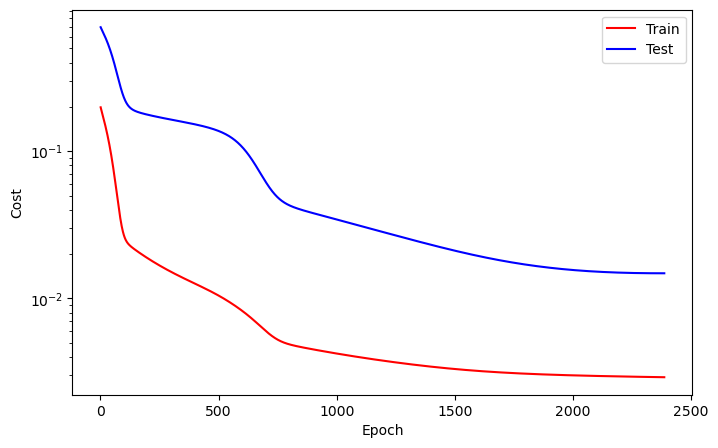

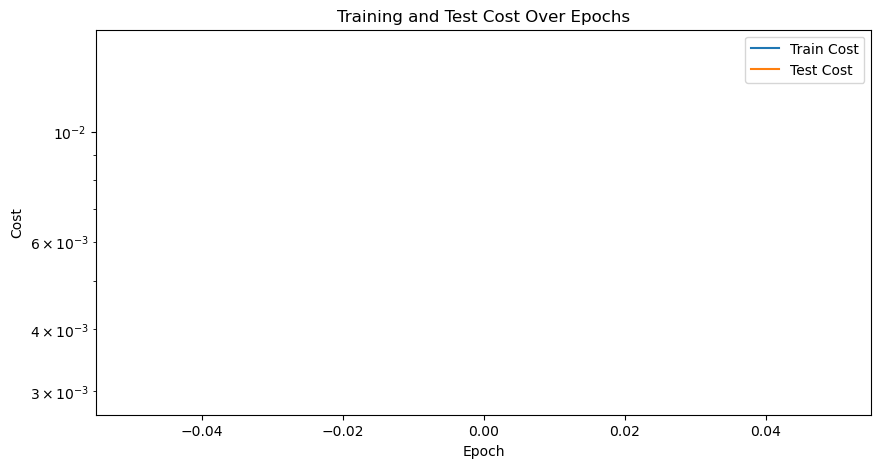

In [16]:
callback.plot_cost()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_cost, label='Train Cost')
plt.plot(test_cost, label='Test Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.yscale('log')  # semilogy scale jika diperlukan
plt.title('Training and Test Cost Over Epochs')
plt.legend()
plt.show()

In [15]:
import matplotlib.pyplot as plt

# Assuming `callback.costs` stores the logged costs
train_costs, test_costs = callback.get_costs()

plt.figure(figsize=(10, 5))
plt.plot(train_costs, label='Train Cost')
plt.plot(test_costs, label='Test Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Training and Test Cost Over Epochs')
plt.legend()
plt.show()

AttributeError: 'Callback' object has no attribute 'get_costs'

In [21]:
from utils import data4pred, pred4pred 

In [22]:
train_forecast_set = TimeSeriesDataset(ts_train, "GWH_JUAL", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "GWH_JUAL", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (89, 1, 1)
Note: last 0 data excluded

(N, S, F): (22, 1, 1)
Note: last 0 data excluded



In [23]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(targets, preds):
    return np.mean(np.abs((targets - preds) / targets)) * 100

def symmetric_mean_absolute_percentage_error(targets, preds):
    return np.mean(2.0 * np.abs(preds - targets) / (np.abs(targets) + np.abs(preds))) * 100



Text(0.5, 1.0, 'Test')

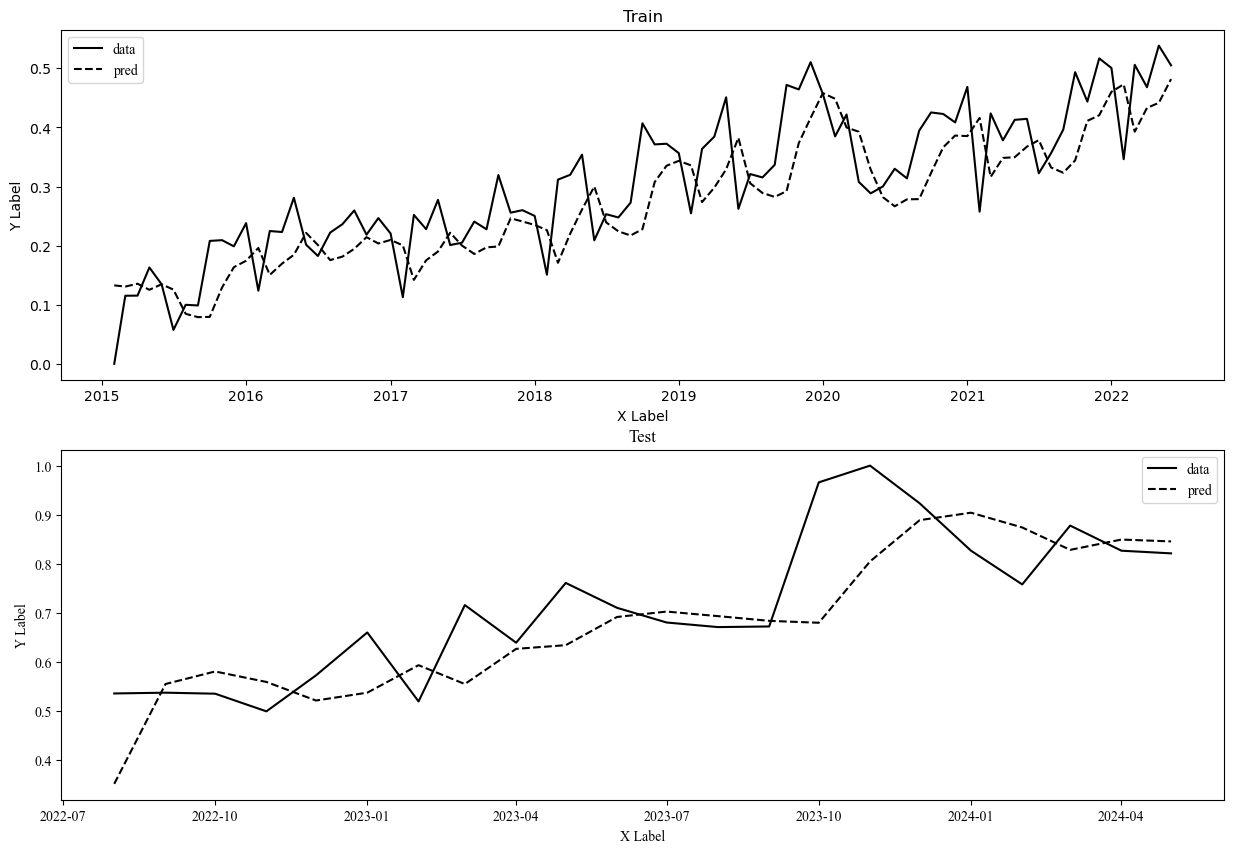

In [28]:
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

In [ ]:
test_preds, test_targets = data4pred(model, test_forecast_set, testforecastloader, device)
test_targets_array = np.array(test_targets).reshape(-1, 1)
test_preds_array = np.array(test_preds).reshape(-1, 1)

# Fit MinMaxScaler dan langsung inverse_transform
scaler = MinMaxScaler()
test_targets_original = scaler.fit_transform(test_targets_array).flatten()
test_preds_original = scaler.fit_transform(test_preds_array).flatten()

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def mean_absolute_percentage_error(targets, preds):
    targets = np.array(targets)
    preds = np.array(preds)
    return np.mean(np.abs((targets - preds) / targets)) * 100

def symmetric_mean_absolute_percentage_error(targets, preds):
    targets = np.array(targets)
    preds = np.array(preds)
    return np.mean(2.0 * np.abs(preds - targets) / (np.abs(targets) + np.abs(preds))) * 100

# Contoh penggunaan evaluasi metrik untuk data uji
test_mae = mean_absolute_error(test_targets, test_preds)
test_mse = mean_squared_error(test_targets, test_preds)
test_r2 = r2_score(test_targets, test_preds)
test_mape = mean_absolute_percentage_error(test_targets, test_preds)
test_smape = symmetric_mean_absolute_percentage_error(test_targets, test_preds)

print("Metrics for Test Data:")
print(f"MAE  : {test_mae:.4f}")
print(f"MSE  : {test_mse:.4f}")
print(f"R²   : {test_r2:.4f}")
print(f"MAPE : {test_mape:.4f}%")
print(f"SMAPE: {test_smape:.4f}%")

In [ ]:
import importlib
import utils

# Memuat ulang modul utils setelah perubahan
importlib.reload(utils)
from utils import data4pred, pred4pred 

In [ ]:
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test");